In [2]:
###HYPERPARAMETERS###
from transformers import AutoTokenizer, AutoModelForCausalLM, logging
import transformers
import torch
import pandas as pd
from sklearn.model_selection import train_test_split
import csv
import json
import argparse
import csv
import random
from torch.utils.data import Dataset
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

logging.set_verbosity_error()
random.seed(42)

In [3]:
###LOAD MISTRAL###

model_path = "mistralai/Mistral-7B-Instruct-v0.2"

device = "cuda" if torch.cuda.is_available() else "cpu"
load_in_4_bit = True if device == "cuda" else False

tokenizer = AutoTokenizer.from_pretrained(model_path)
tokenizer.pad_token = "!"  # Not EOS, will explain another time.\
load_in_4_bit = True if device == "cuda" else False
load_in_4_bit = True
model = AutoModelForCausalLM.from_pretrained(model_path, torch_dtype=torch.float16, load_in_4bit=load_in_4_bit,
                                                device_map="auto")

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

In [13]:
SEP_TOKEN = "[/INST]"
INPUT_LENGTH = 150
LABEL_LENGTH = 50


def add_prefix(prompt_prefix):
    message = [
        # {"role": "system", "content": "You are a helpful assistant who follows the following pattern."}, Not
        {"role": "user",
         "content": prompt_prefix},
        {"role": "assistant", "content": "Ok!"},
    ]
    return message


def give_example(word, target=None):
    user_prompt = {
        "role": "user", "content": f"Word: {word}"}
    if target:
        assistant_prompt = {"role": "assistant", "content": str(target) + "#"}
        return [user_prompt, assistant_prompt]
    return [user_prompt]


def get_examples(df, max_examples=2):
    examples = []
    n_elem = len(df)
    for _ in range(max_examples):
        random_index = random.randint(0, n_elem - 1)  # same index is possible, but occurs very rarely
        row = df.iloc[random_index]
        example = give_example(row["Word"], row["Clue"])
        examples += example
    return examples


def generate_prompts(data, data_train, n_examples, prompt_prefix, clue_visible=True):
    prompts = []
    for _, (_, row) in enumerate(data.iterrows()):
        message = add_prefix(prompt_prefix)
        examples = get_examples(data_train, max_examples=n_examples)
        message += examples
        test_example = give_example(row["Word"], row["Clue"] if clue_visible else None)
        message += test_example
        prompts.append(message)
    return prompts


def tokenize(prompt, tokenizer, return_tensors=None, cutoff_len=1500, padding=True):
    if padding:
        return tokenizer(
            prompt + tokenizer.eos_token,
            truncation=True,
            max_length=cutoff_len,
            padding="max_length",
            return_tensors=return_tensors
        )
    else:
        return tokenizer(
            prompt + tokenizer.eos_token,
            truncation=True,
            return_tensors=return_tensors
        )


def tokenize_prompts(prompts, tokenizer):
    tokenized_prompts, tokenized_labels = [], []
    for prompt in tqdm(prompts):
        prompt = tokenizer.apply_chat_template(prompt, tokenize=False, add_generation_prompt=True)
        prompt_splitted = prompt.split(SEP_TOKEN)
        input_str = SEP_TOKEN.join(prompt_splitted[:-1]) + SEP_TOKEN
        output_str = prompt_splitted[-1]
        input_tokenized = tokenize(
            input_str, tokenizer, return_tensors="pt", cutoff_len=INPUT_LENGTH + LABEL_LENGTH)
        output_tokenized = tokenize(
            output_str, tokenizer, return_tensors="pt", padding=False)
        tokenized_prompts.append(input_tokenized)
        tokenized_labels.append(output_tokenized)
    return tokenized_prompts, tokenized_labels


def tokenize_prompts_without_final_label(prompts, tokenizer):
    tokenized_prompts = []
    for prompt in tqdm(prompts):
        input_str = tokenizer.apply_chat_template(prompt, tokenize=False, add_generation_prompt=True)
        input_tokenized = tokenize(input_str, tokenizer, return_tensors="pt", cutoff_len=INPUT_LENGTH + LABEL_LENGTH)
        tokenized_prompts.append(input_tokenized)
    return tokenized_prompts


class CustomDataset(Dataset):
    def __init__(self, prompts, outputs):
        self.prompts = prompts
        self.outputs = outputs

    def __len__(self):
        return len(self.prompts)

    def __getitem__(self, index):
        # We ignore input text, except where the labels begin
        ignore_input_text = torch.tensor(
            [-100] * (INPUT_LENGTH + LABEL_LENGTH - len(self.outputs[index]['input_ids'][0])))

        label_ids = torch.cat(
            (ignore_input_text, self.outputs[index]["input_ids"][0]), dim=0)
        attention_mask = self.prompts[index]['attention_mask']
        input_ids = self.prompts[index]['input_ids']

        return {'input_ids': input_ids, 'attention_mask': attention_mask, 'labels': label_ids}


def postprocess_generated_text(text):
    text = text.split("\n")[0]
    text = text.split("#")[0]
    if text[0:3] == "1. ":
        text = text[3:]
    if text[-1] == "(" and text[-3] == ")":
        text = text[:-3]
    return text


def predict_new_examples(tokenized_prompts, model, df_words, tokenizer, device, print_output=False):
    predictions = []

    for index in range(len(tokenized_prompts)):
        prompt = tokenized_prompts[index]

        #input_text = tokenizer.decode(prompt["input_ids"][0], skip_special_tokens=True)

        # Replace Padding Token
        # print("\nInput Text: {}".format(input_text.replace("!", "")))

        if print_output:
            print("\n-----Example {}----".format(index + 1))
            print("\nWord: {}".format(df_words["Word"][index]))

        output = model.generate(**prompt.to(device), max_new_tokens=50)
        generated_text = tokenizer.decode(output[0], skip_special_tokens=True)

        generated_prediction = generated_text.split("[/INST]")[-1]
        prediction = postprocess_generated_text(generated_prediction)
        predictions.append(prediction)

        if print_output:
            print("\nGenerated Clue: {}".format(prediction))

        out = model(**prompt.to(device), output_attentions=True)

        attentions = out.attentions
        tokens = tokenizer.convert_ids_to_tokens(prompt["input_ids"][0])

        seq_begin = np.where(np.array(tokens) == "Ok")[0][0] + 1
        
        print(len(attentions), attentions[0].shape)
        print(tokens[seq_begin:])

        for i, attention_map in enumerate(attentions):
            attention_map = attention_map.mean(dim=1).squeeze().cpu().detach().numpy()
            plot_attention_map(f"Attention Map {i + 1}", attention_map[seq_begin:, seq_begin:], tokens[seq_begin:])

        #mean_attention_map = attentions[-1].mean(dim=1).squeeze().cpu().detach().numpy()

        #plot_attention_map("Attention Map Mean", mean_attention_map[seq_begin:, seq_begin:], tokens[seq_begin:])

        layer = 11
        print(f"Layer {layer + 1}")
        for i in range(len(attentions)):
            attention_map = attentions[layer][:, i].squeeze().cpu().detach().numpy()
            plot_attention_map(f"Attention Map Layer {layer} with head {i + 1}", attention_map[seq_begin:, seq_begin:], tokens[seq_begin:])

    return predictions

def plot_attention_map(title, attention_map, tokens):
    # Ensure the size of the attention map matches the number of tokens
    assert attention_map.shape[0] == len(tokens) == attention_map.shape[1], "Attention map dimensions must match the number of tokens."

    plt.figure(figsize=(15, 12))
    sns.heatmap(attention_map / np.linalg.norm(attention_map), xticklabels=tokens, yticklabels=tokens, cmap='viridis')
    plt.title(title)
    plt.xlabel("Tokens (from)")
    plt.ylabel("Tokens (to)")
    plt.show()

In [14]:
def generate(n_examples, model, tokenizer, input_words_file_path, output_words_clues_path, prompt_prefix, print_output, device):



    ###CEATE TRAIN DATASET AND READ WORDS###

    words = []
    with open(input_words_file_path, 'r') as file:
        for line in file:
            # Strip whitespace and add the line as a string to the list
            words.append(line.strip())

    category = words[0]
    words = words[1:2]
    df_new_words = pd.DataFrame(words, columns=['Word'])

    data_file_path = "dummy_data.csv"
    df_train = pd.read_csv(data_file_path, sep=";", encoding='latin1')

    # normalize index
    df_train.reset_index(drop=True, inplace=True)

    # get percentage of dataset to improve runtime
    TRAIN_PERCENTAGE = 1  # percentage of train data used
    df_train = df_train.head(int(len(df_train) * TRAIN_PERCENTAGE))

    new_prompts = generate_prompts(df_new_words, df_train, n_examples, prompt_prefix, clue_visible=False)

    new_tokenized_prompts = tokenize_prompts_without_final_label(new_prompts, tokenizer)

    ###GENERATE###

    predicted_clues = predict_new_examples(new_tokenized_prompts, model, df_new_words, tokenizer, device, print_output)

    if print_output:
        for index in range(len(predicted_clues)):
            print("\n-----Word {}----".format(index + 1))
            print("\nWord: {}".format(words[index]))
            print("\nGenerated Clue: {}".format(predicted_clues[index]))

    with open(output_words_clues_path, 'w', newline='') as file:
        writer = csv.writer(file, delimiter=";")
        writer.writerow(["Word", "Clue"])
        for clue_word_pair in zip(words, predicted_clues):
            writer.writerow(clue_word_pair)

100%|██████████| 1/1 [00:00<?, ?it/s]



-----Example 1----

Word: ant

Generated Clue: Insect that forms intricate colonies, carrying leaves back to their hill.
32 torch.Size([1, 32, 200, 200])
['!', '</s>', '▁[', 'INST', ']', '▁Word', ':', '▁Ele', 'phant', '▁[', '/', 'INST', ']', 'Never', '▁forget', 's', ',', '▁with', '▁ears', '▁bigger', '▁than', '▁its', '▁face', '.', '#', '</s>', '▁[', 'INST', ']', '▁Word', ':', '▁Se', 'al', '▁[', '/', 'INST', ']', 'Cl', 'aps', '▁on', '▁land', ',', '▁sw', 'ims', '▁in', '▁seas', '.', '#', '</s>', '▁[', 'INST', ']', '▁Word', ':', '▁ant', '▁[', '/', 'INST', ']', '</s>']


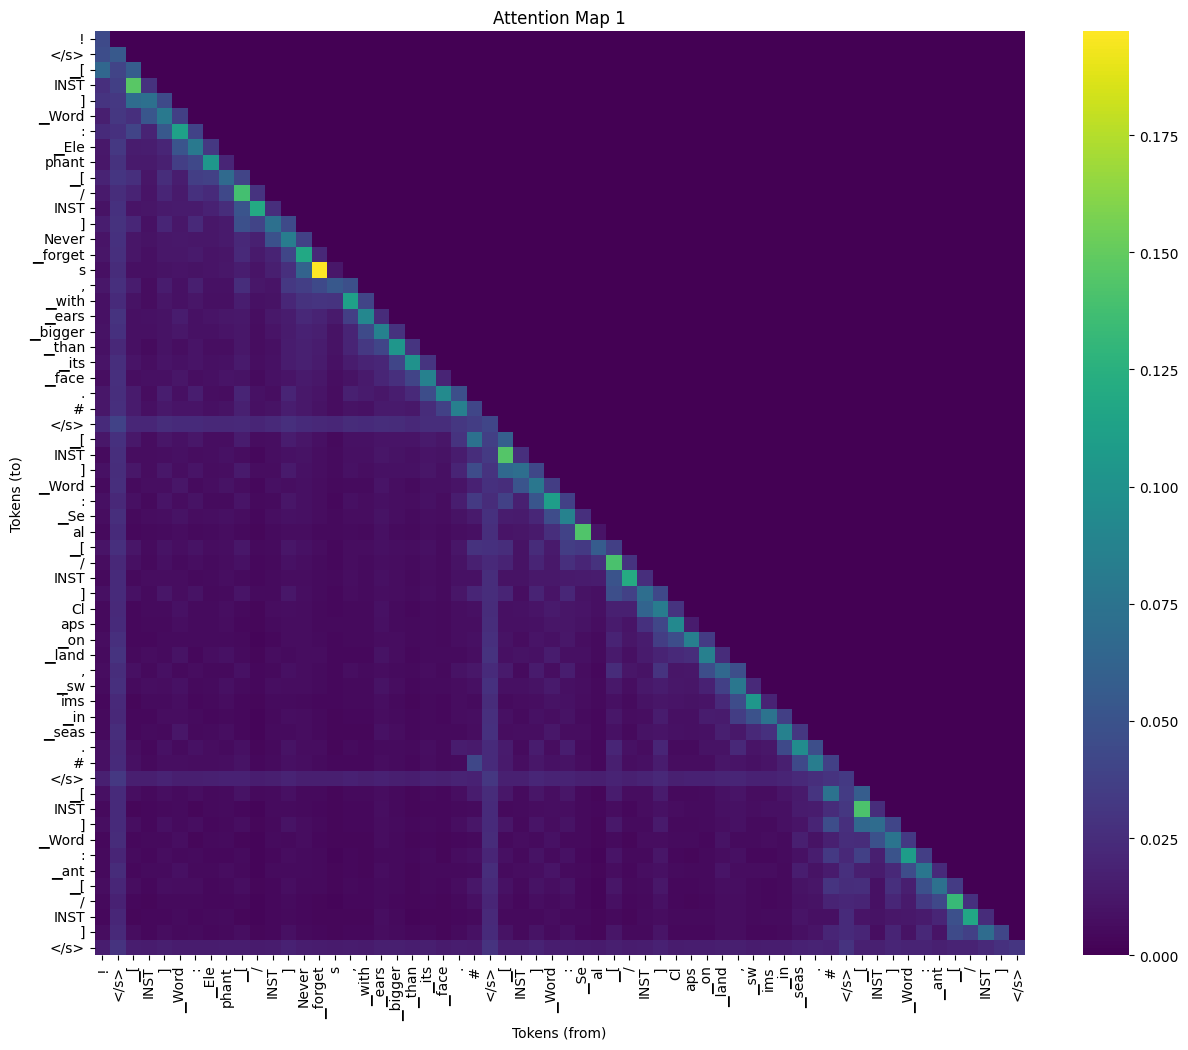

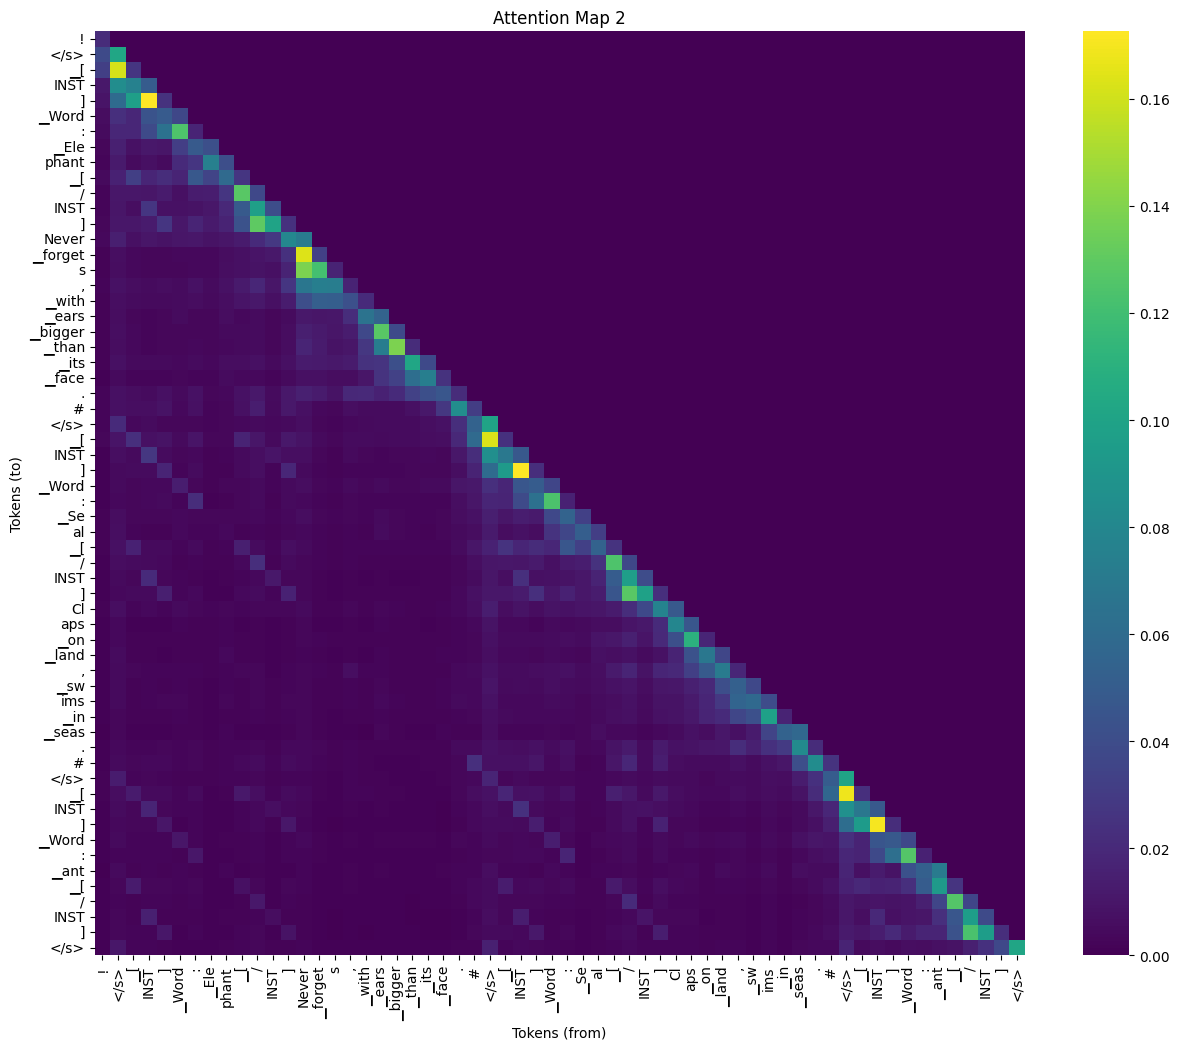

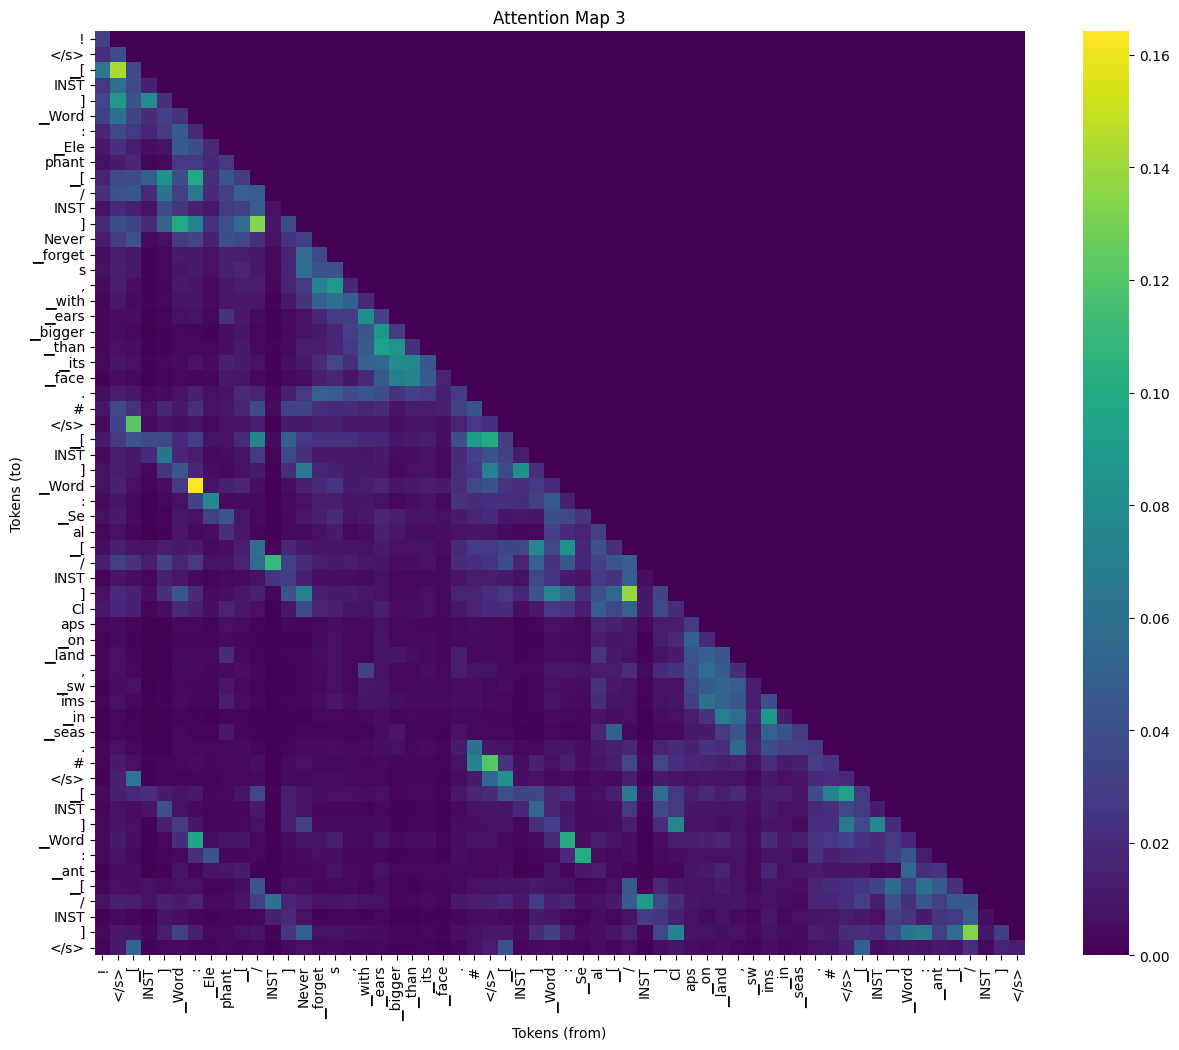

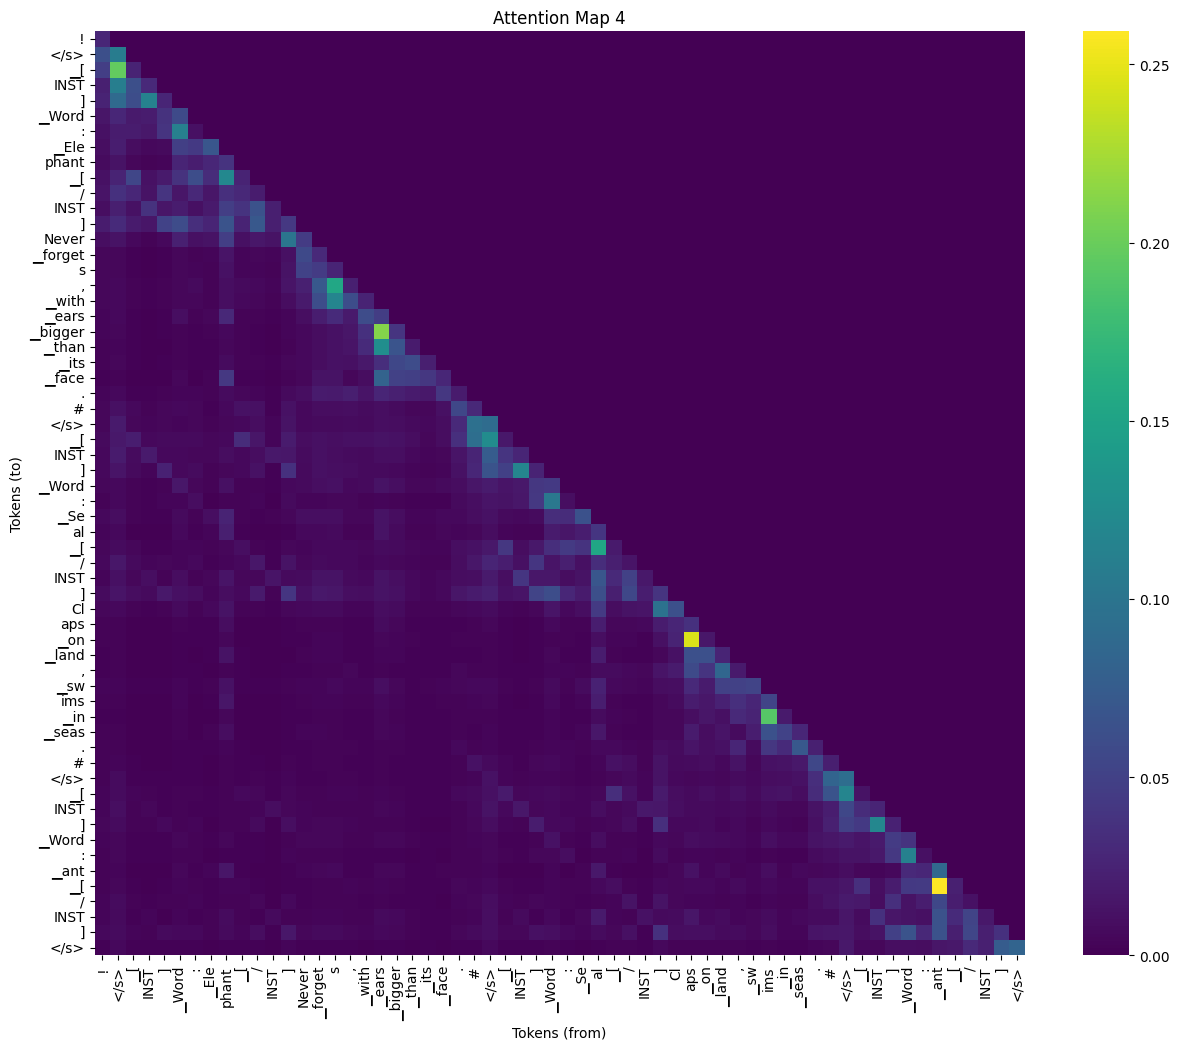

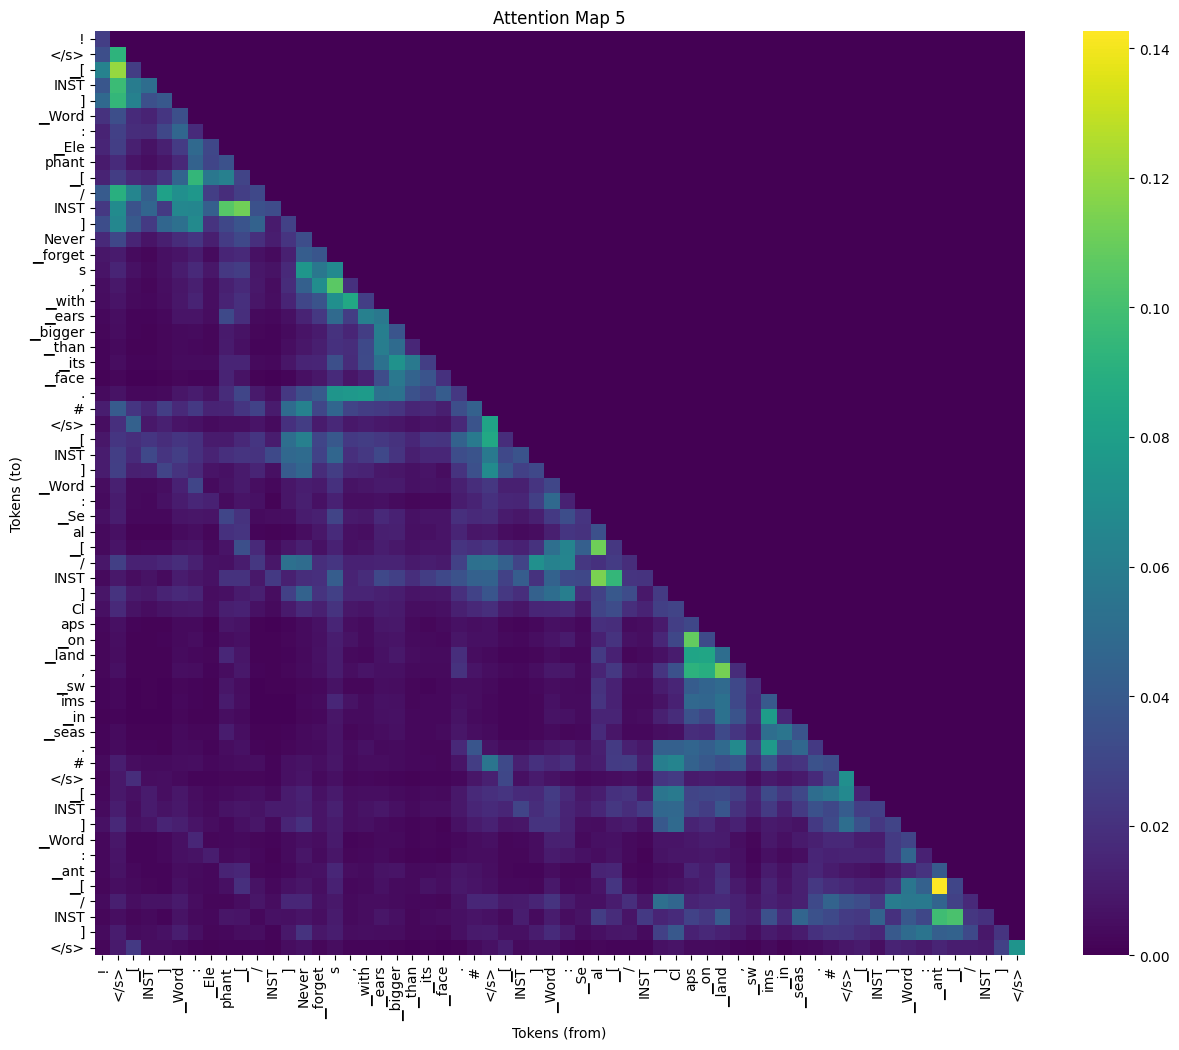

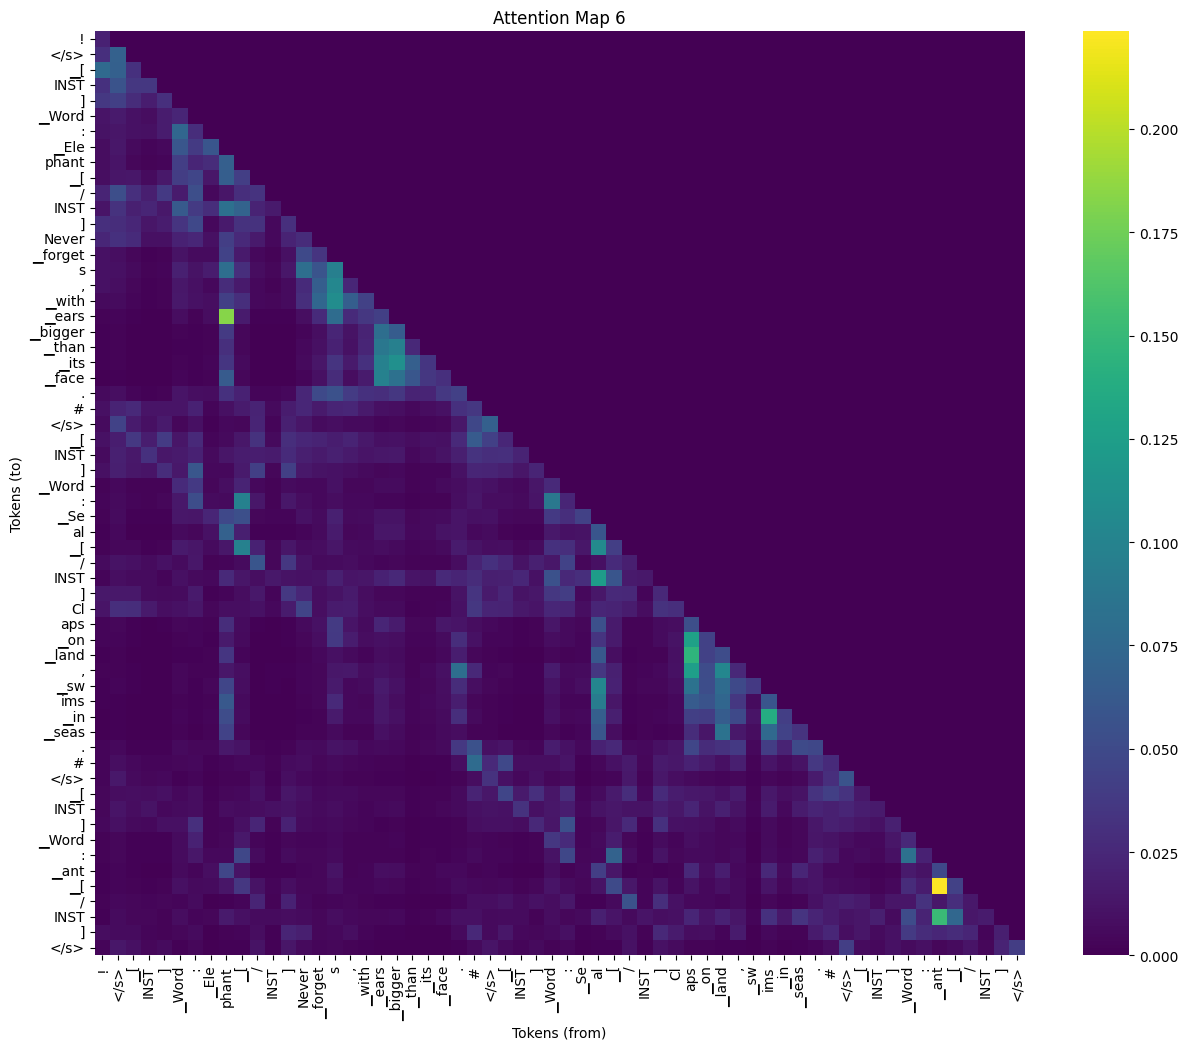

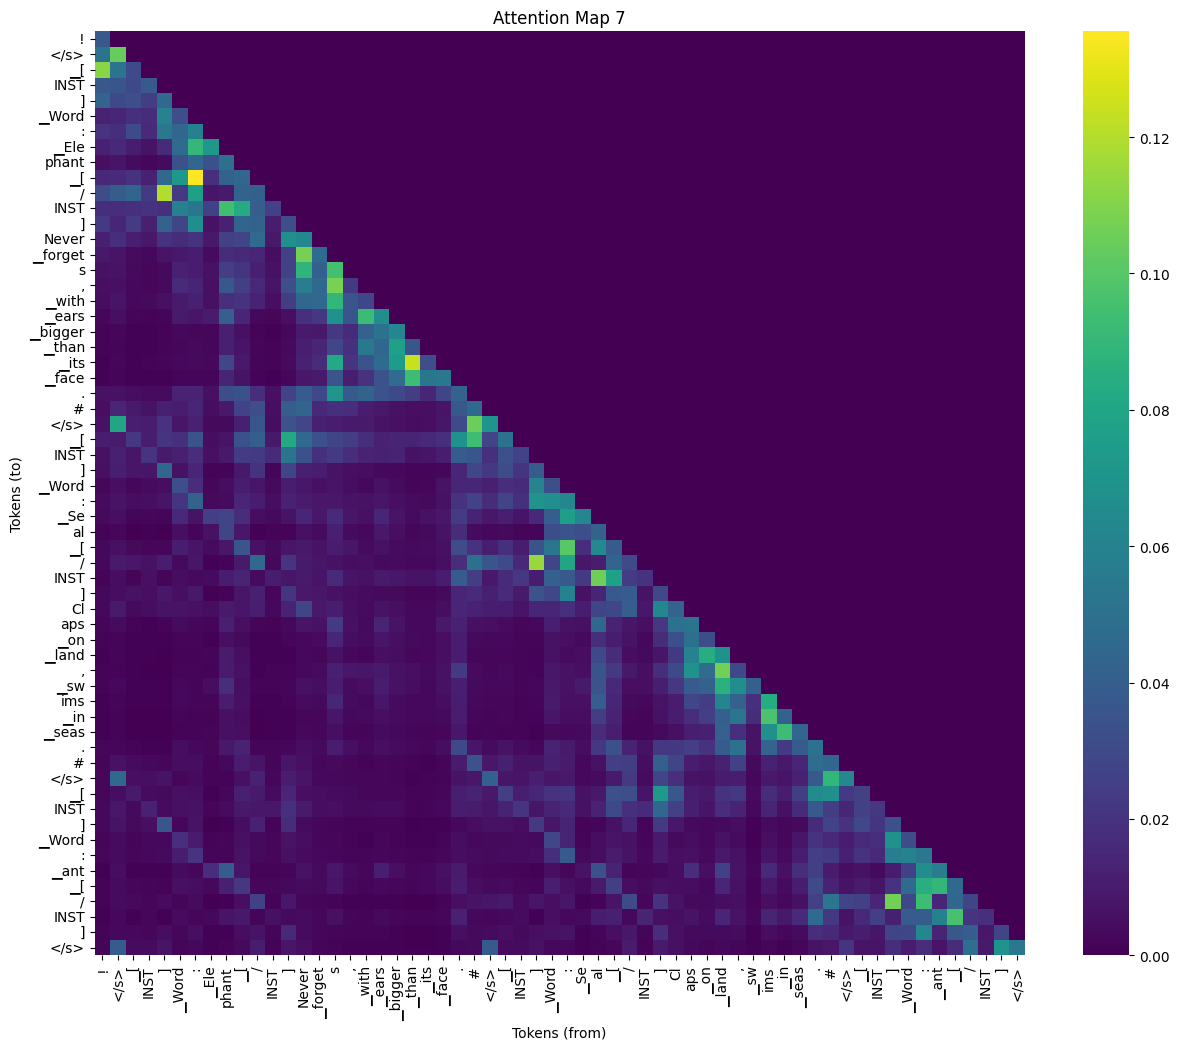

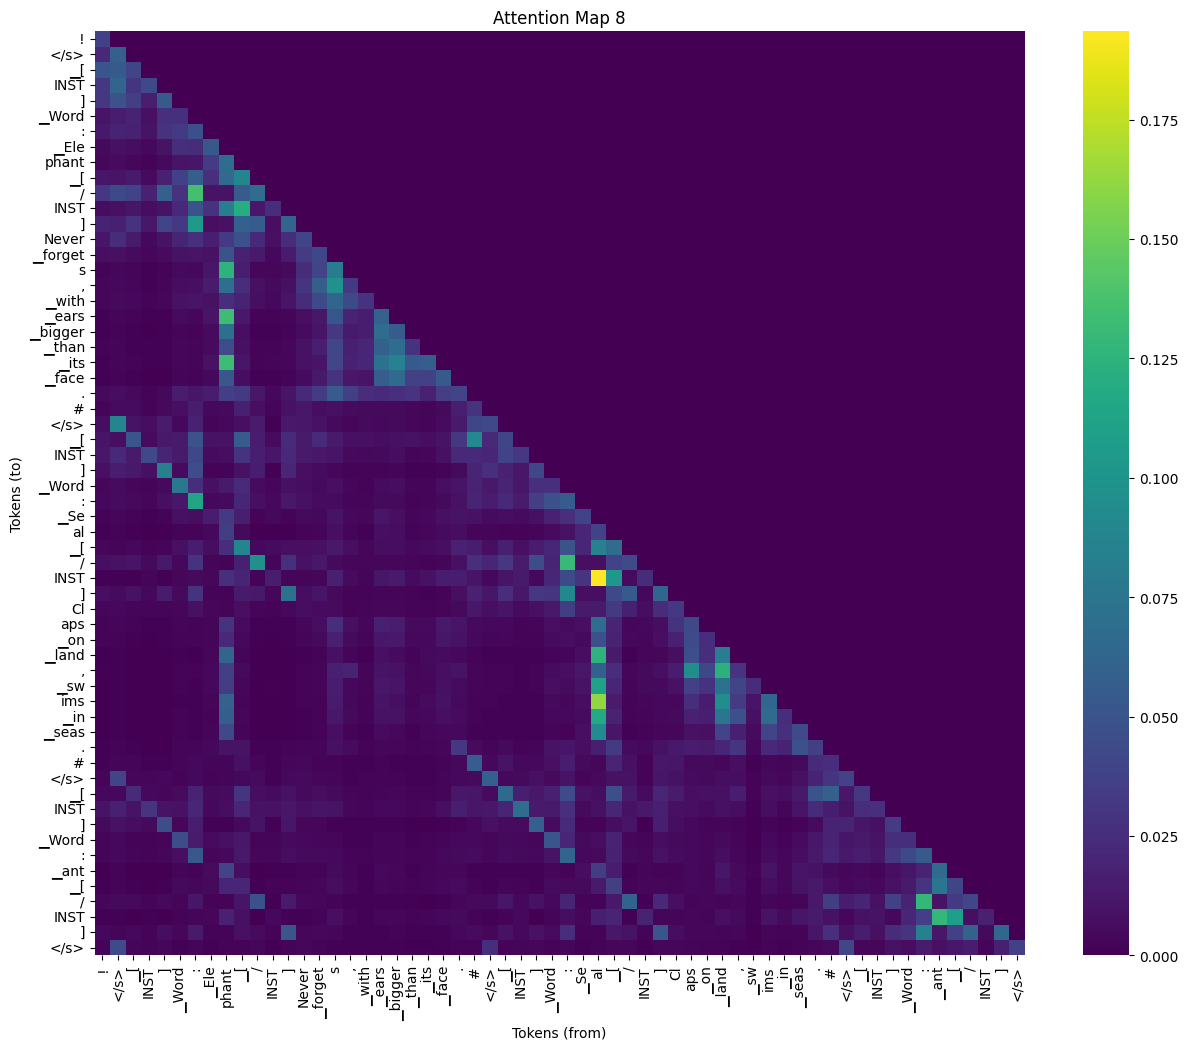

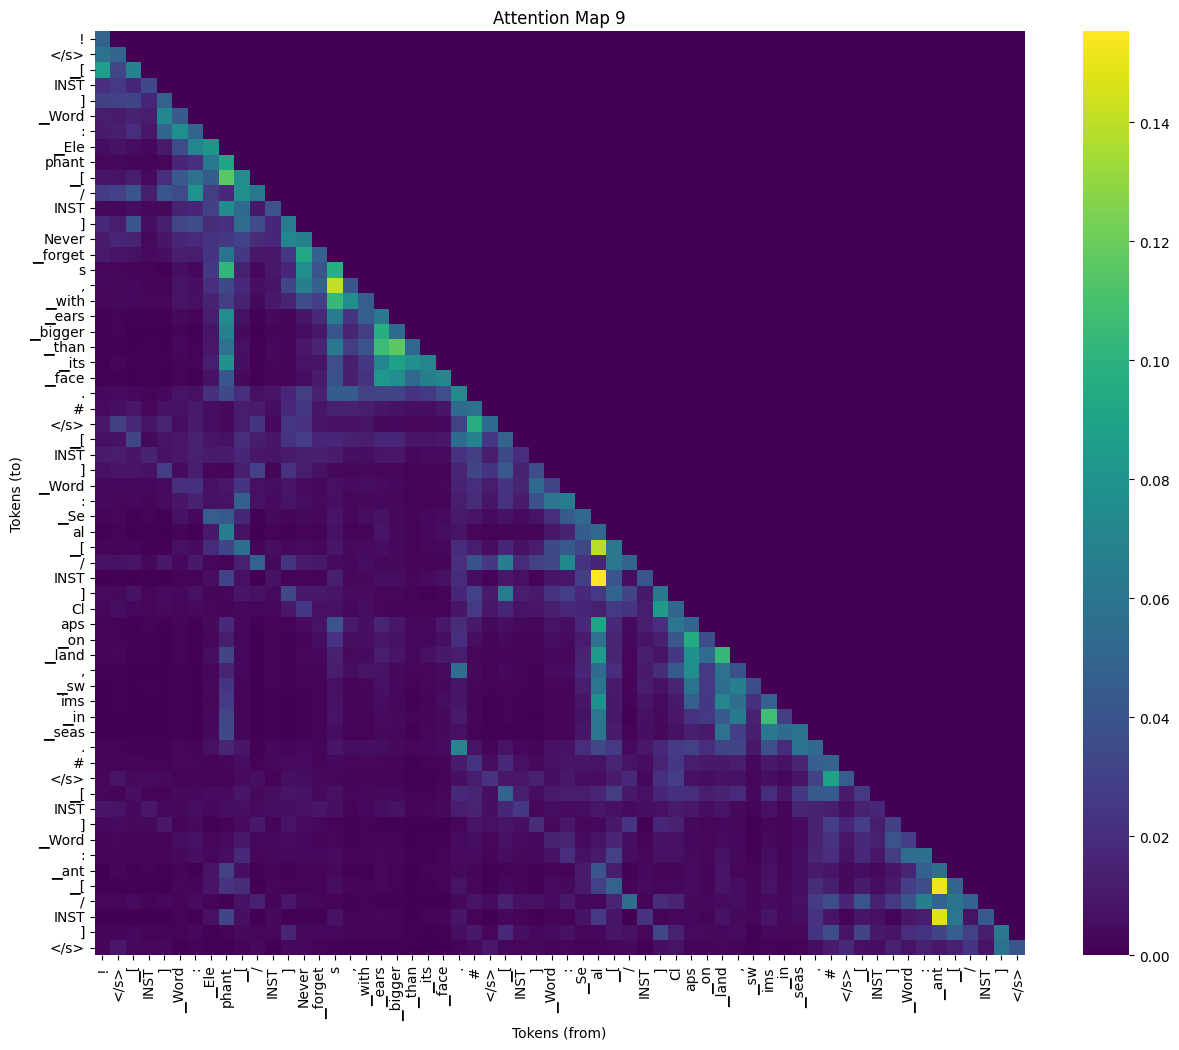

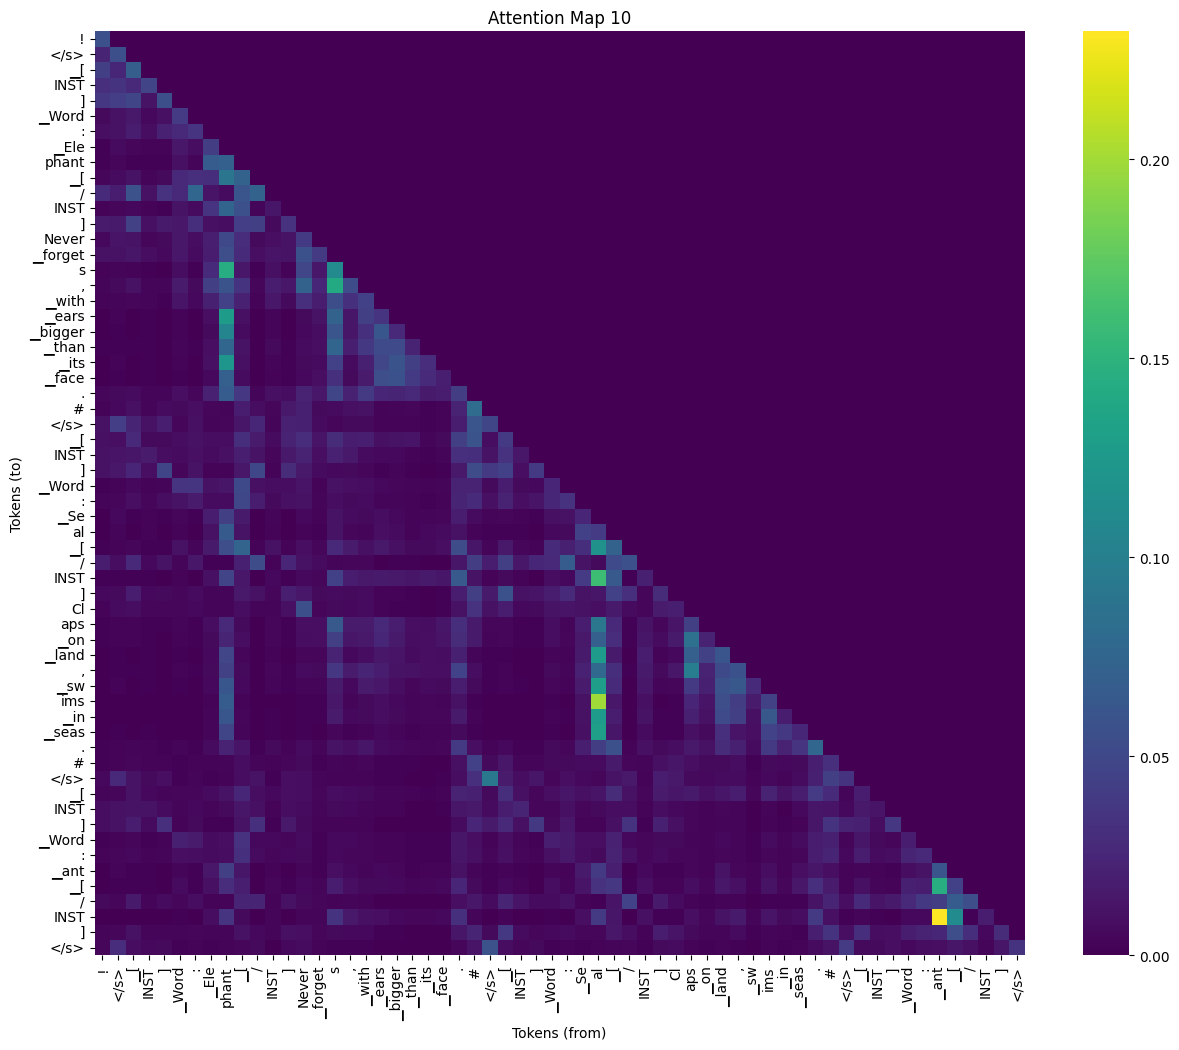

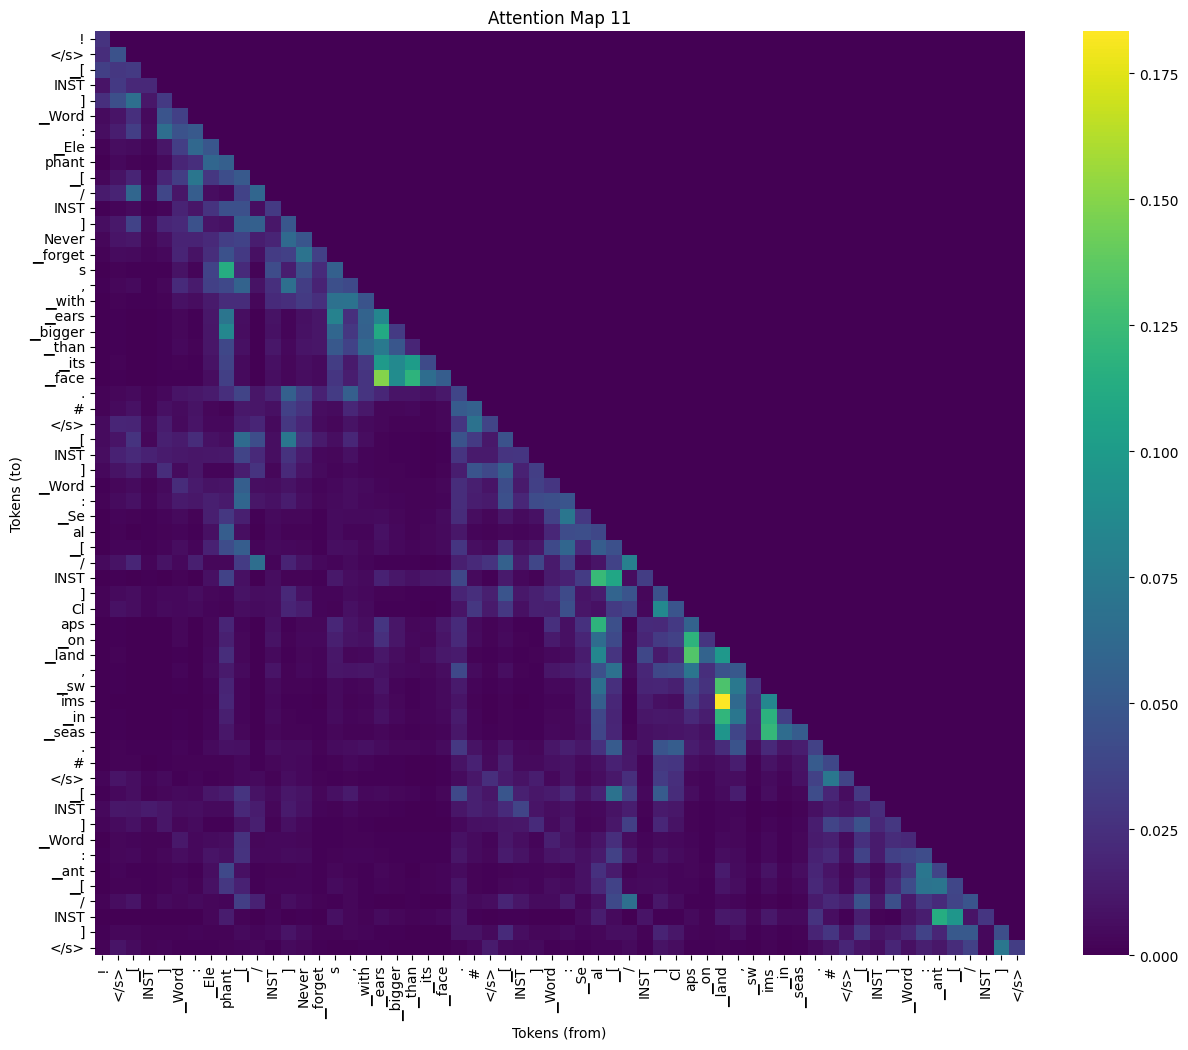

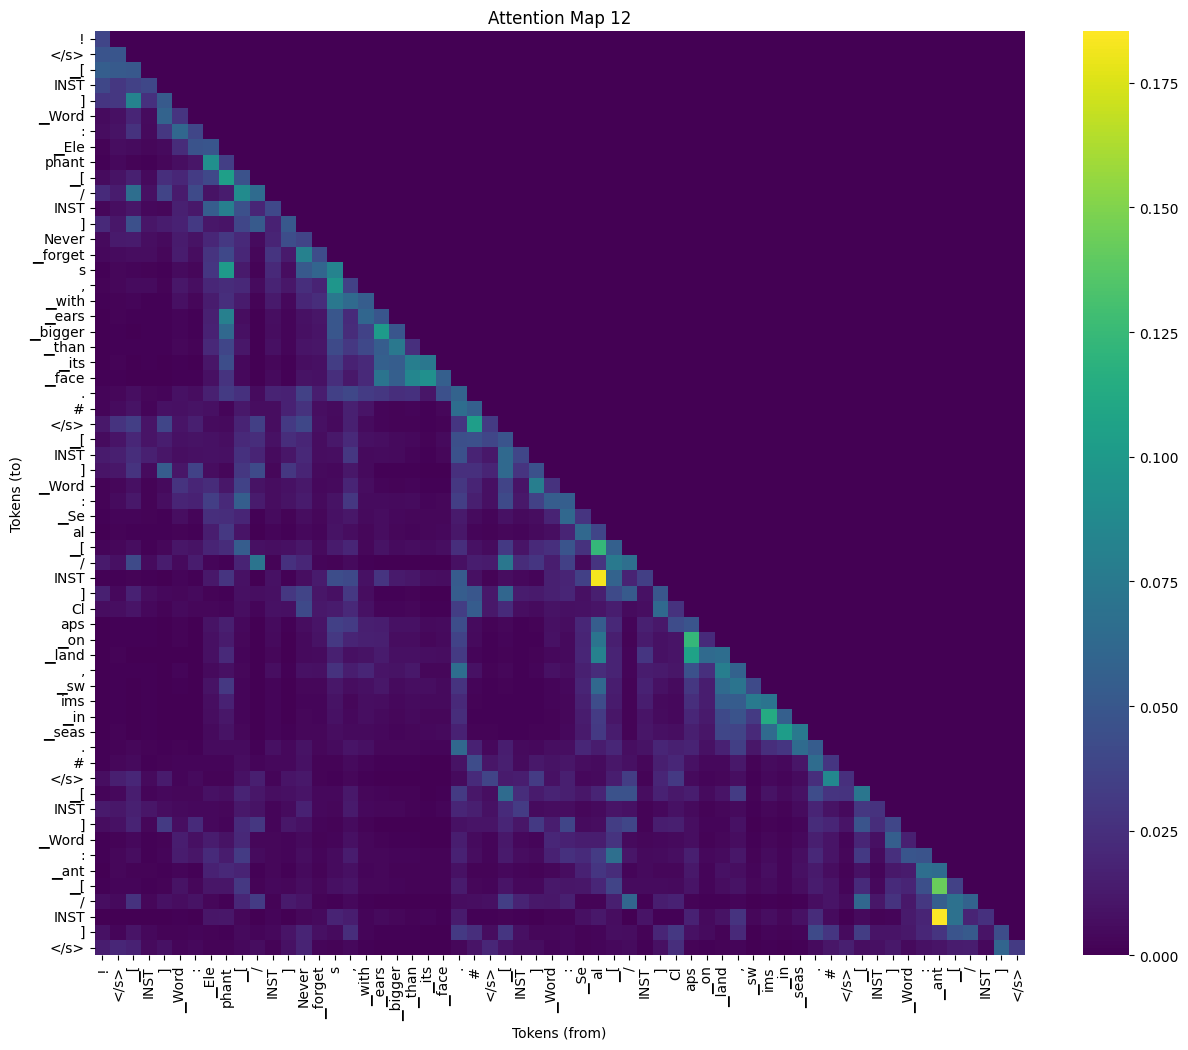

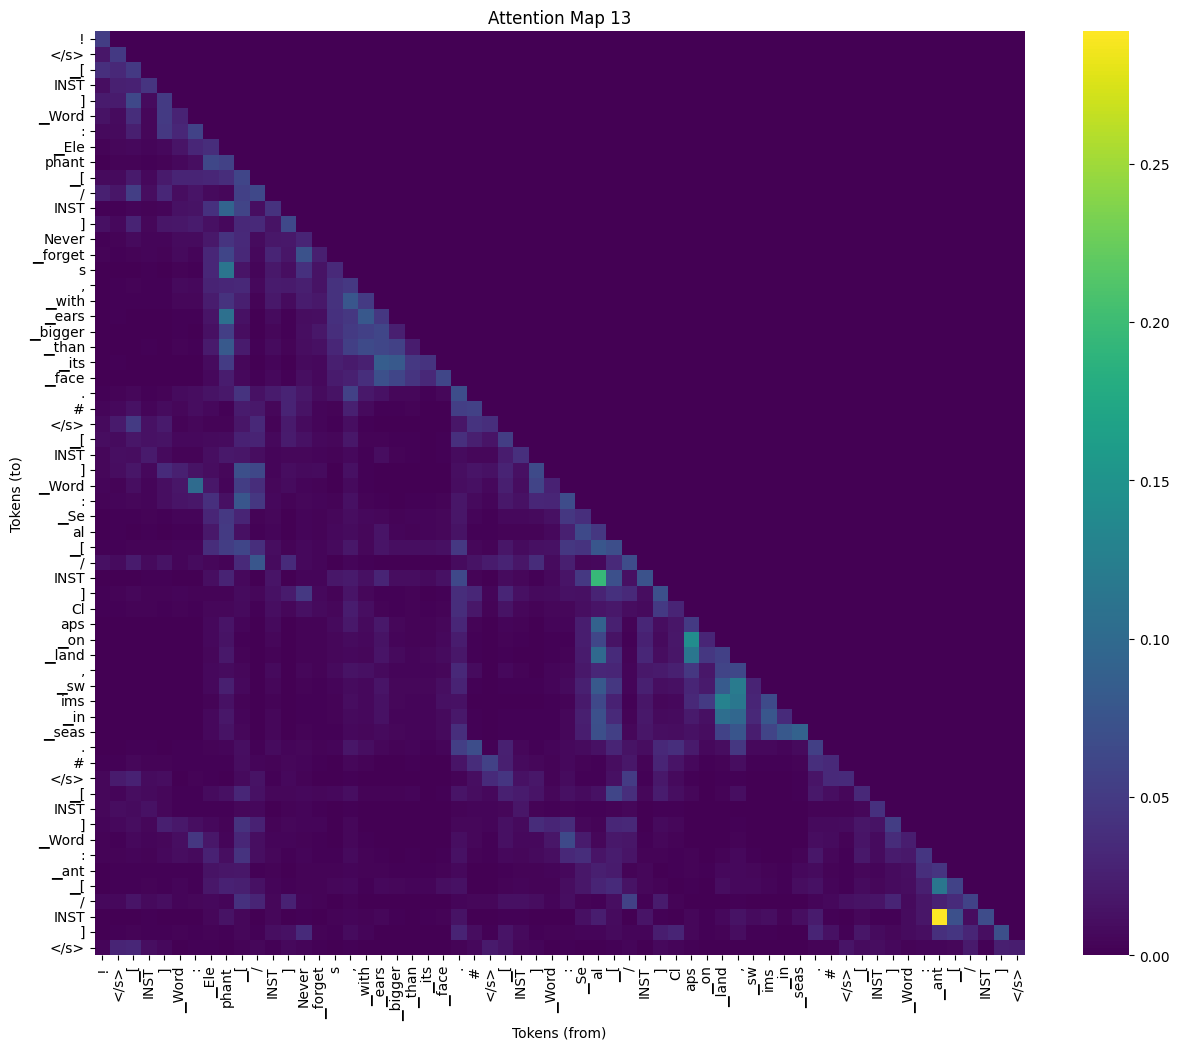

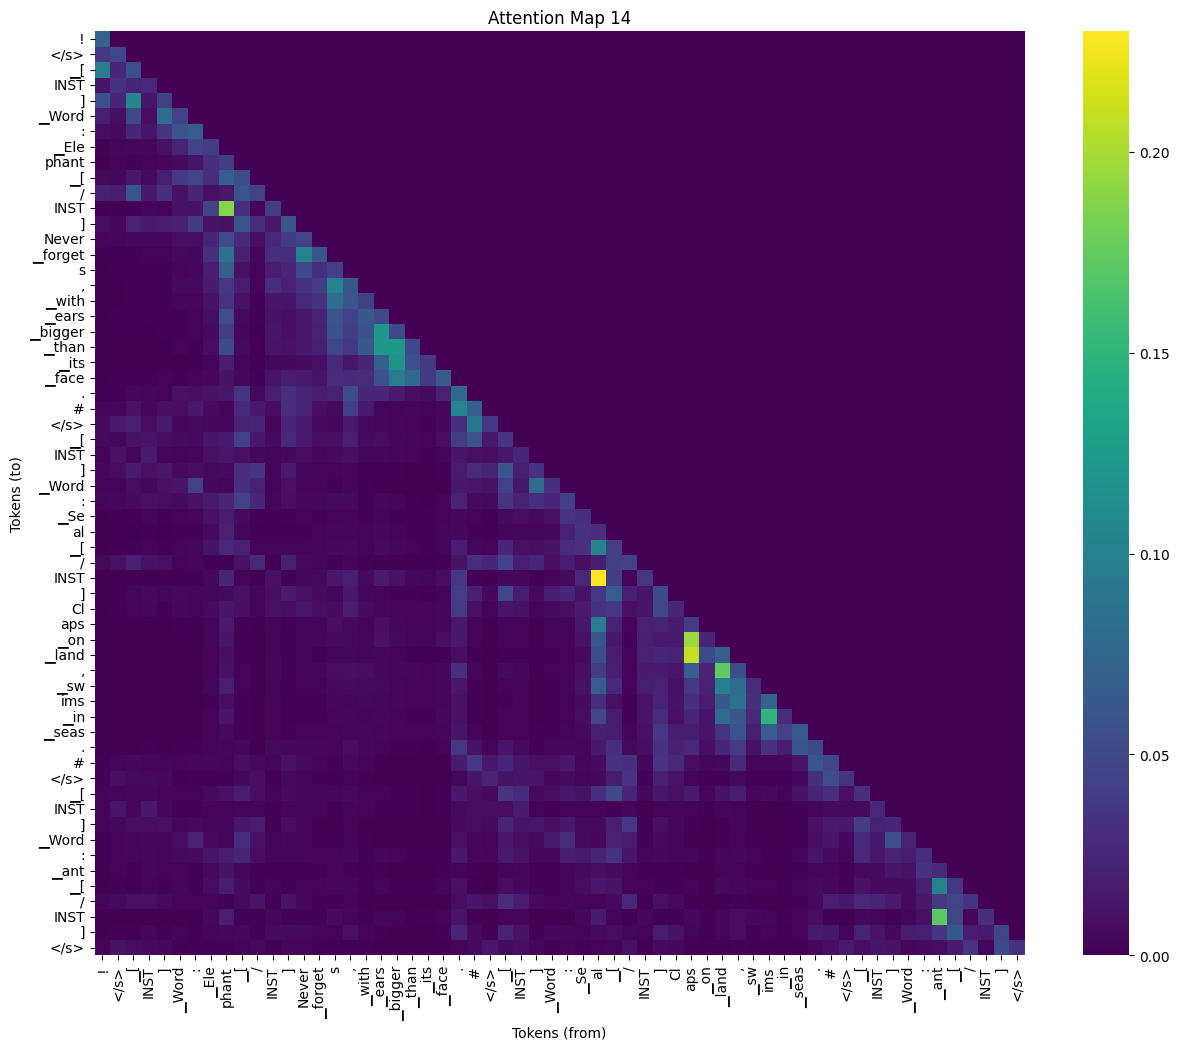

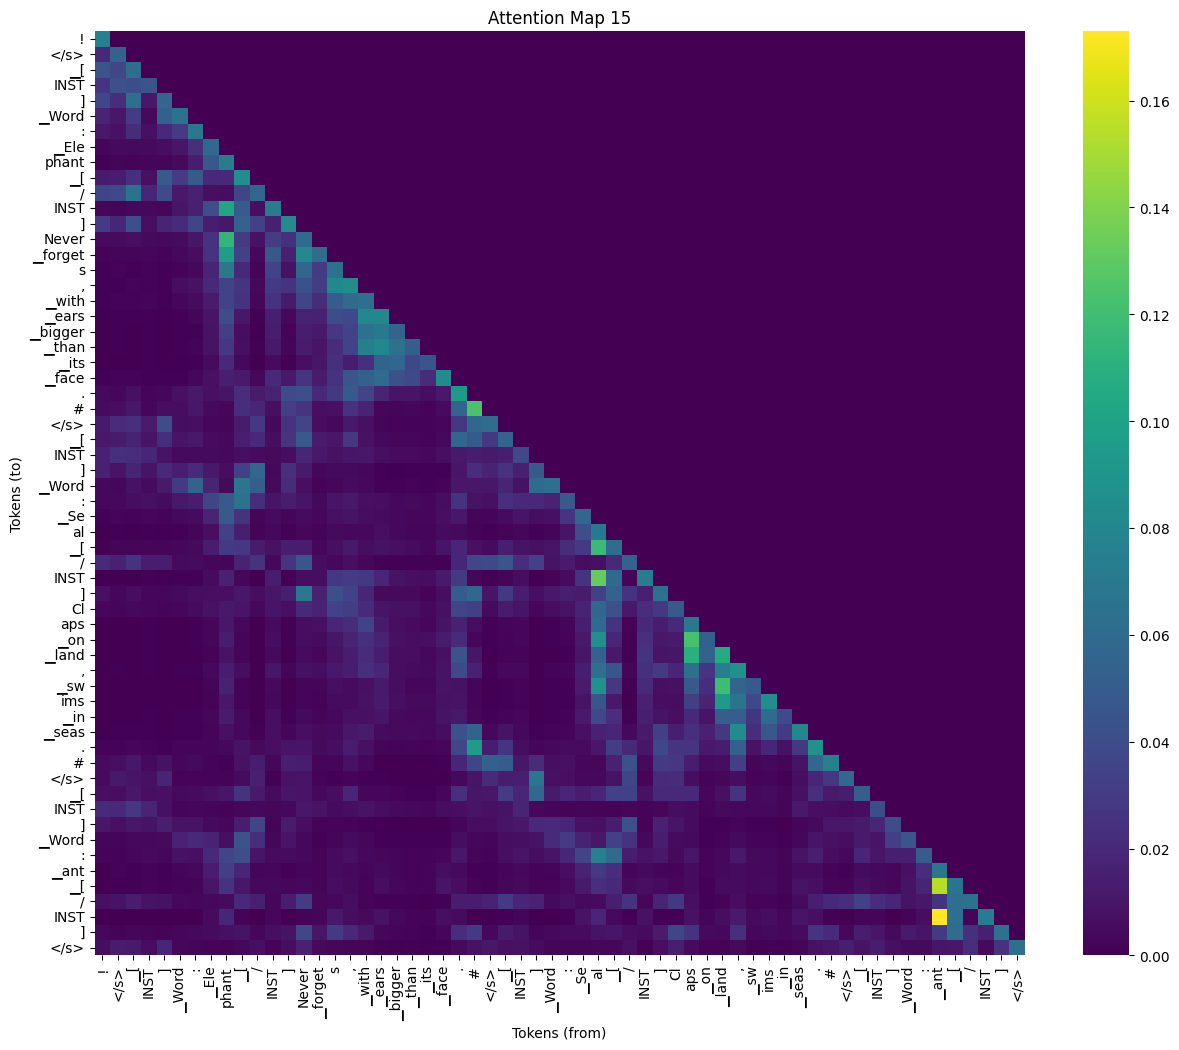

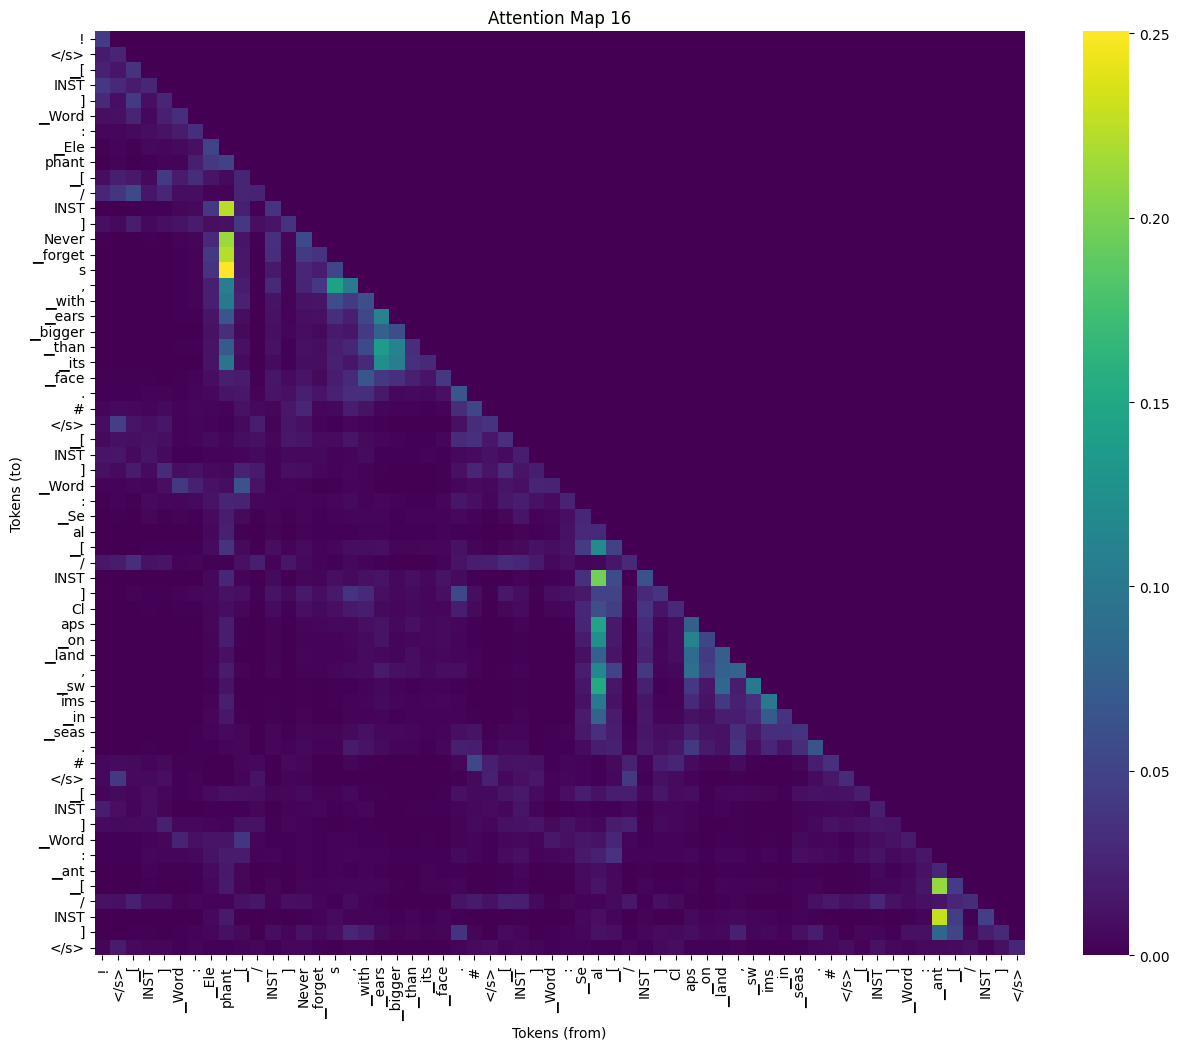

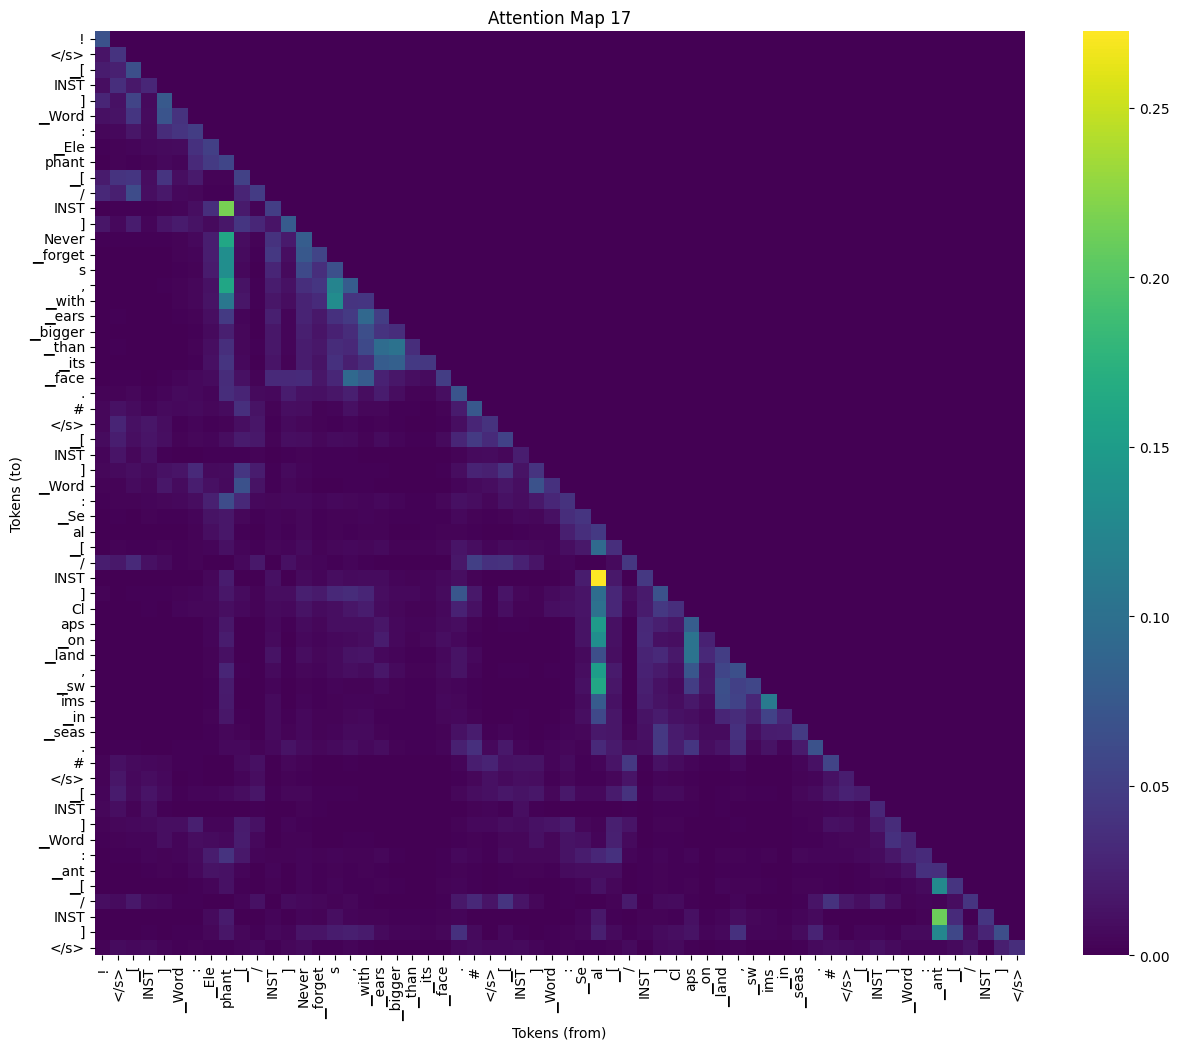

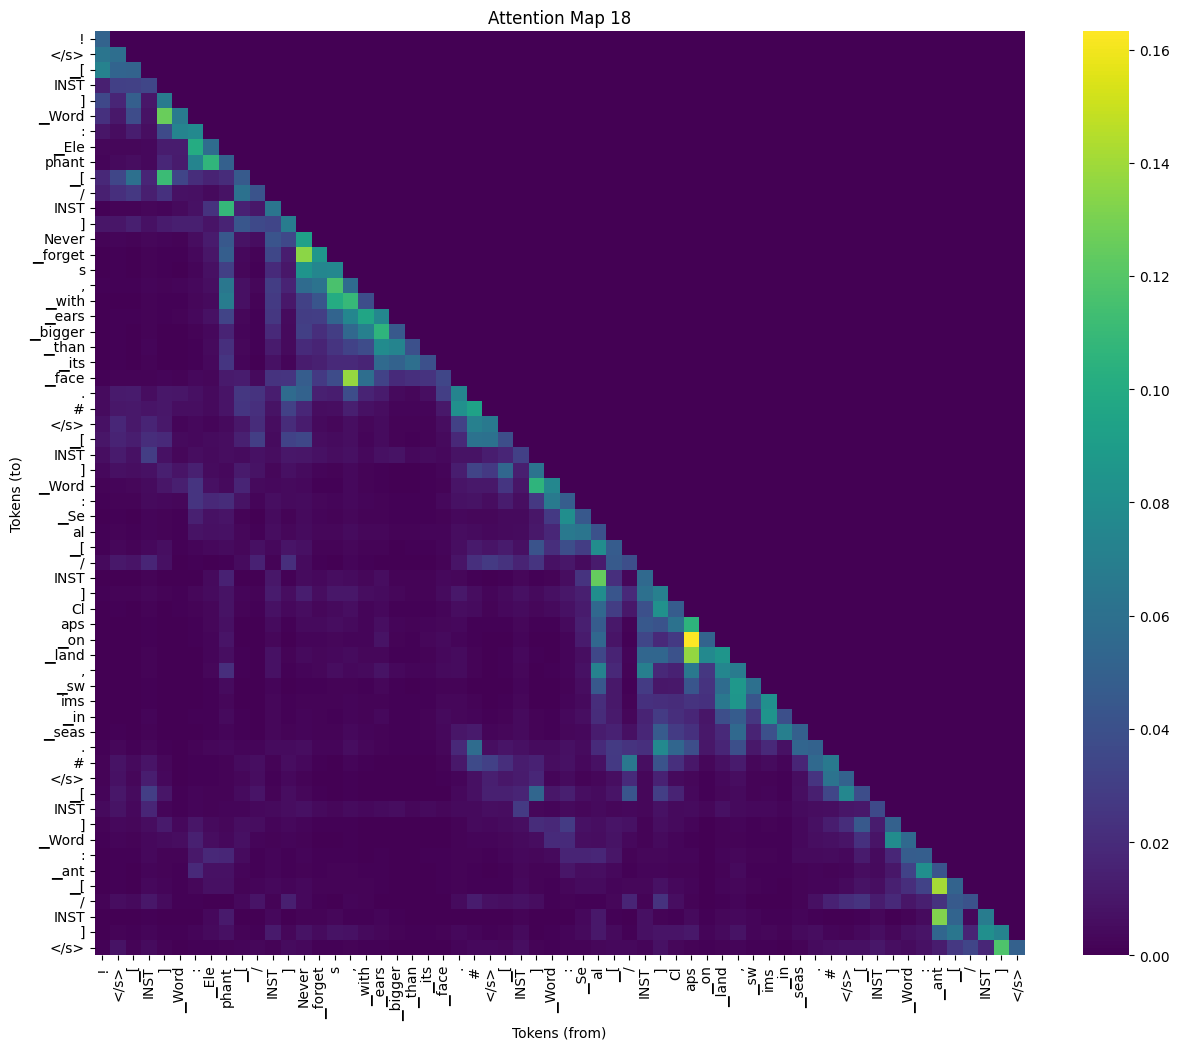

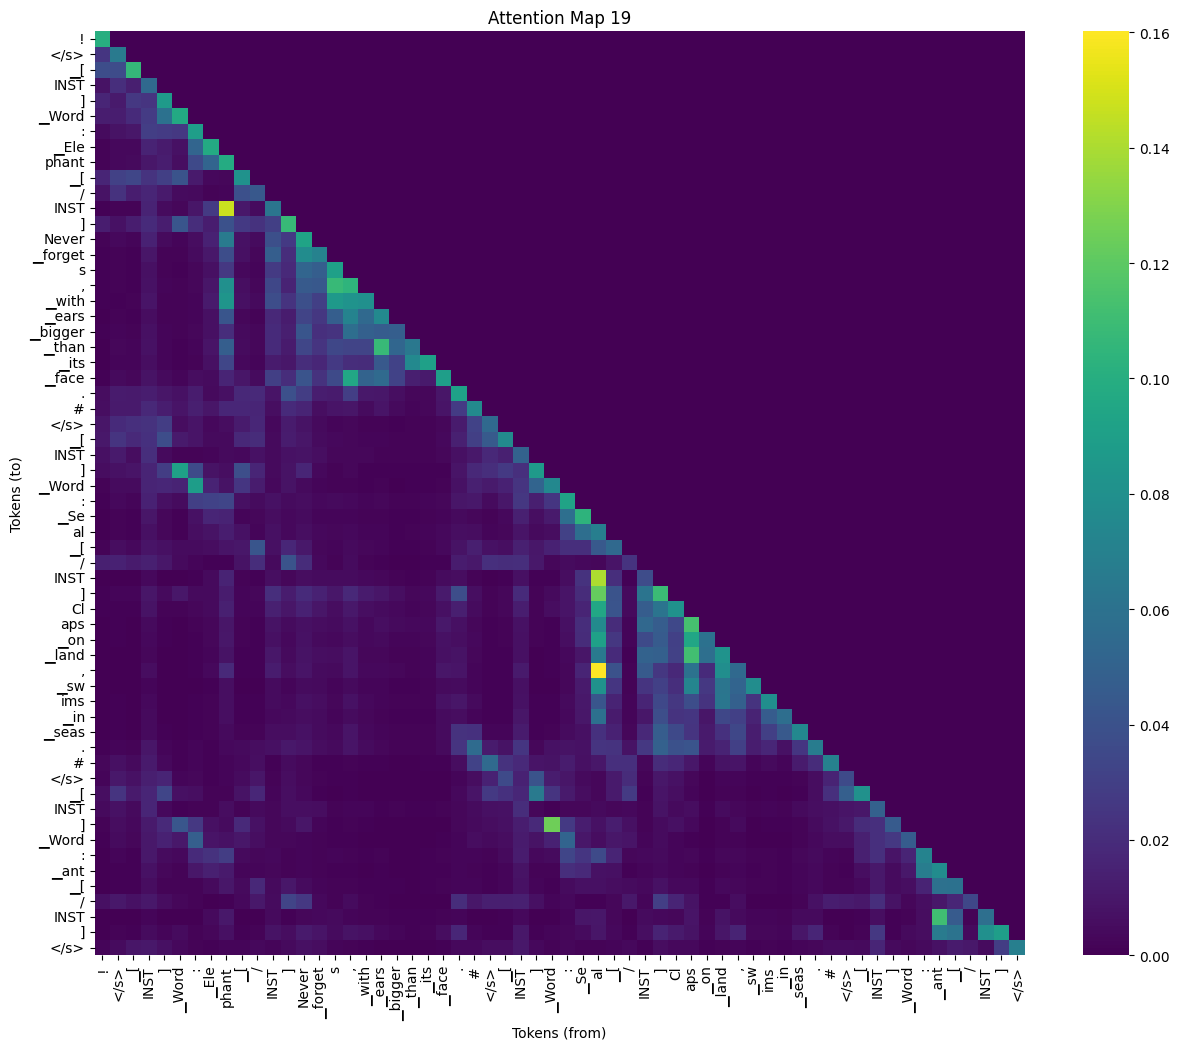

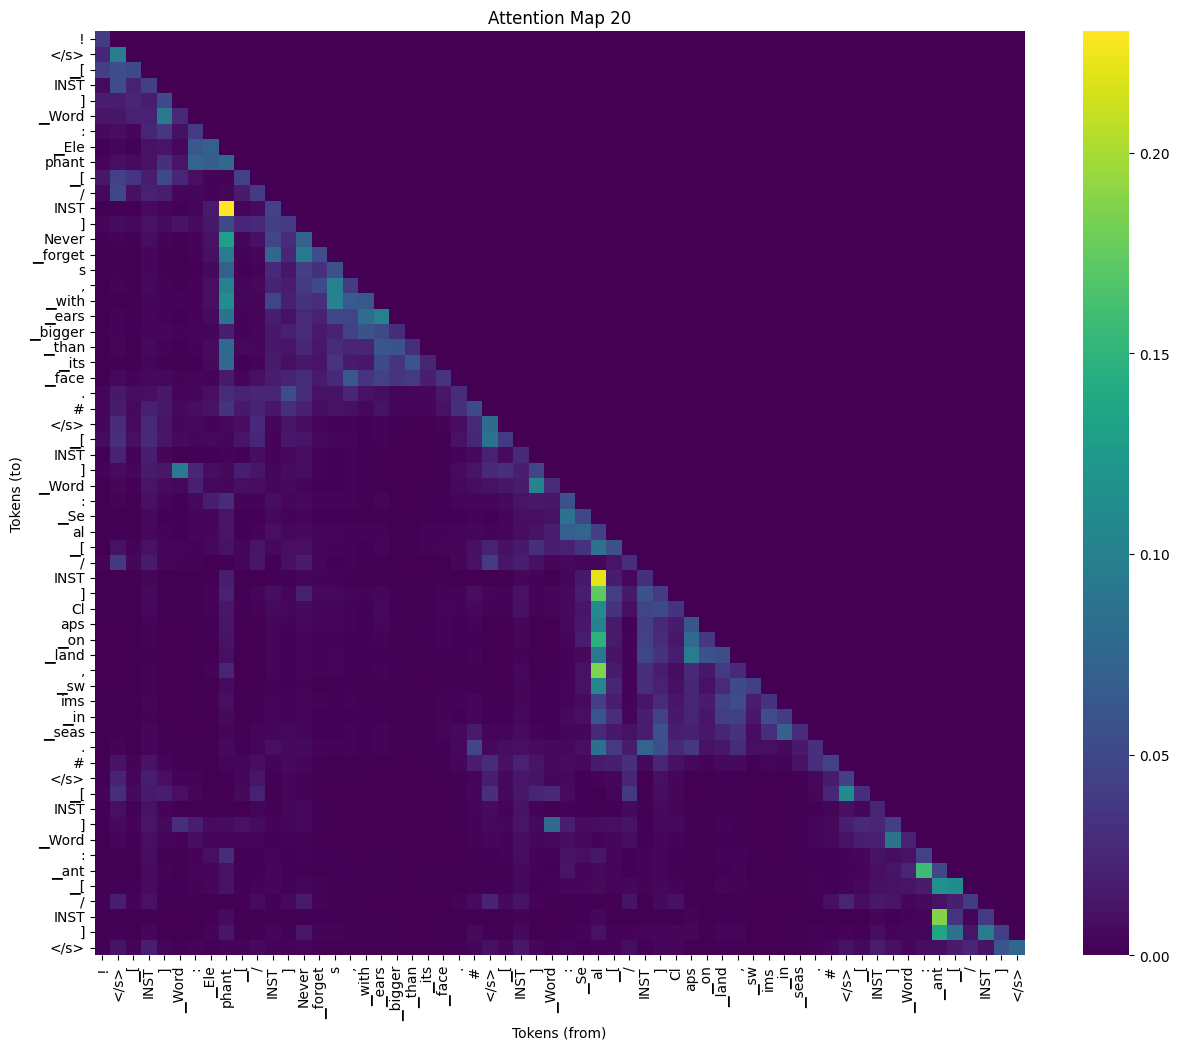

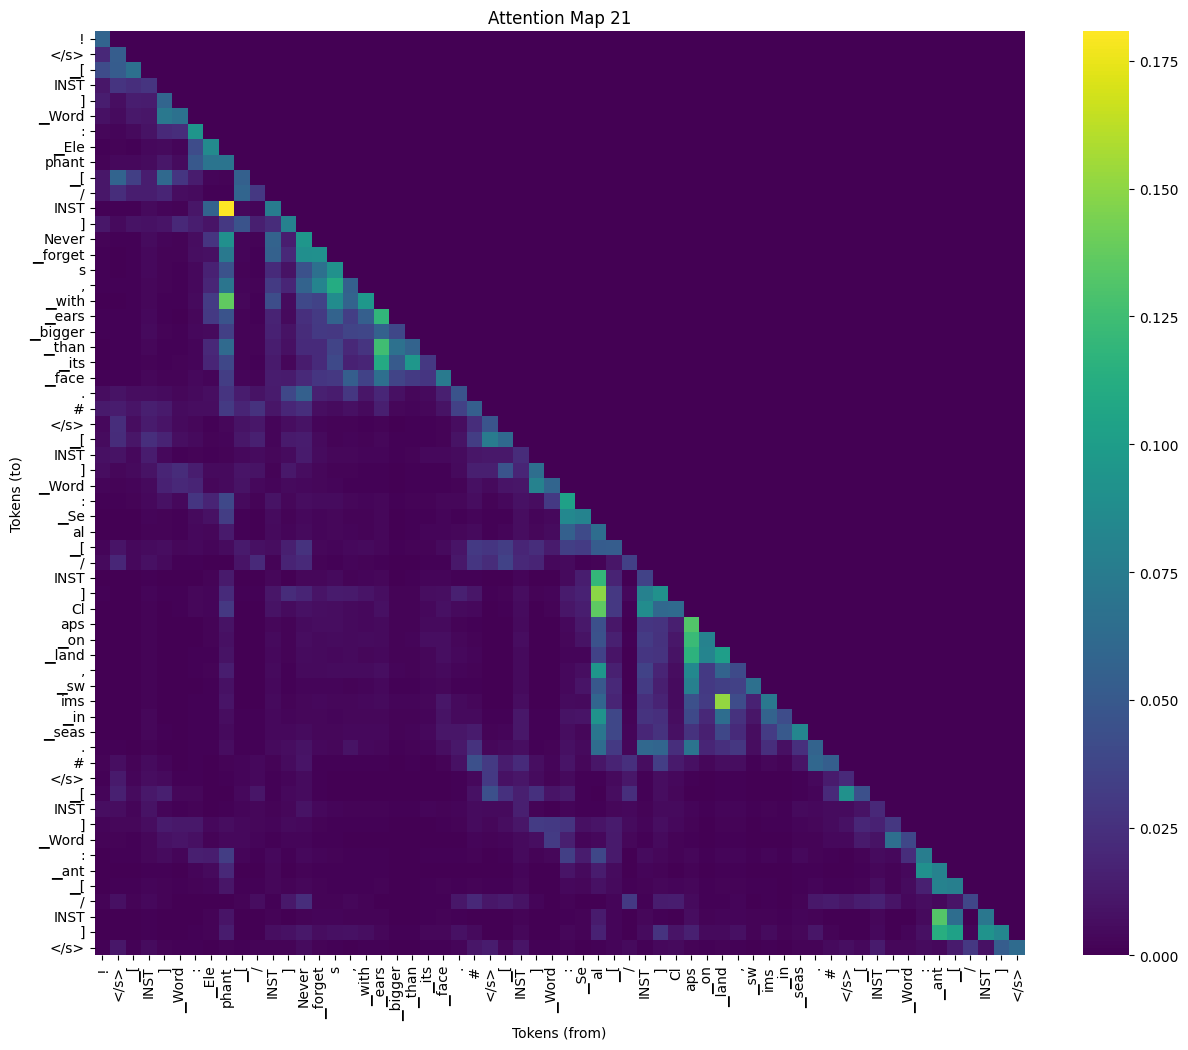

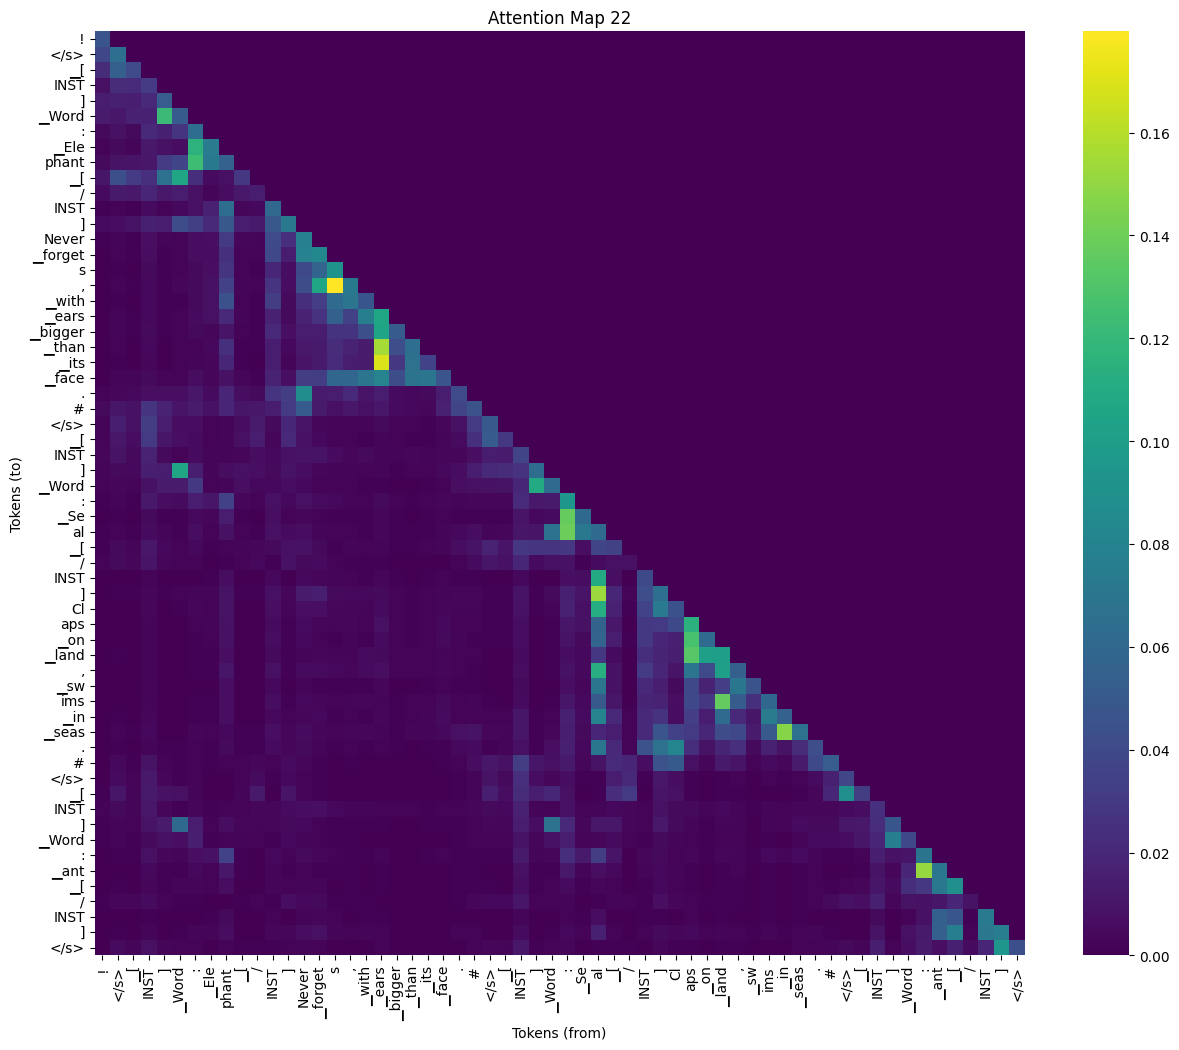

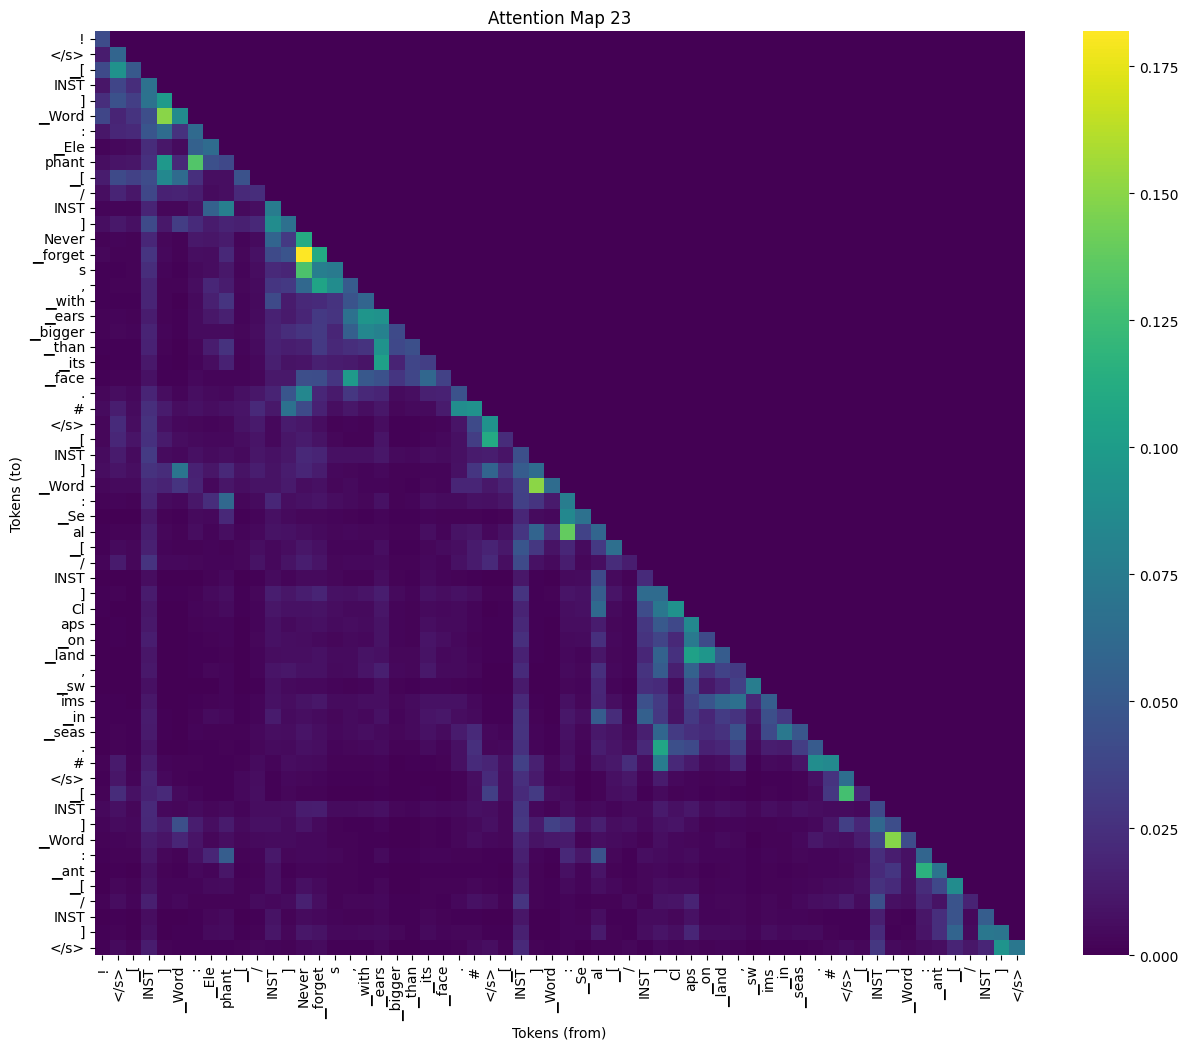

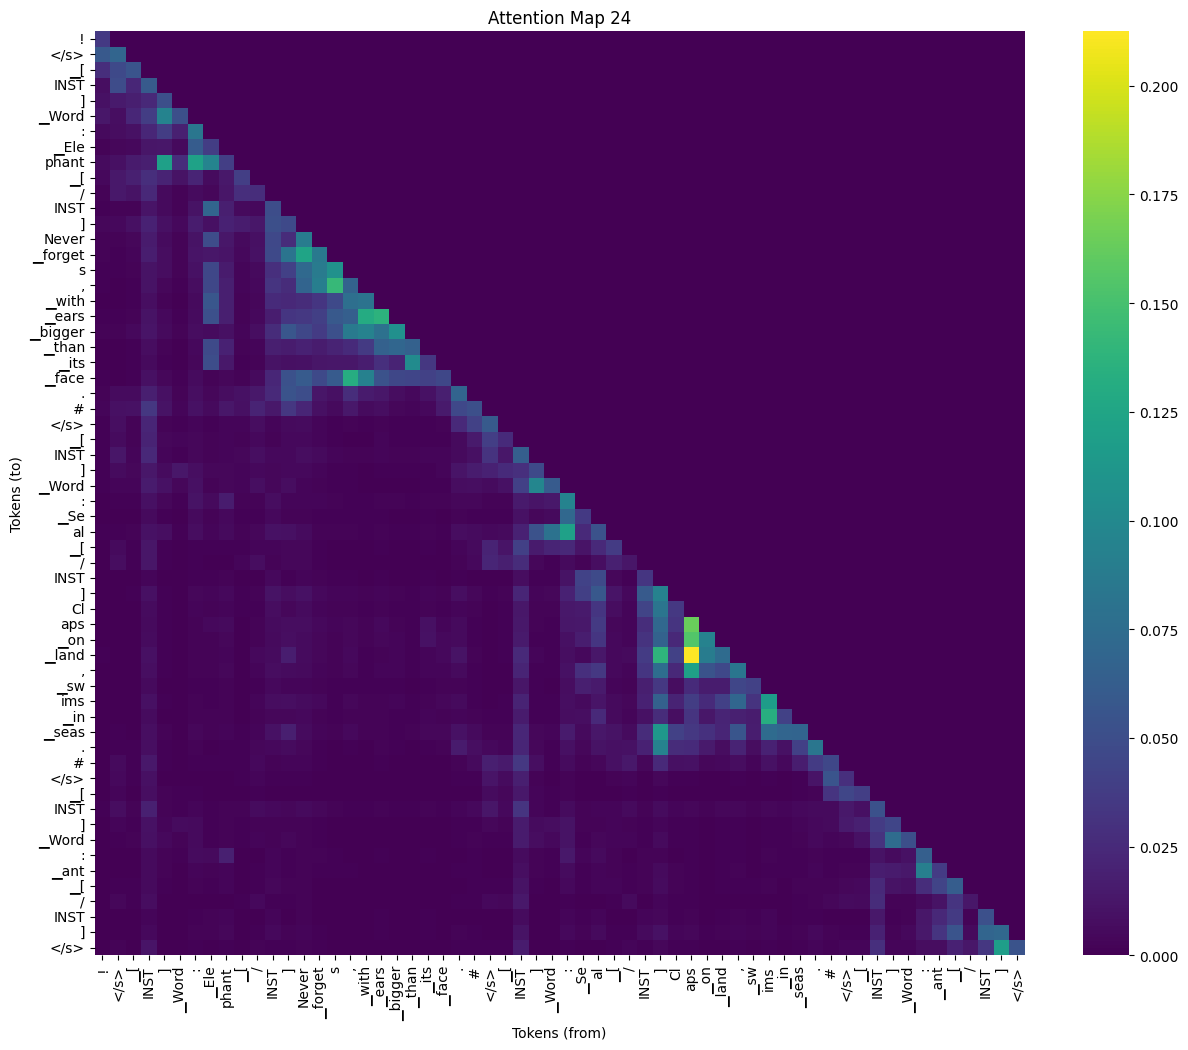

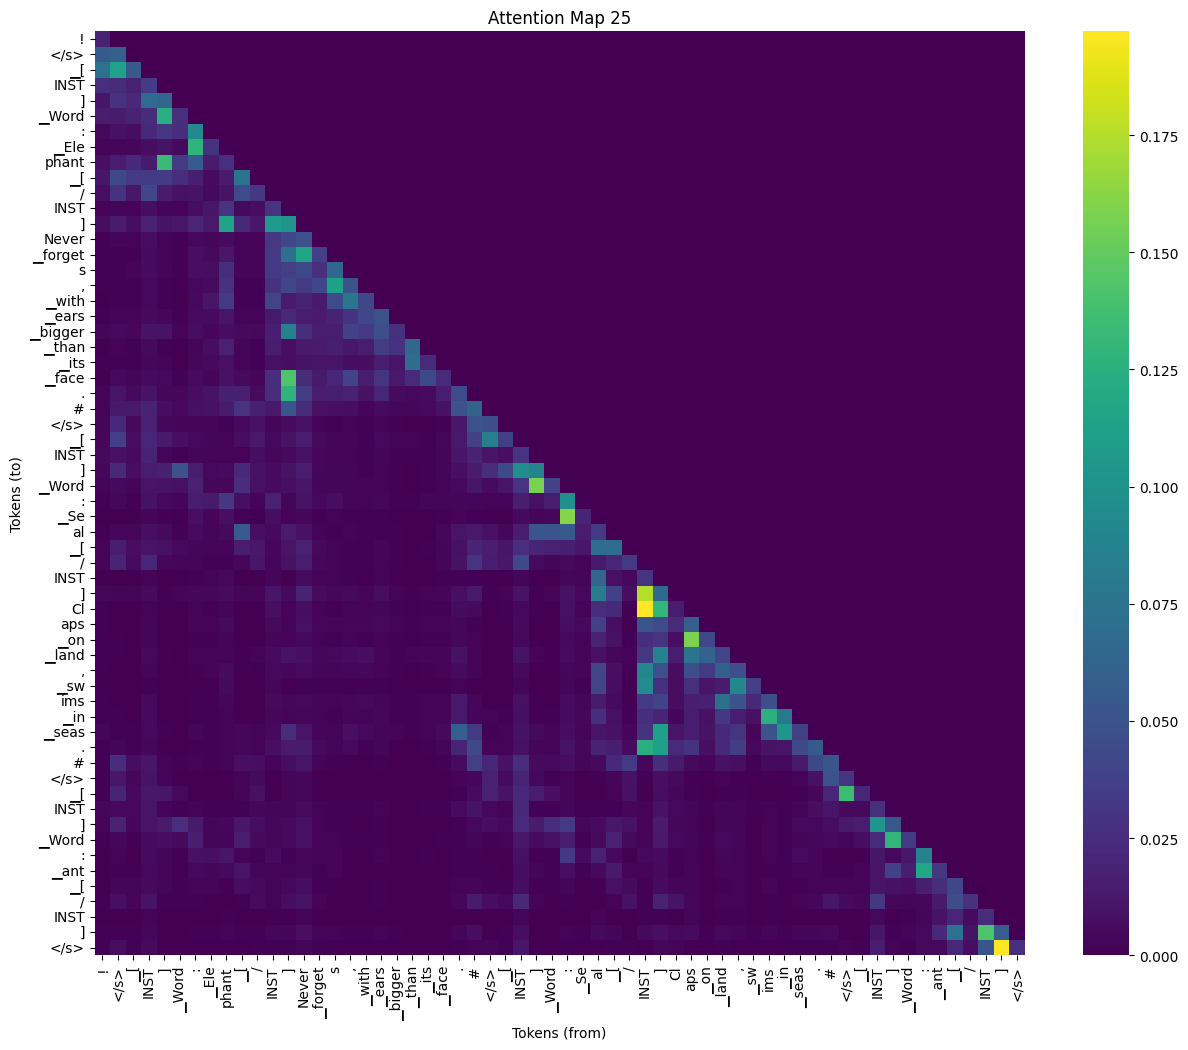

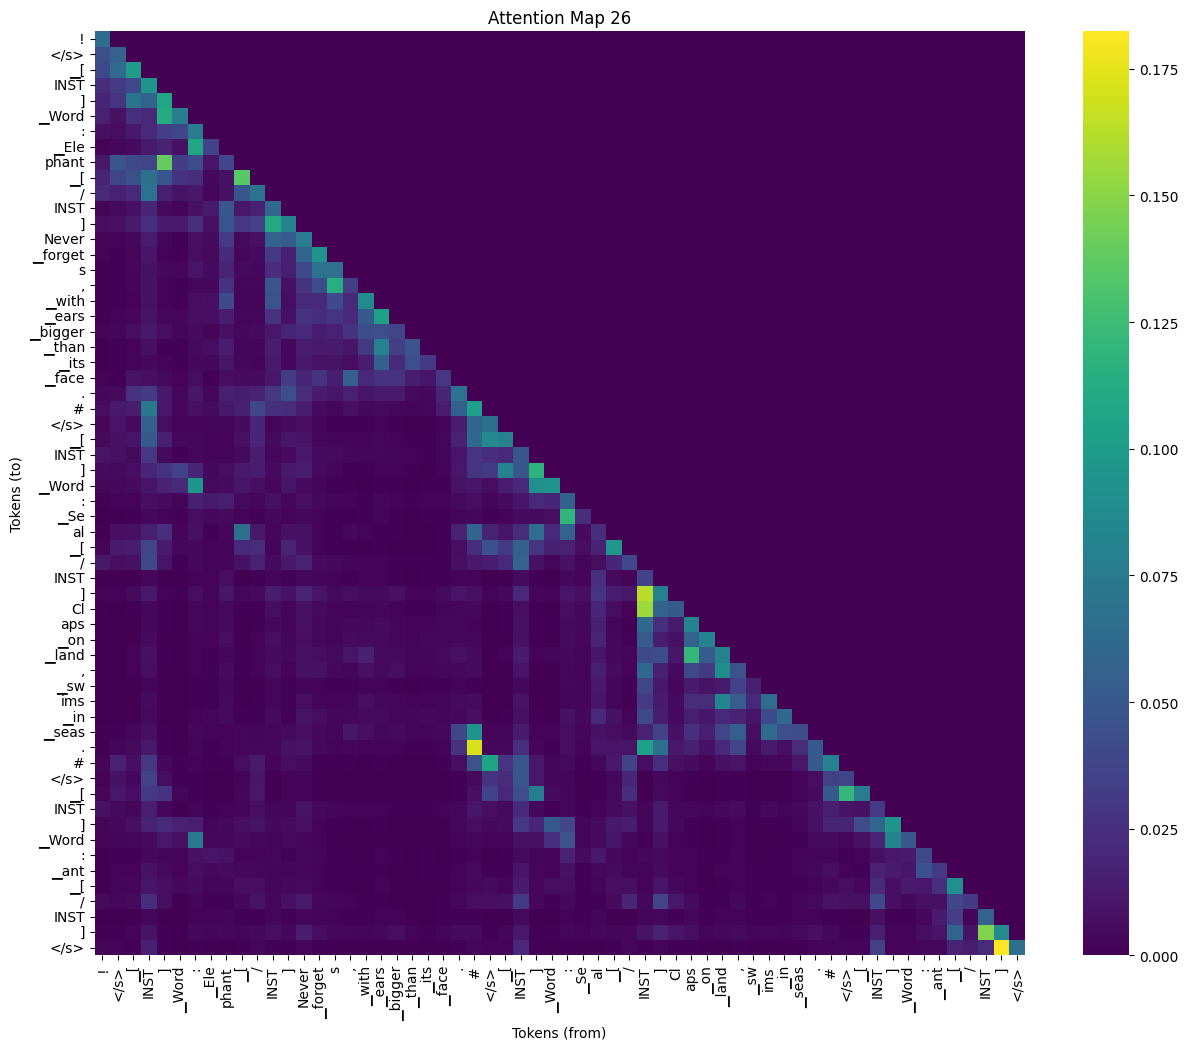

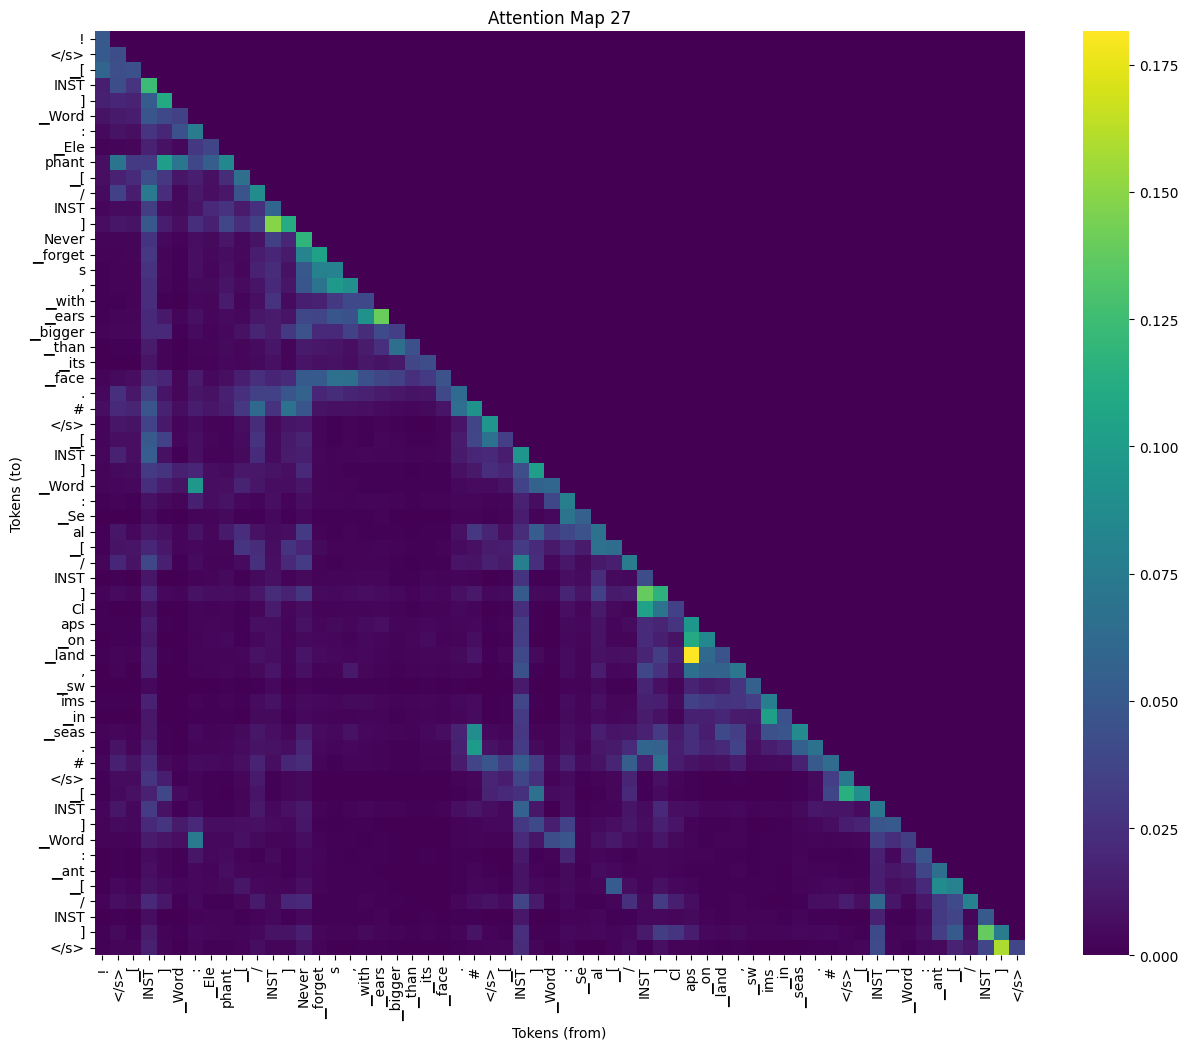

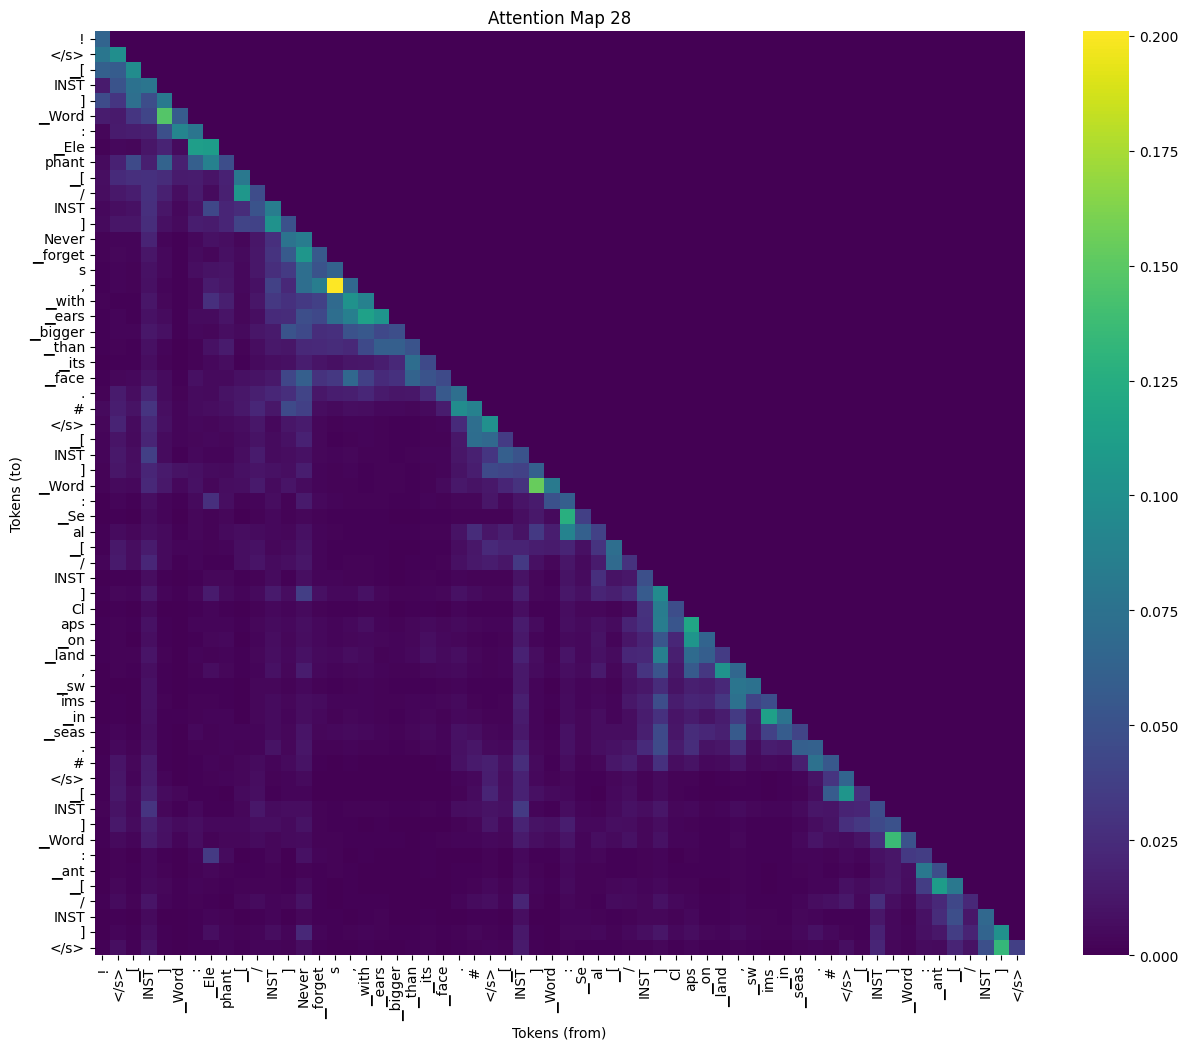

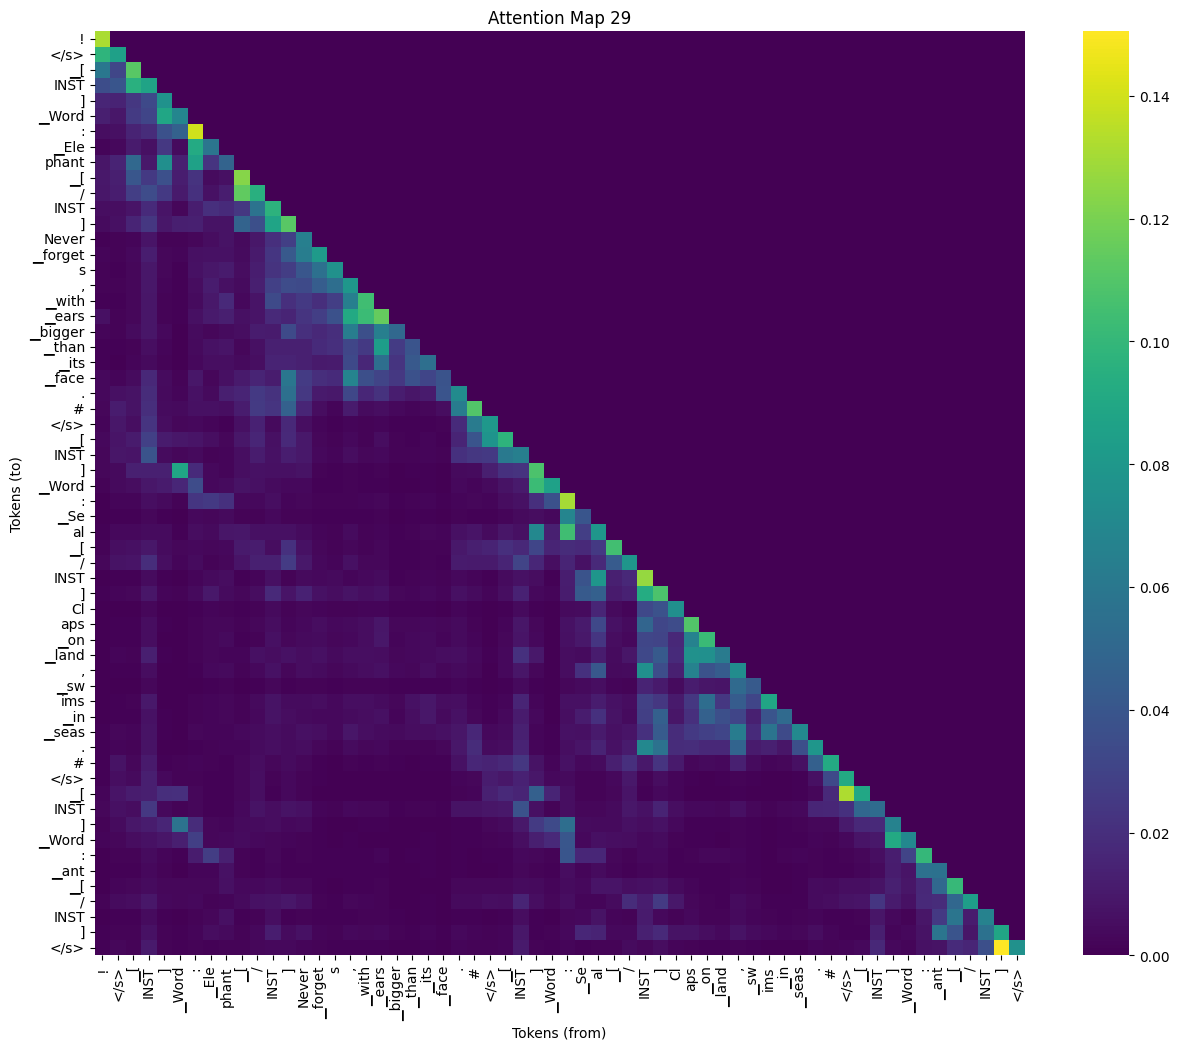

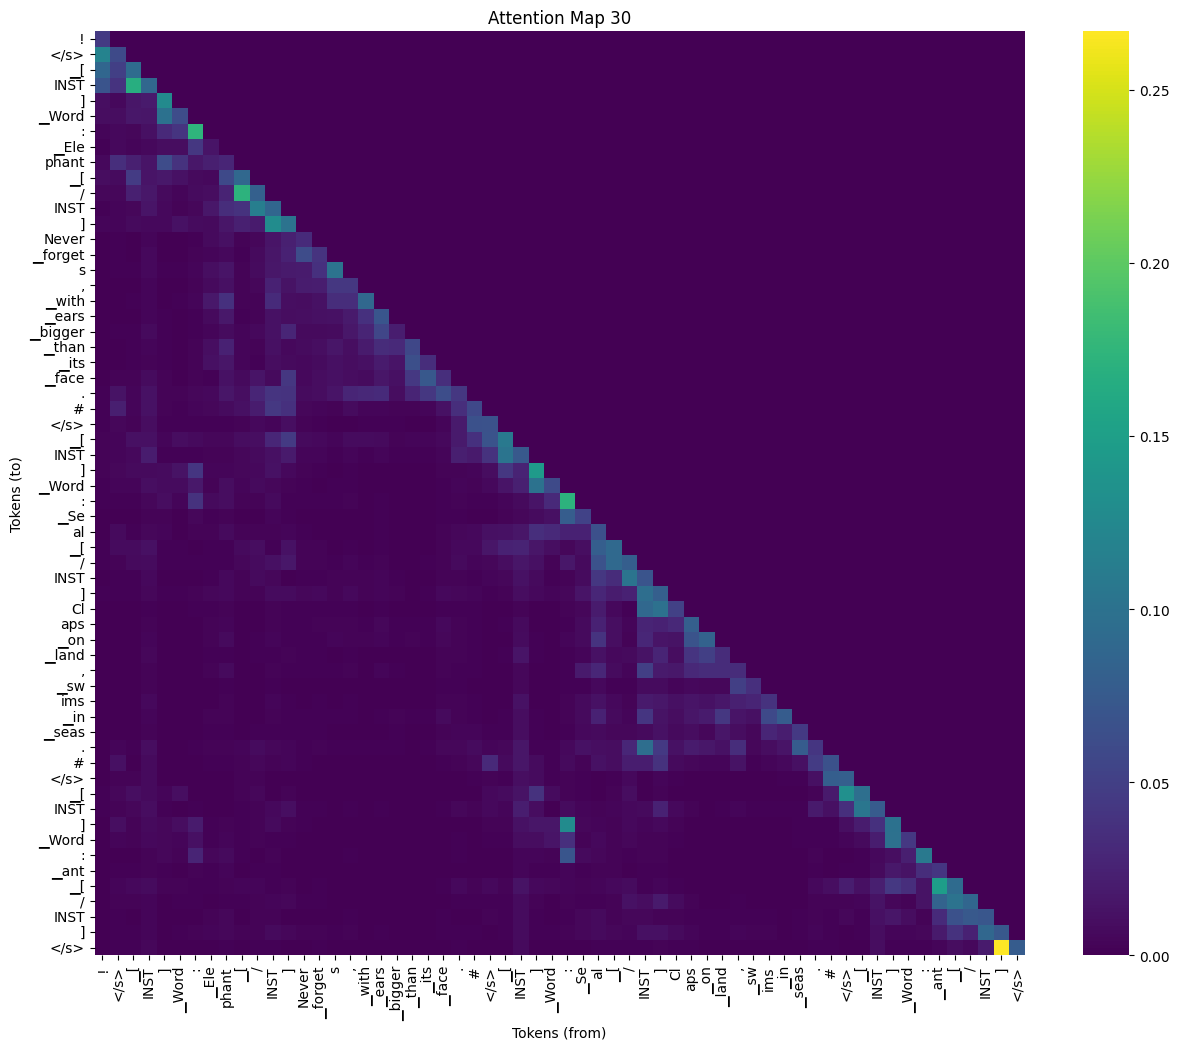

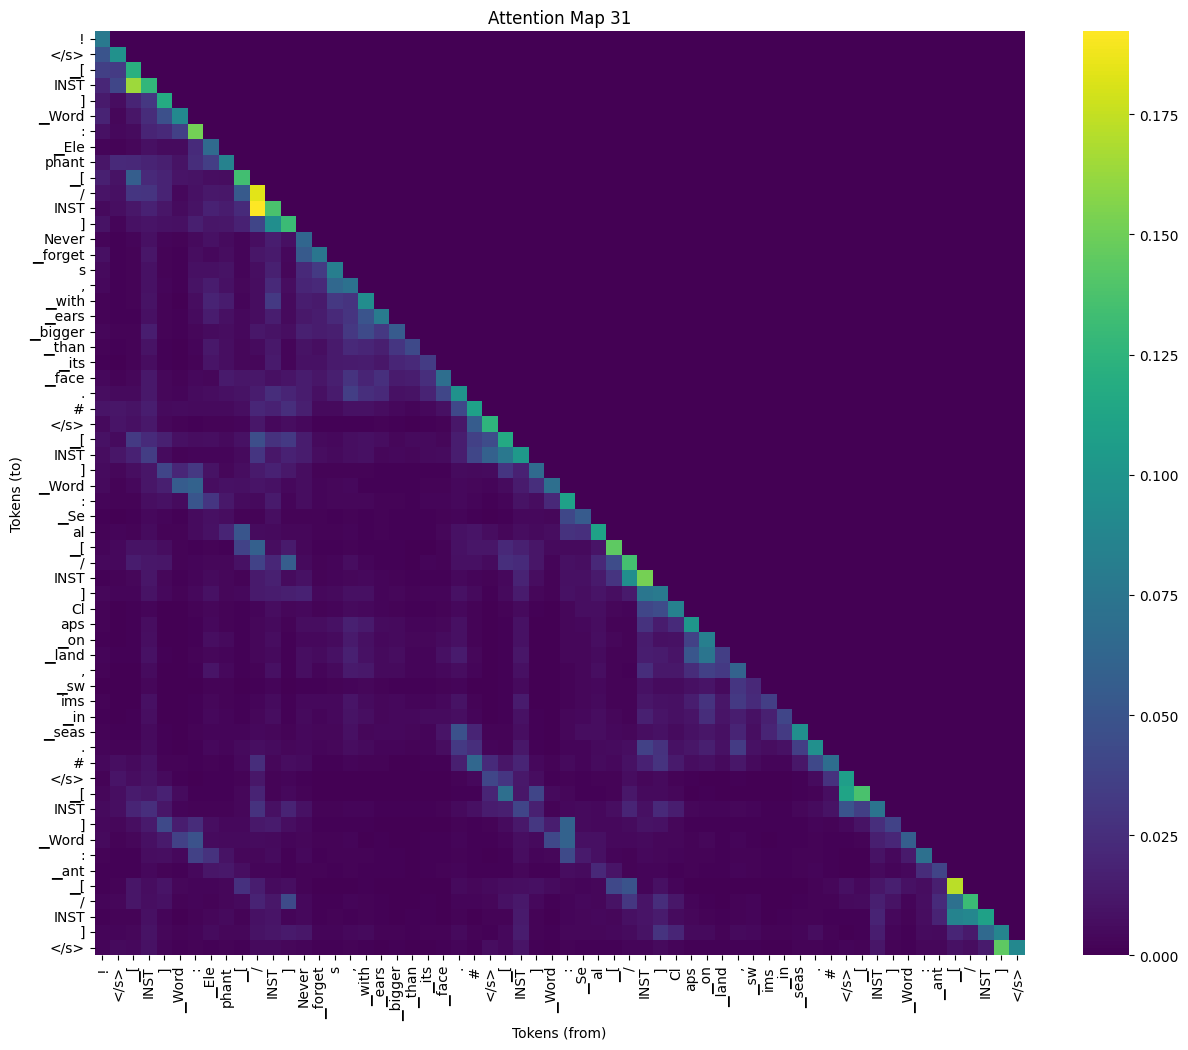

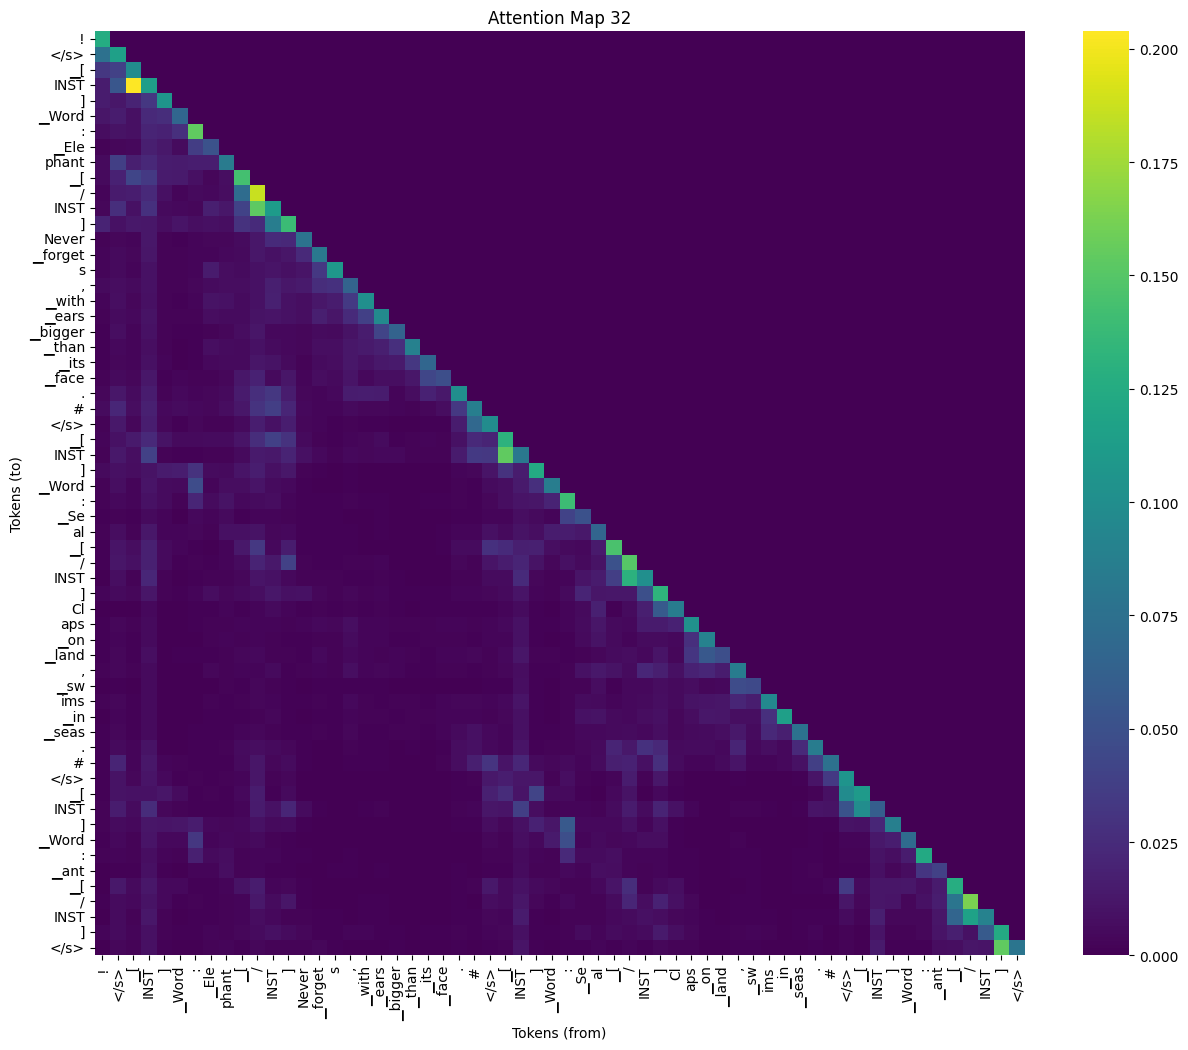

Layer 12


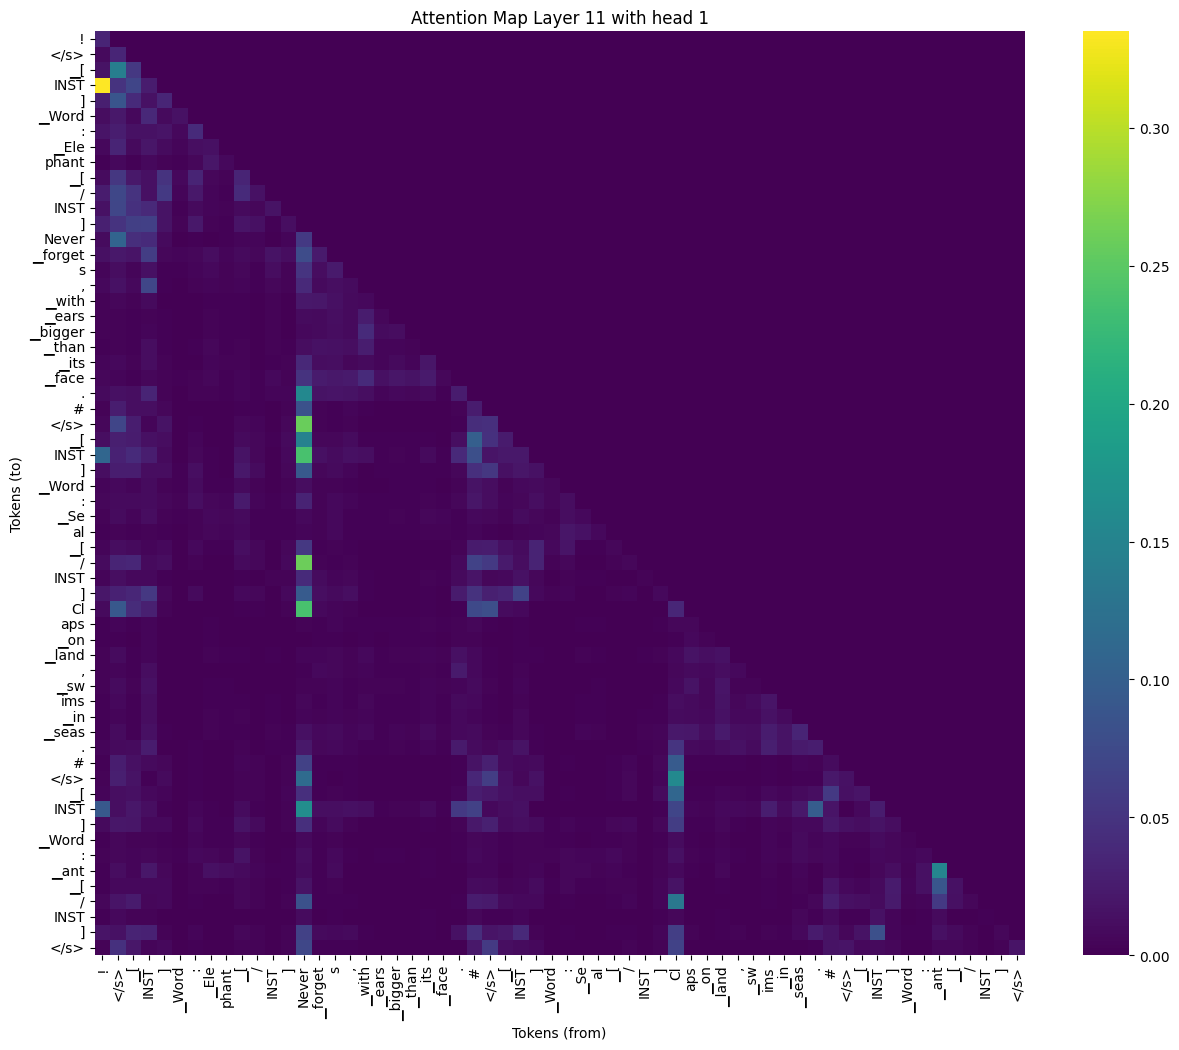

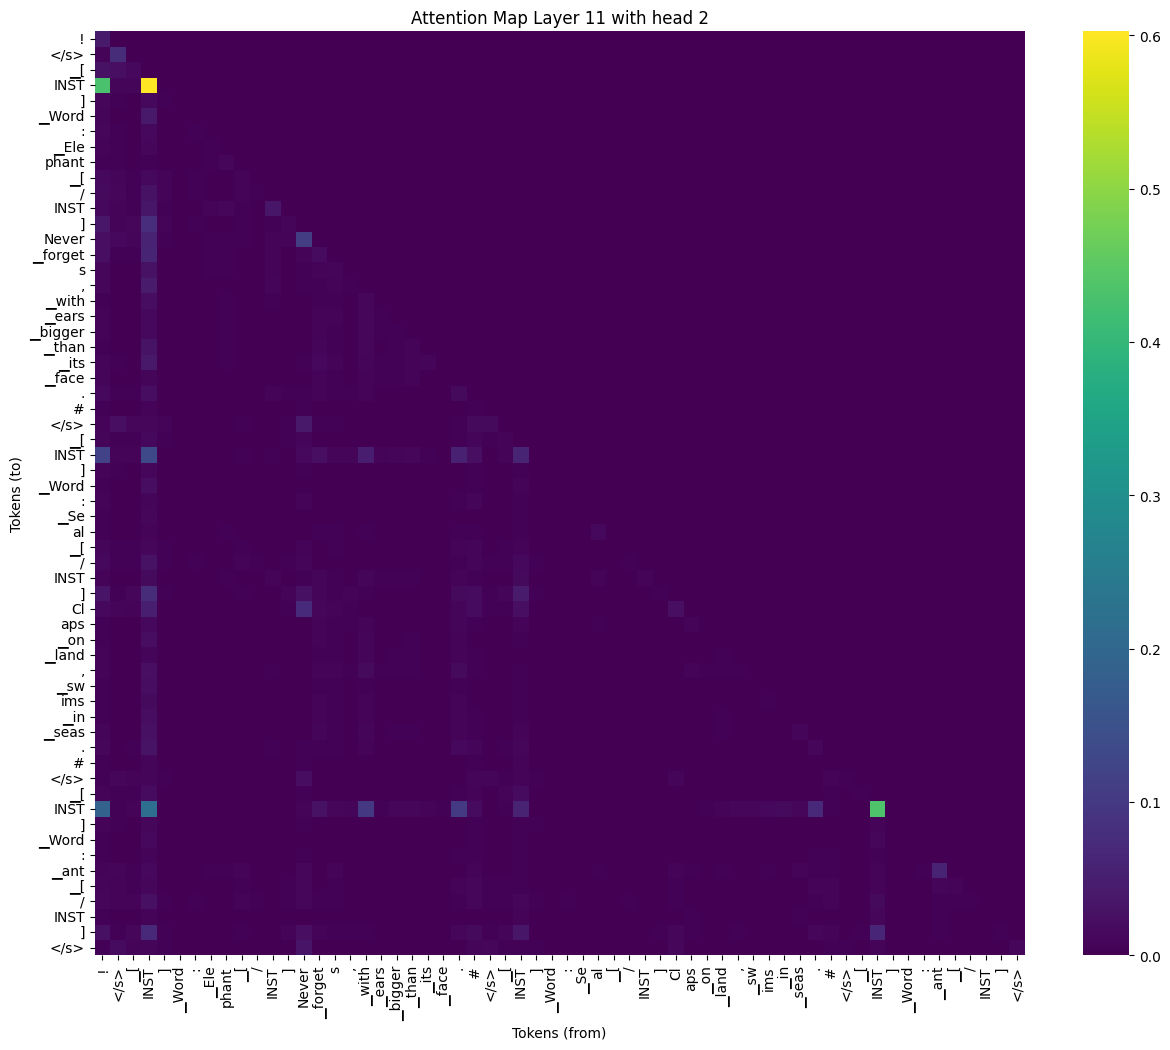

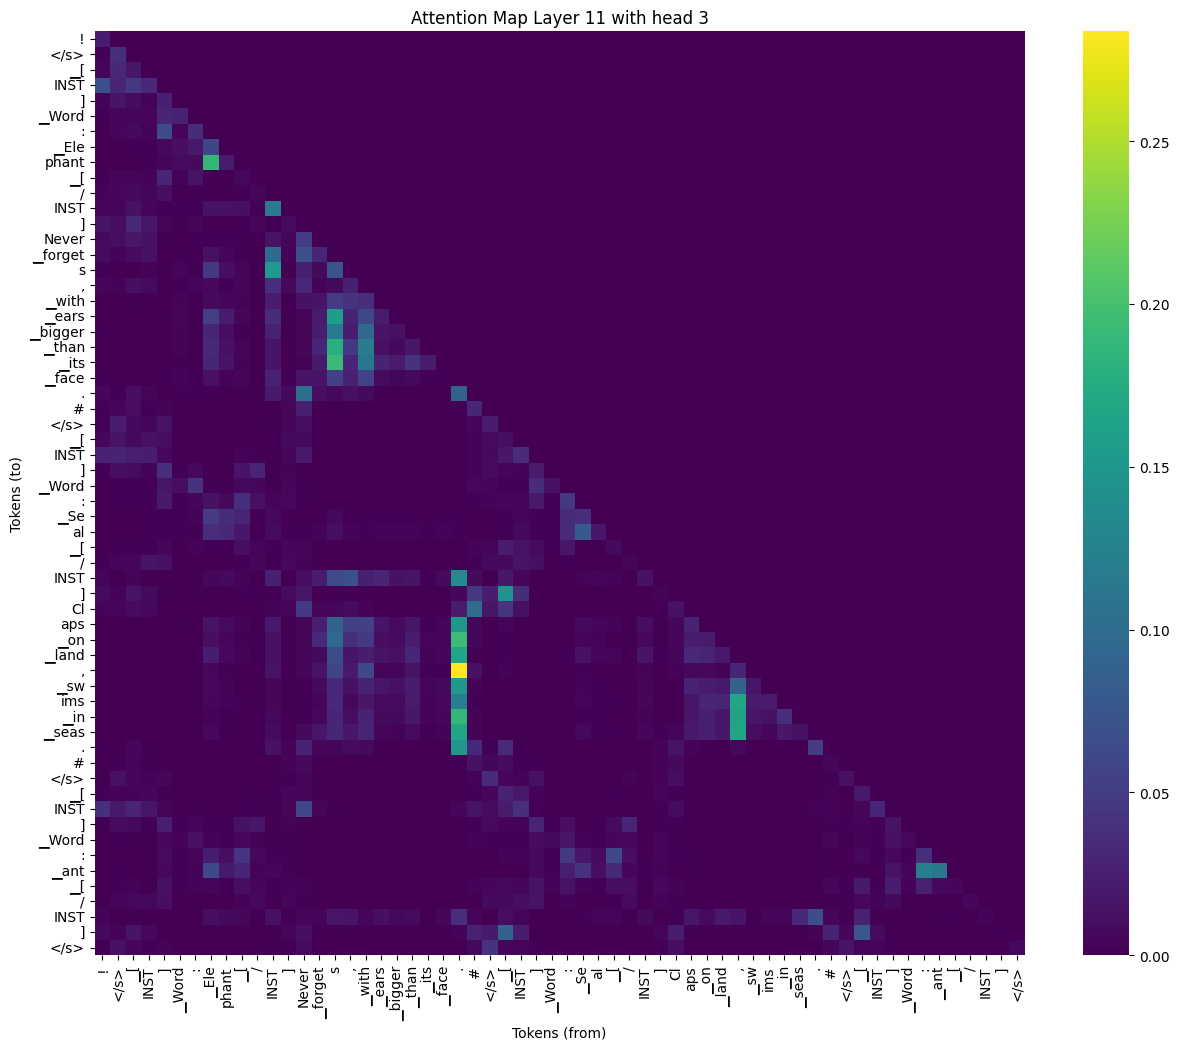

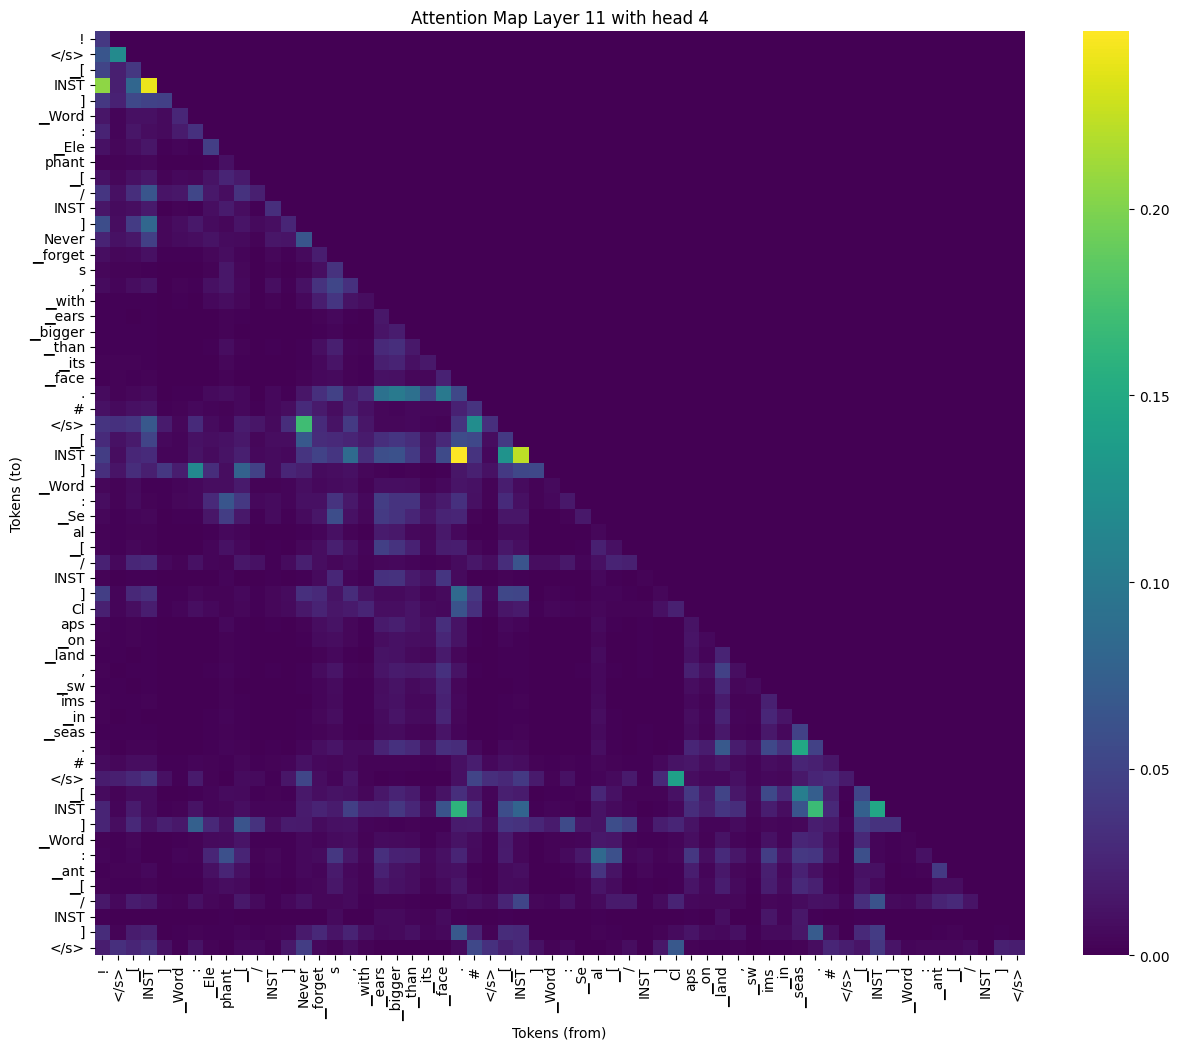

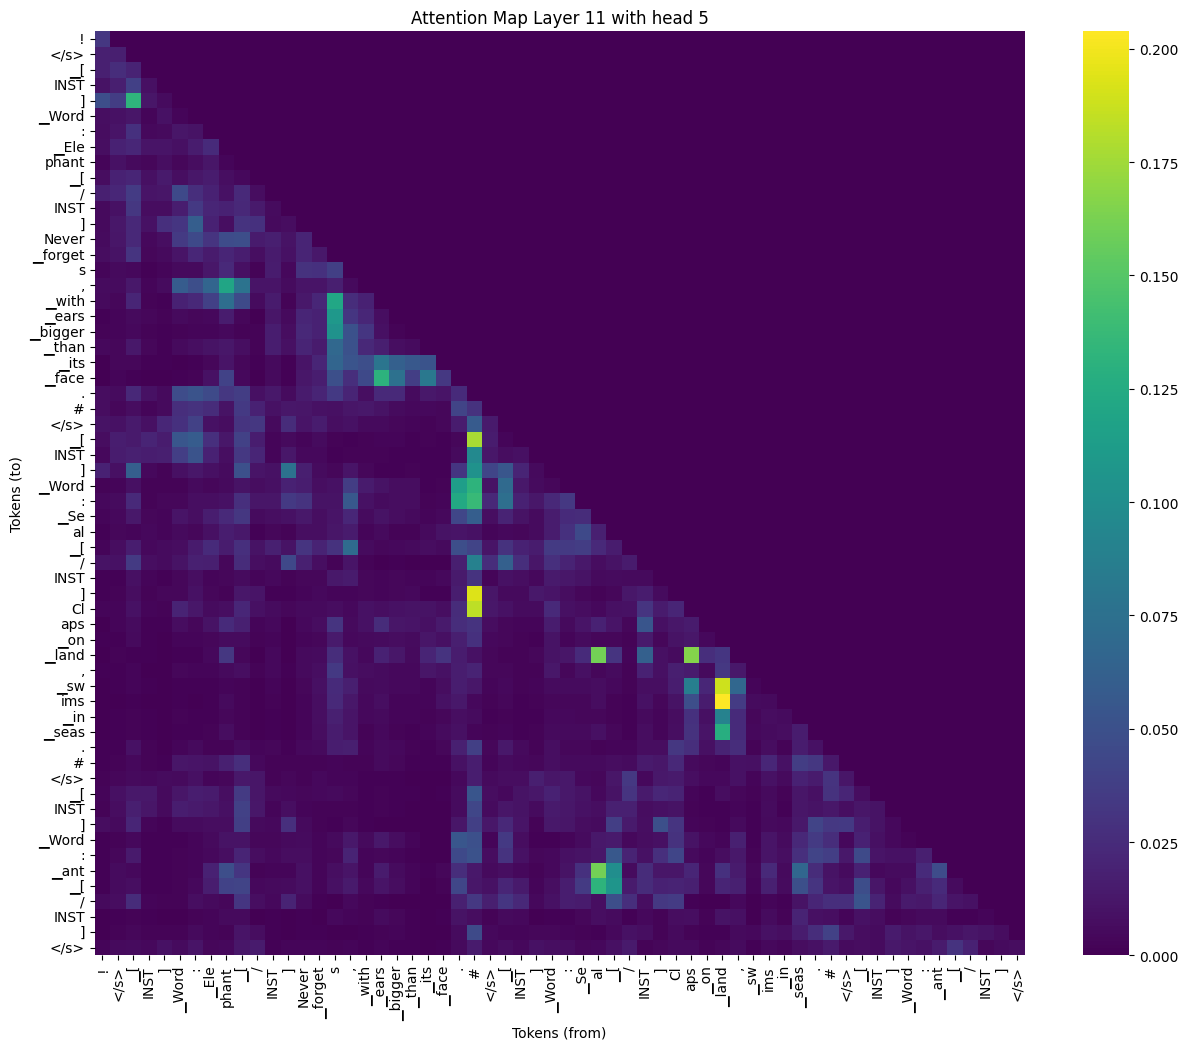

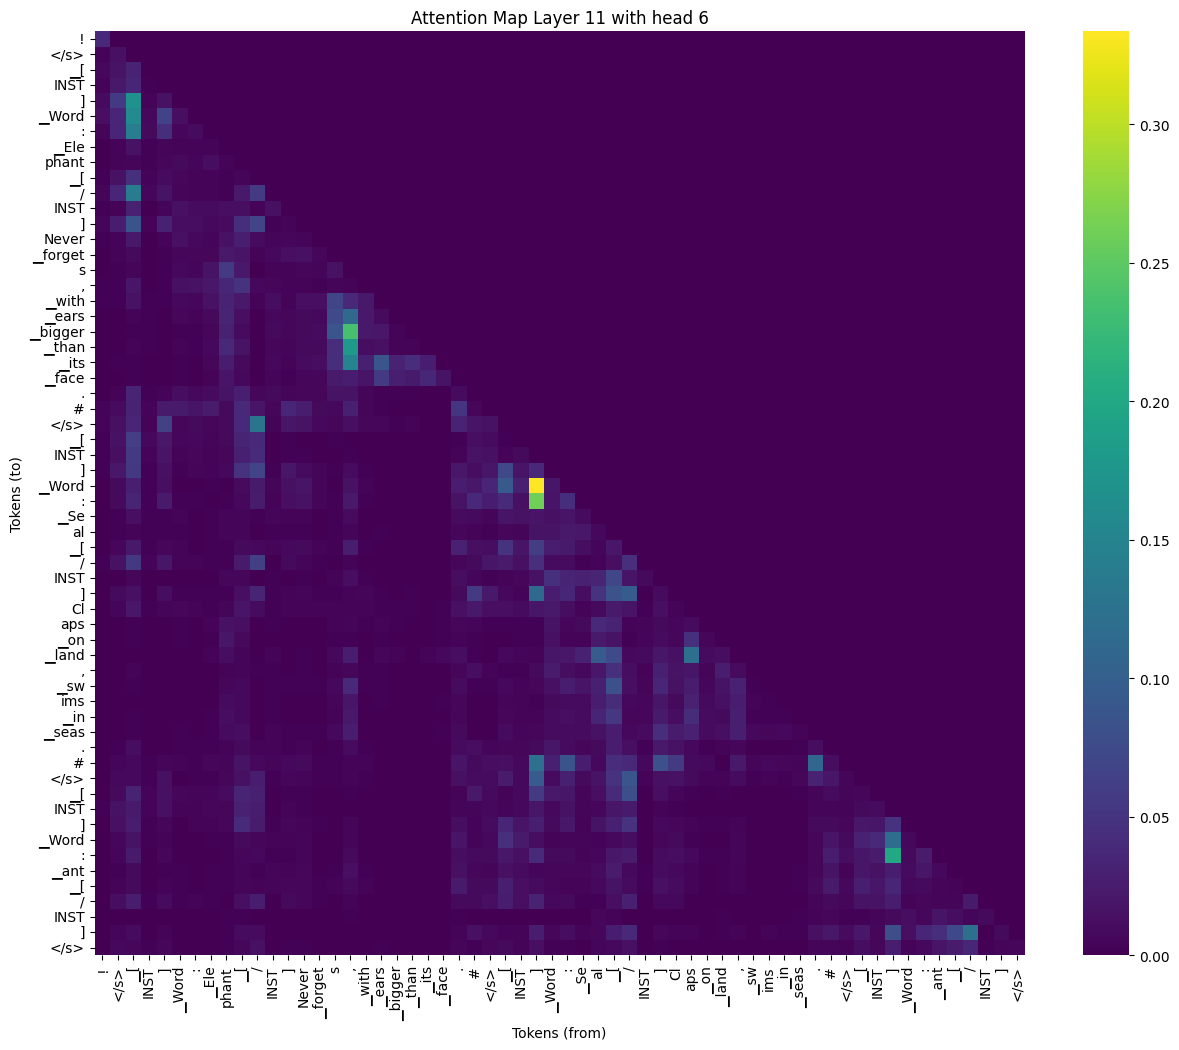

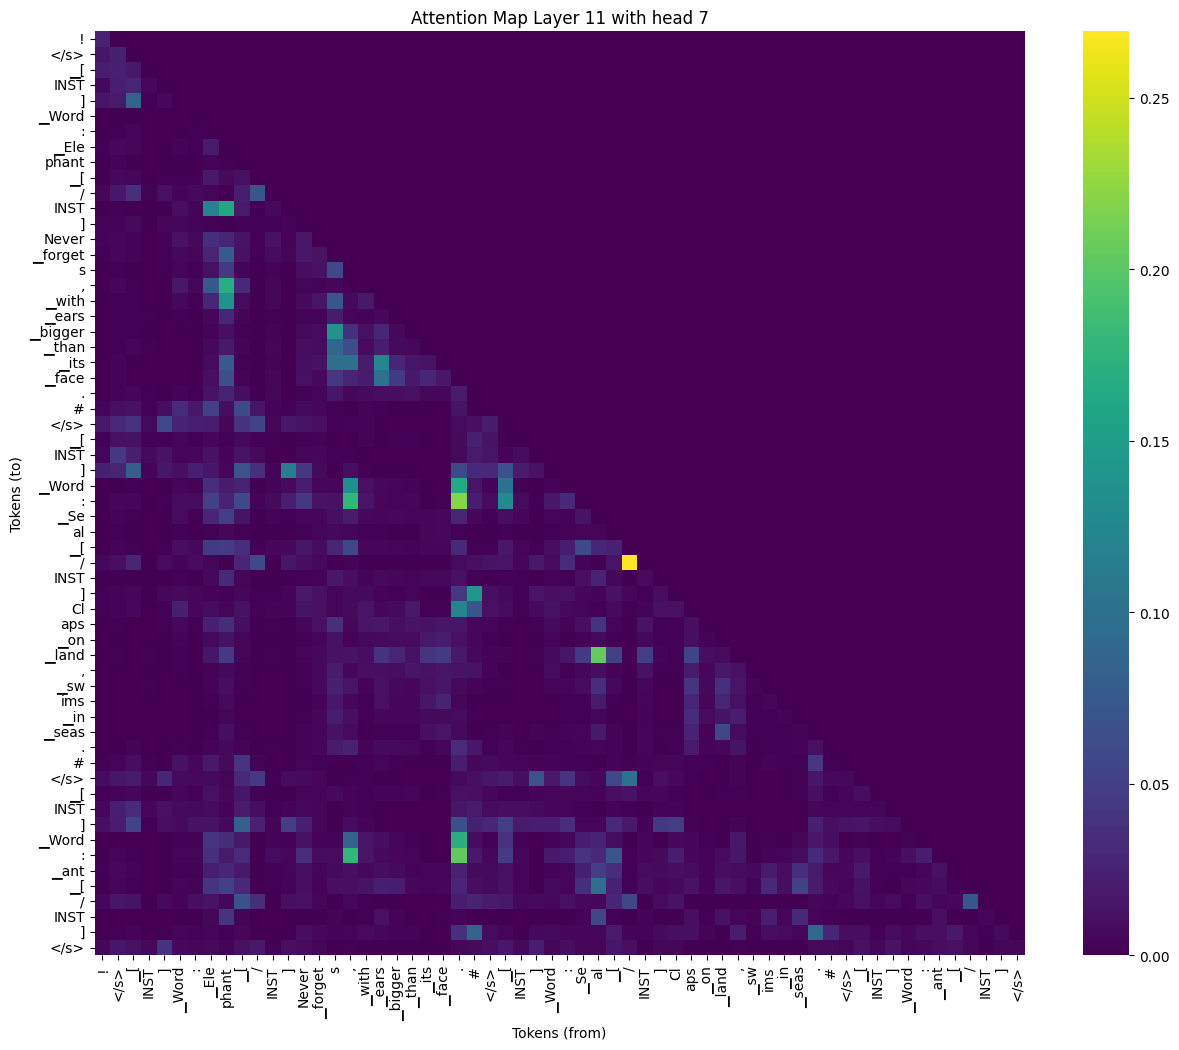

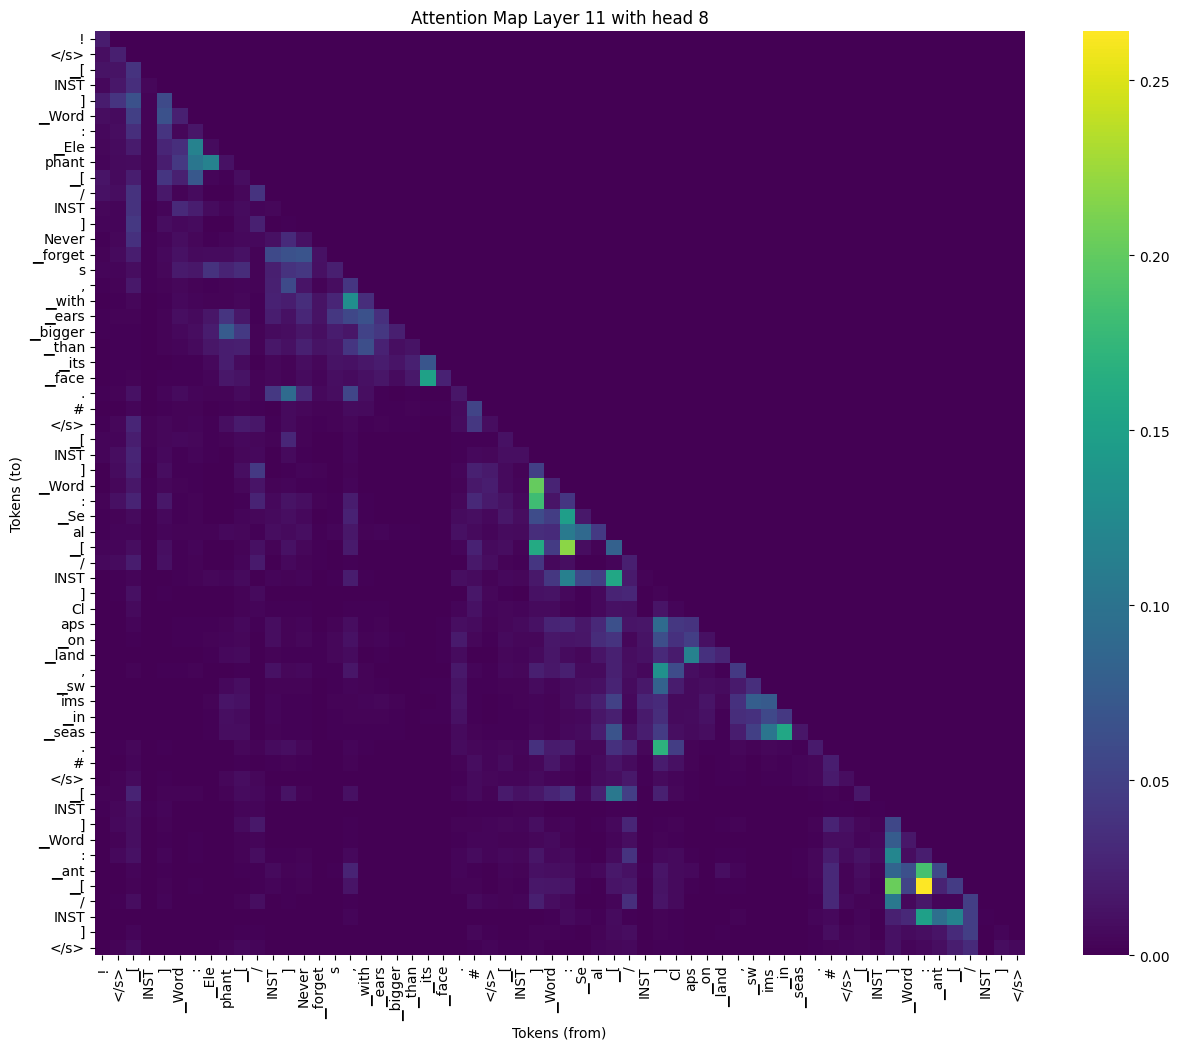

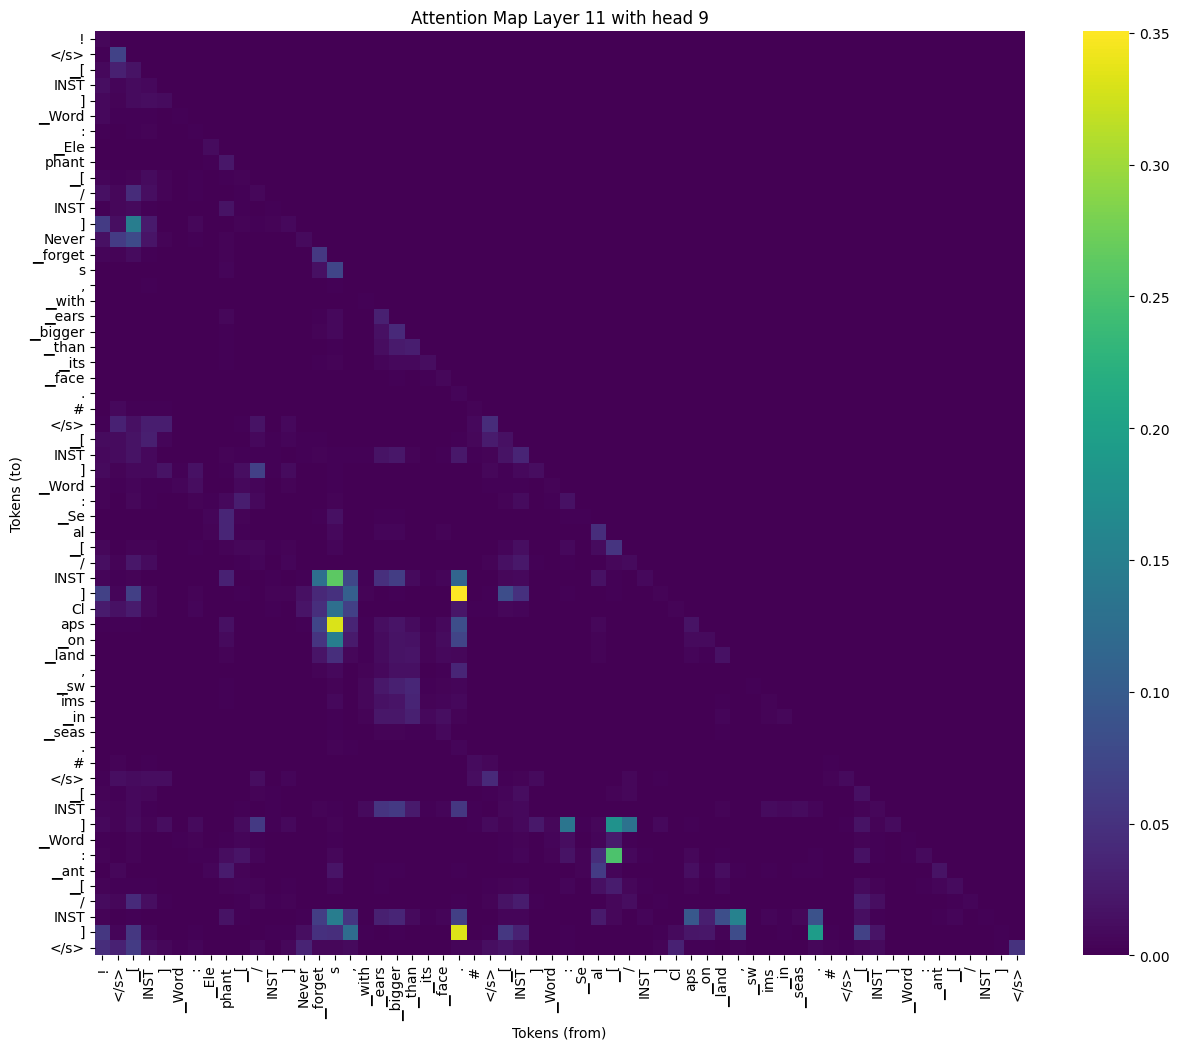

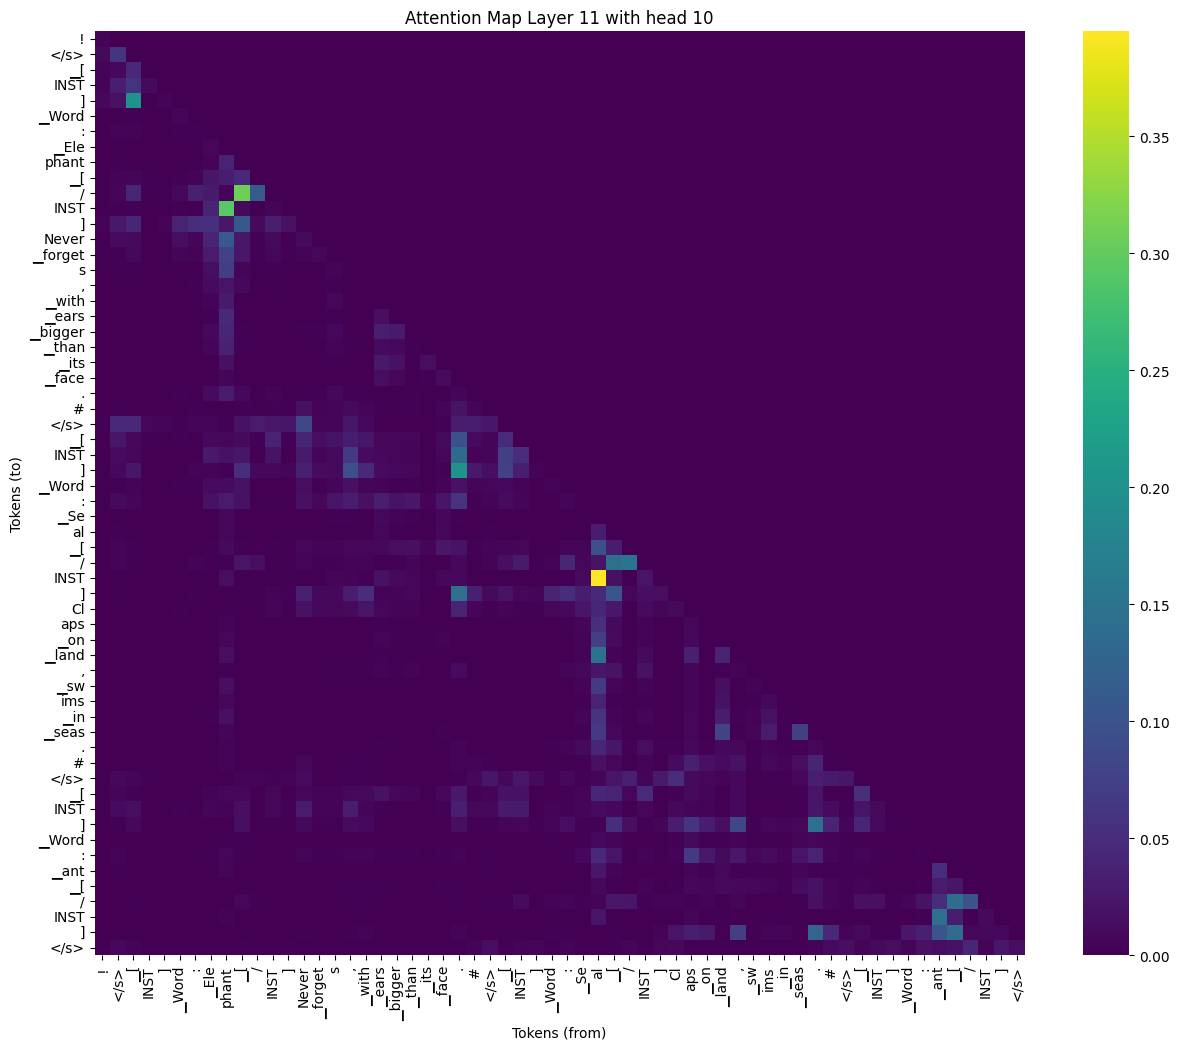

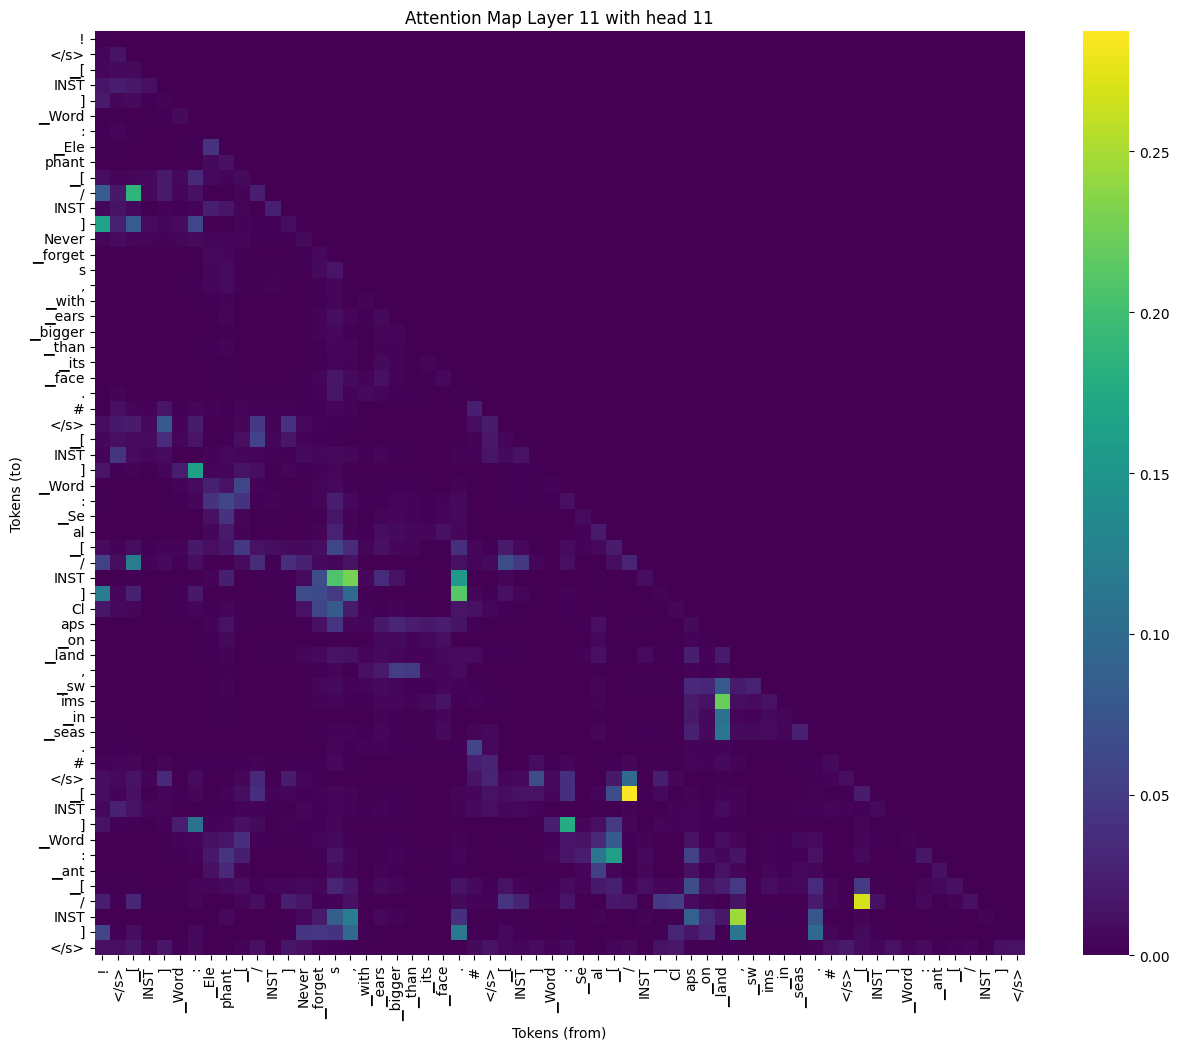

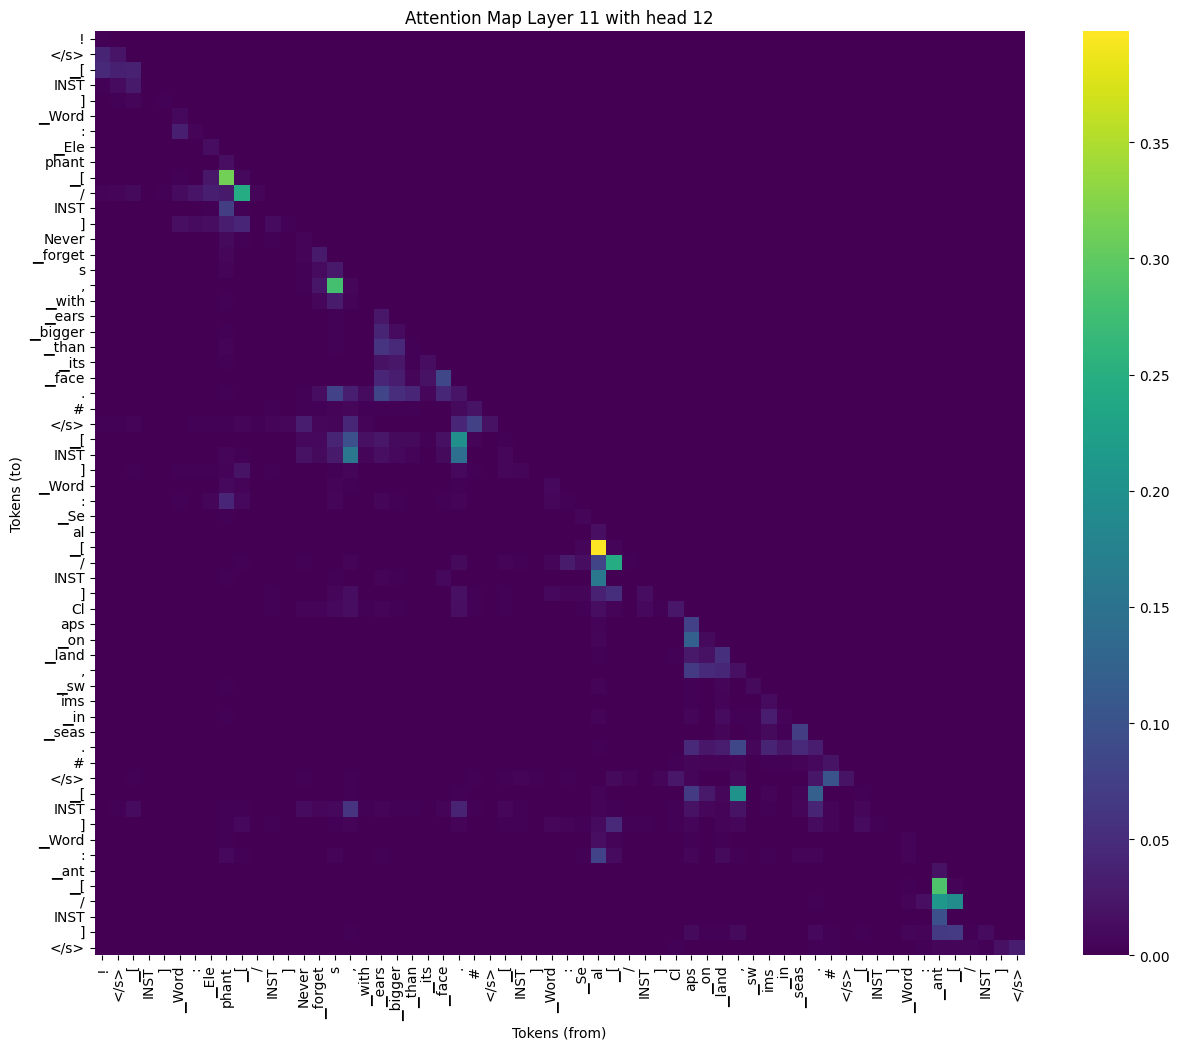

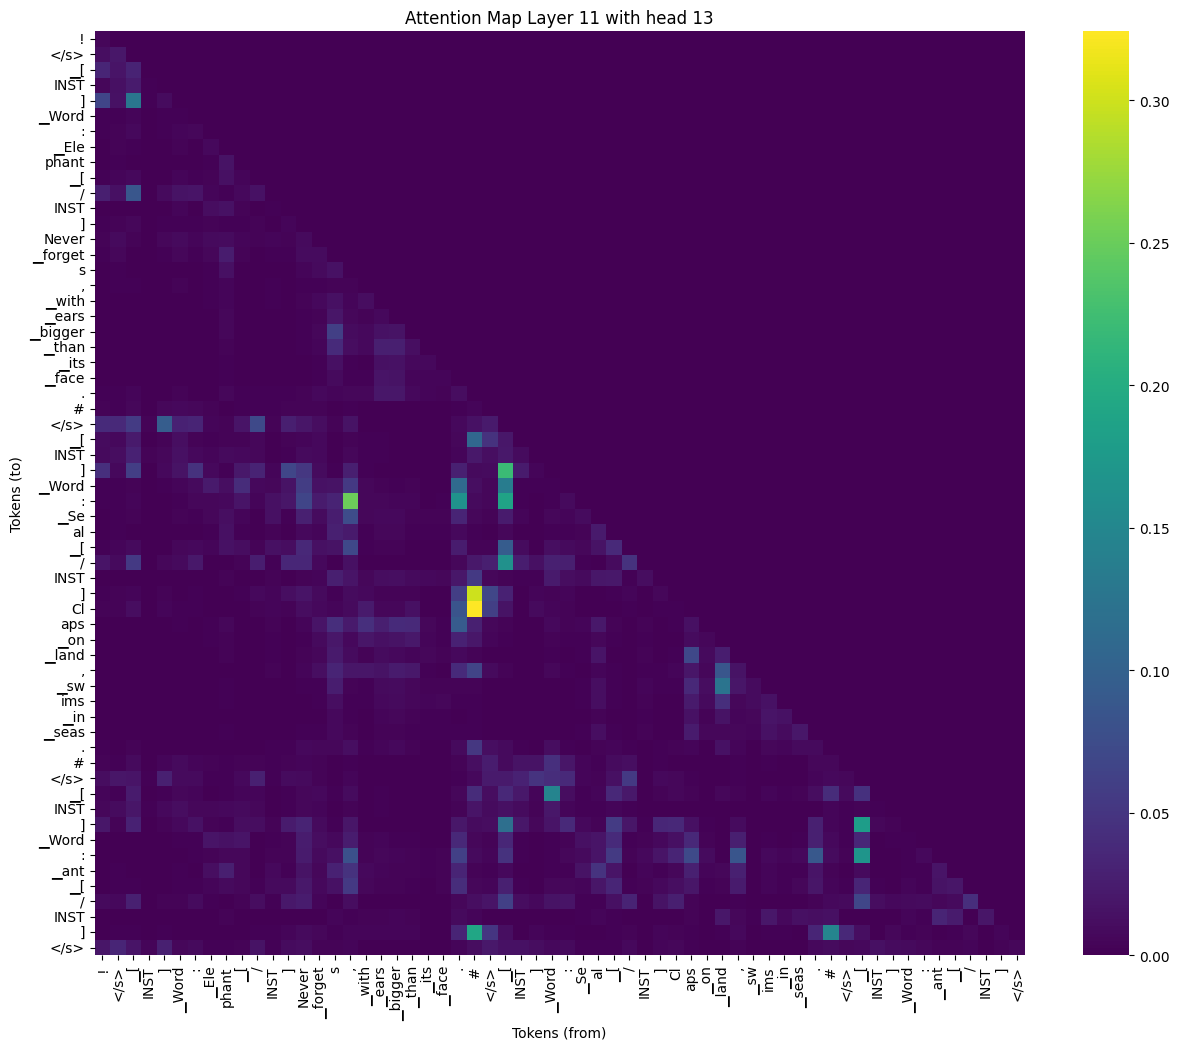

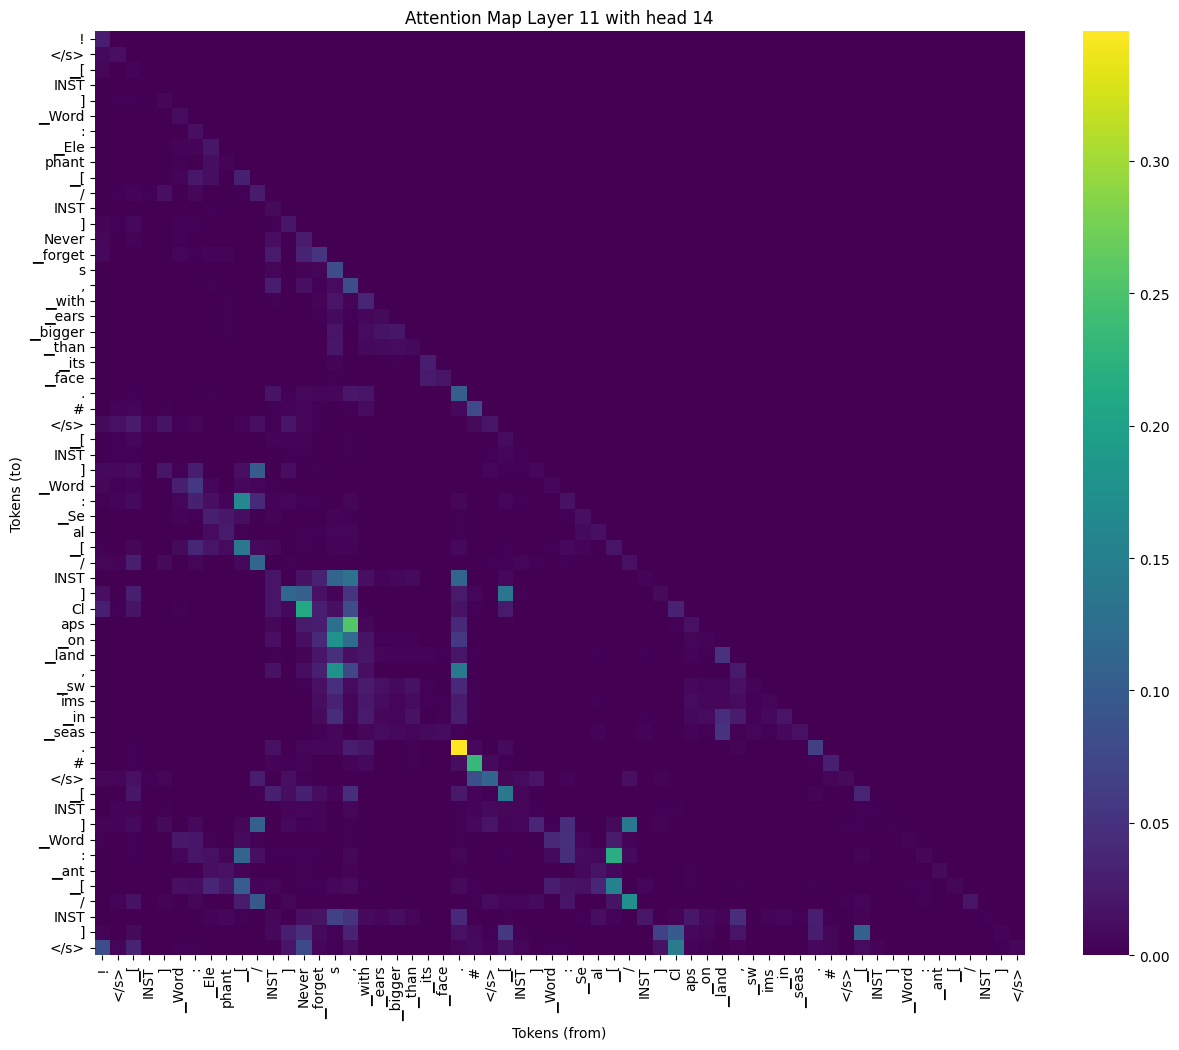

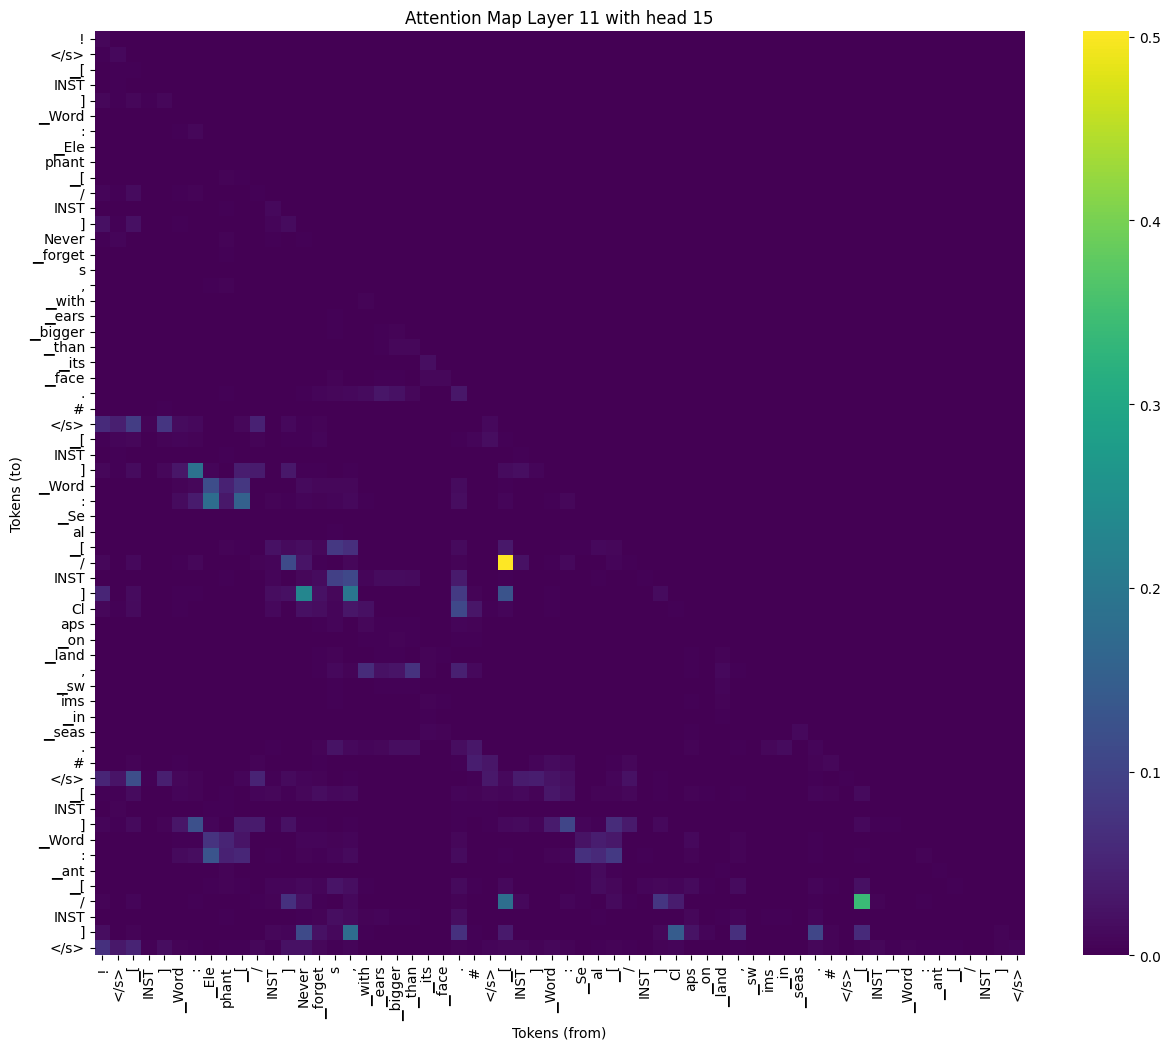

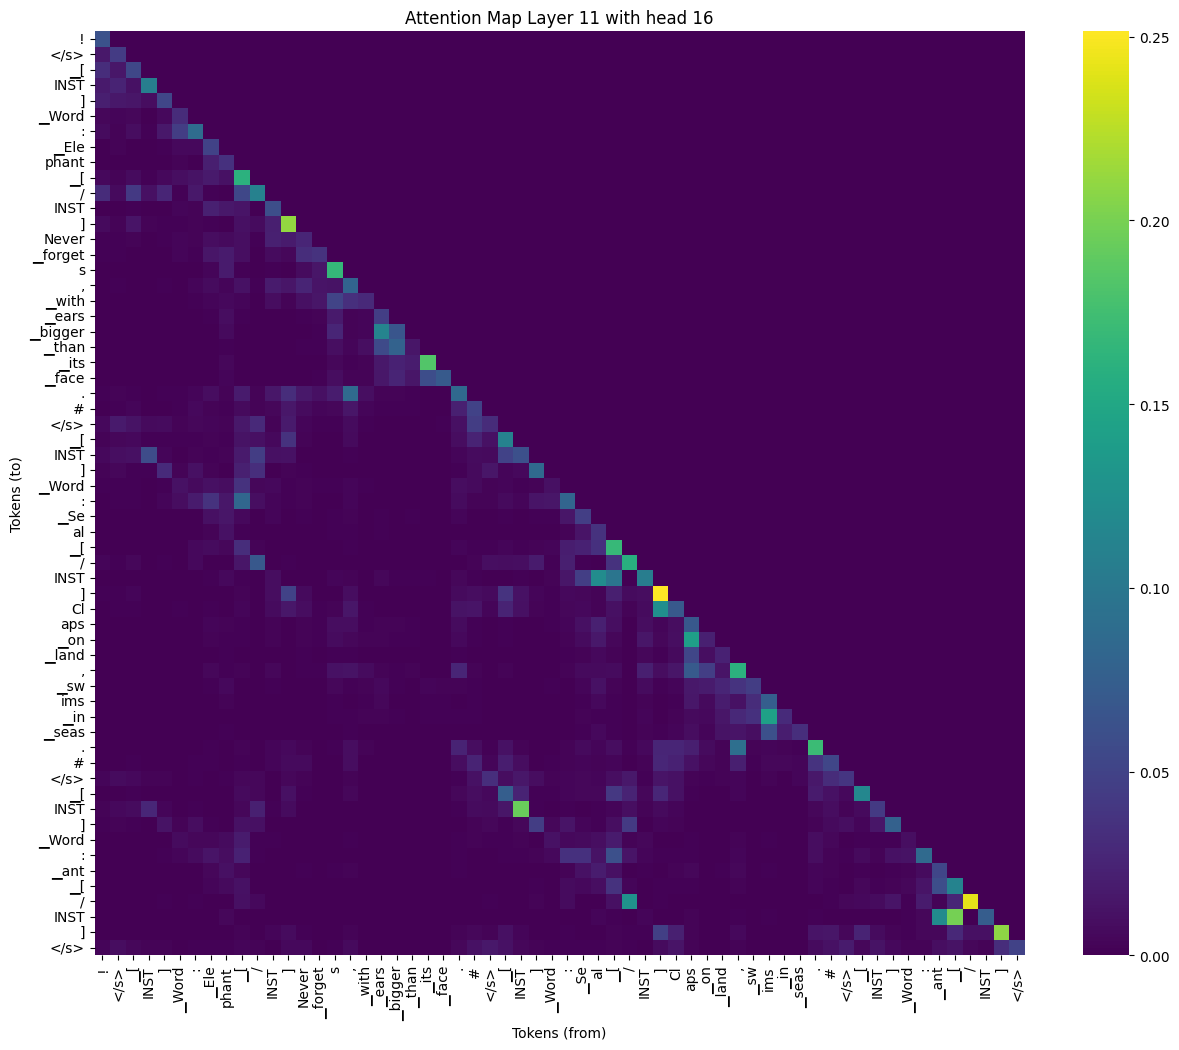

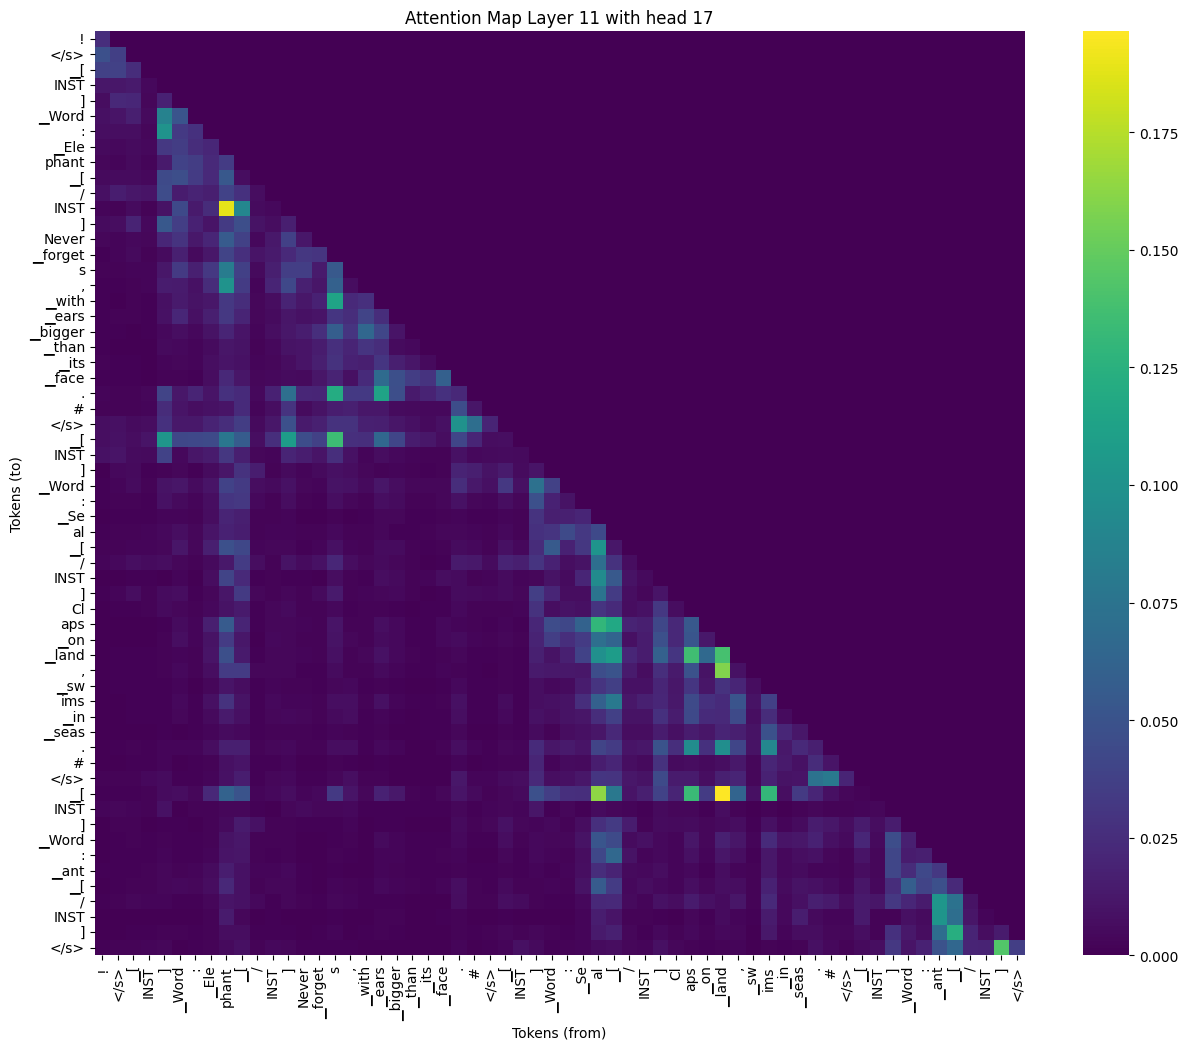

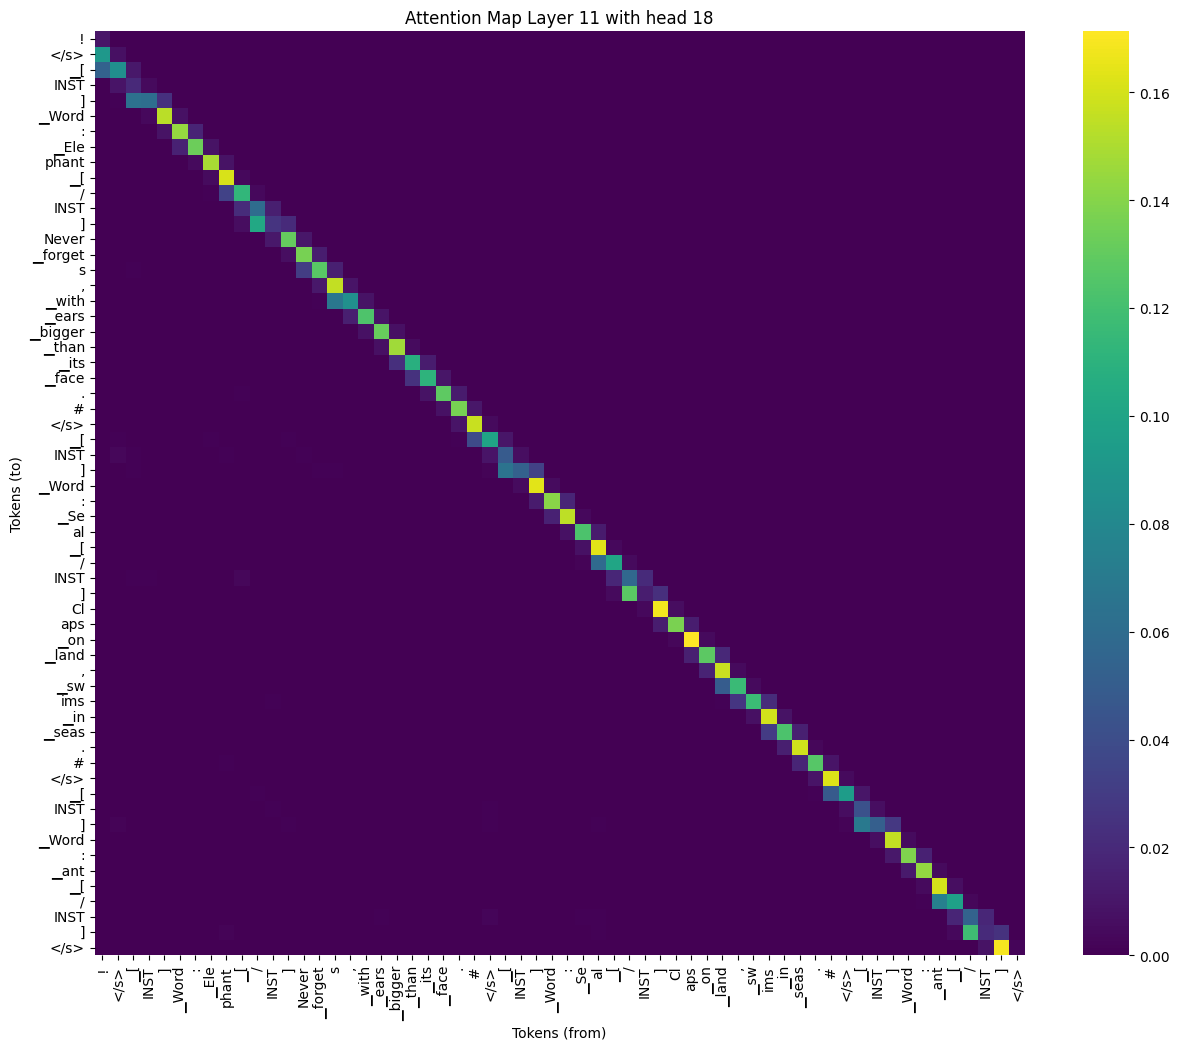

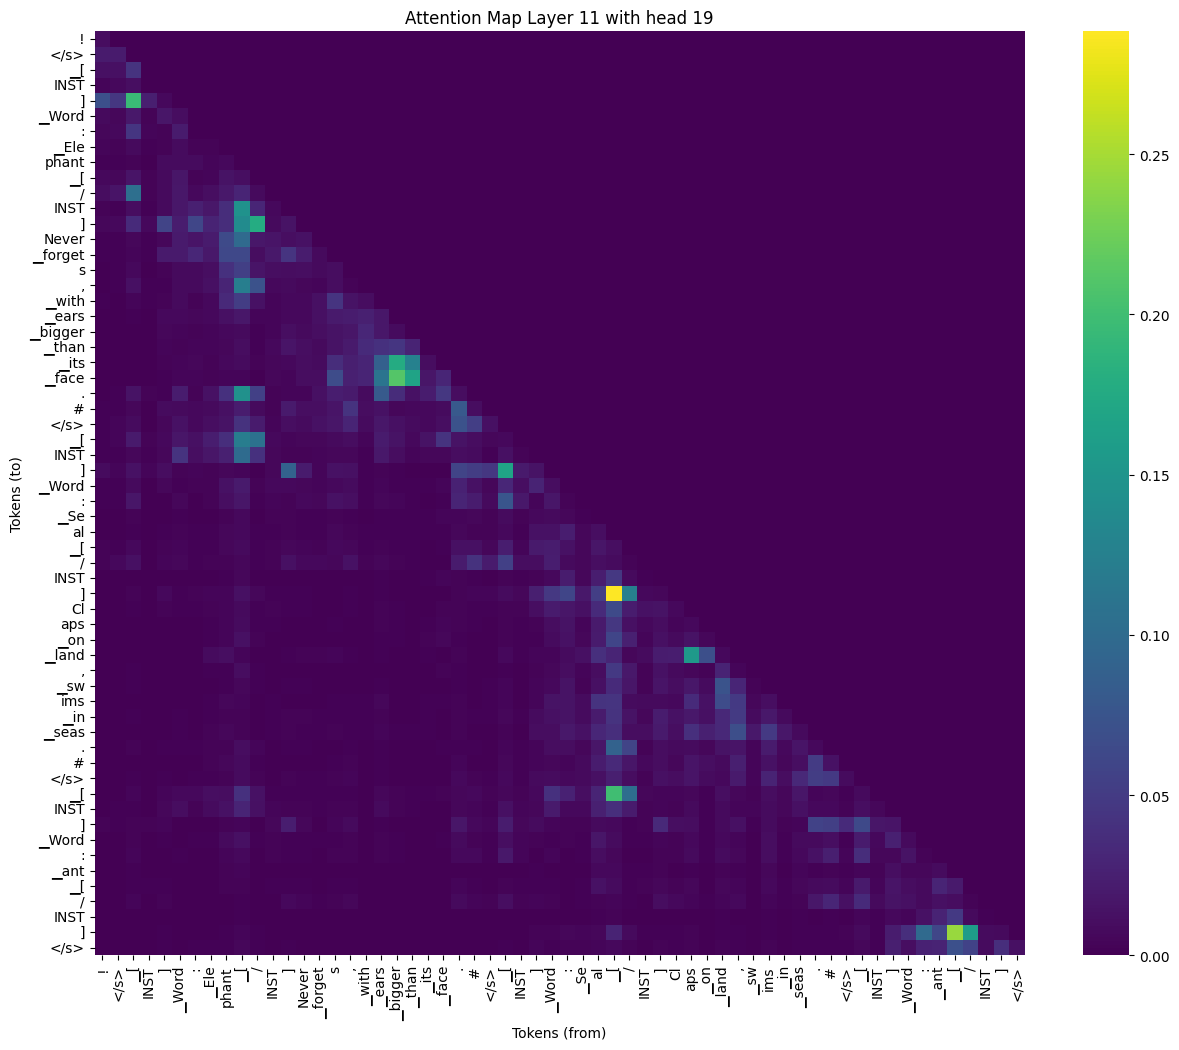

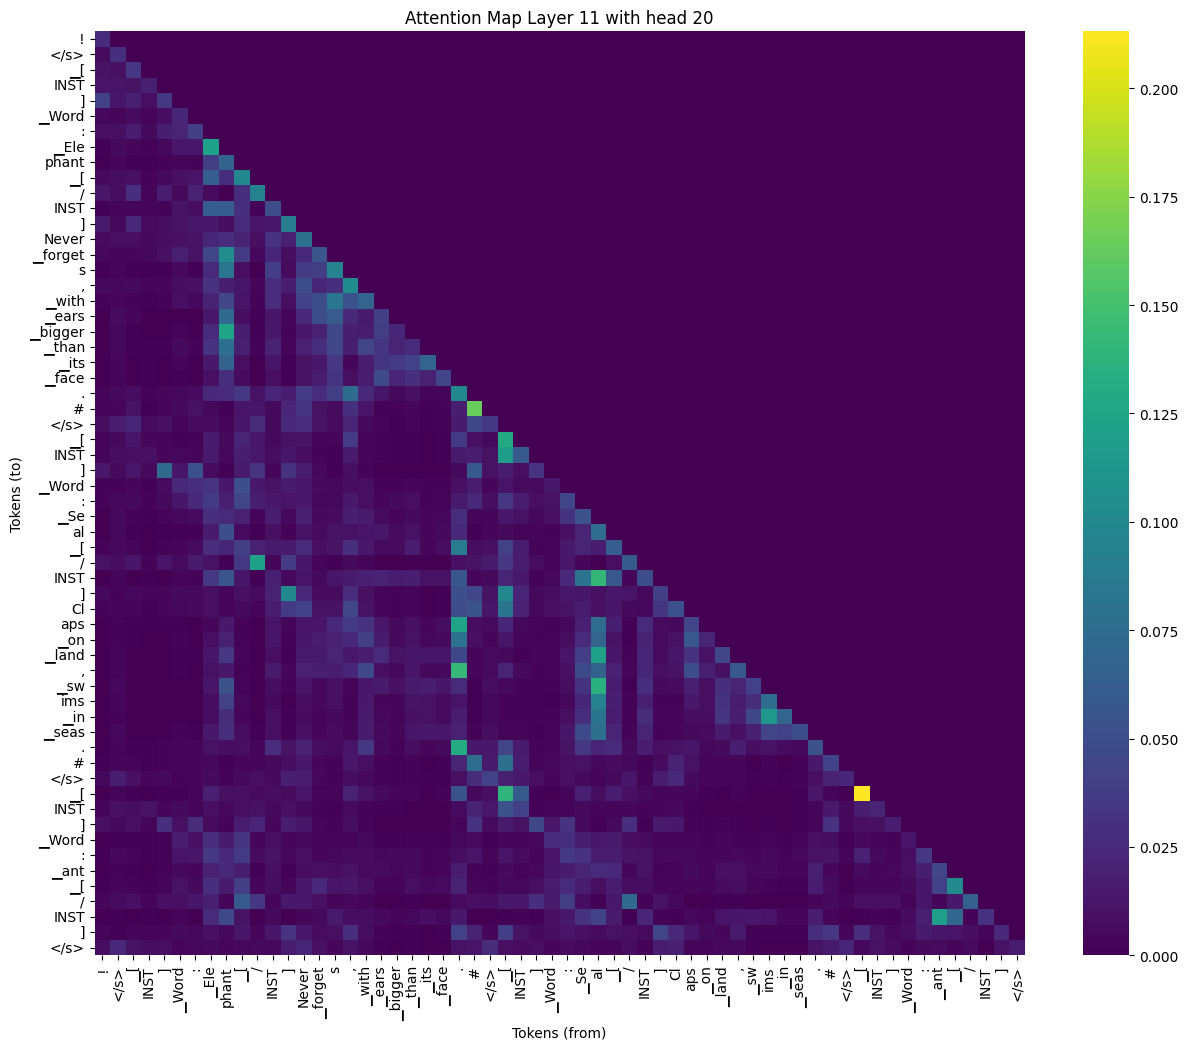

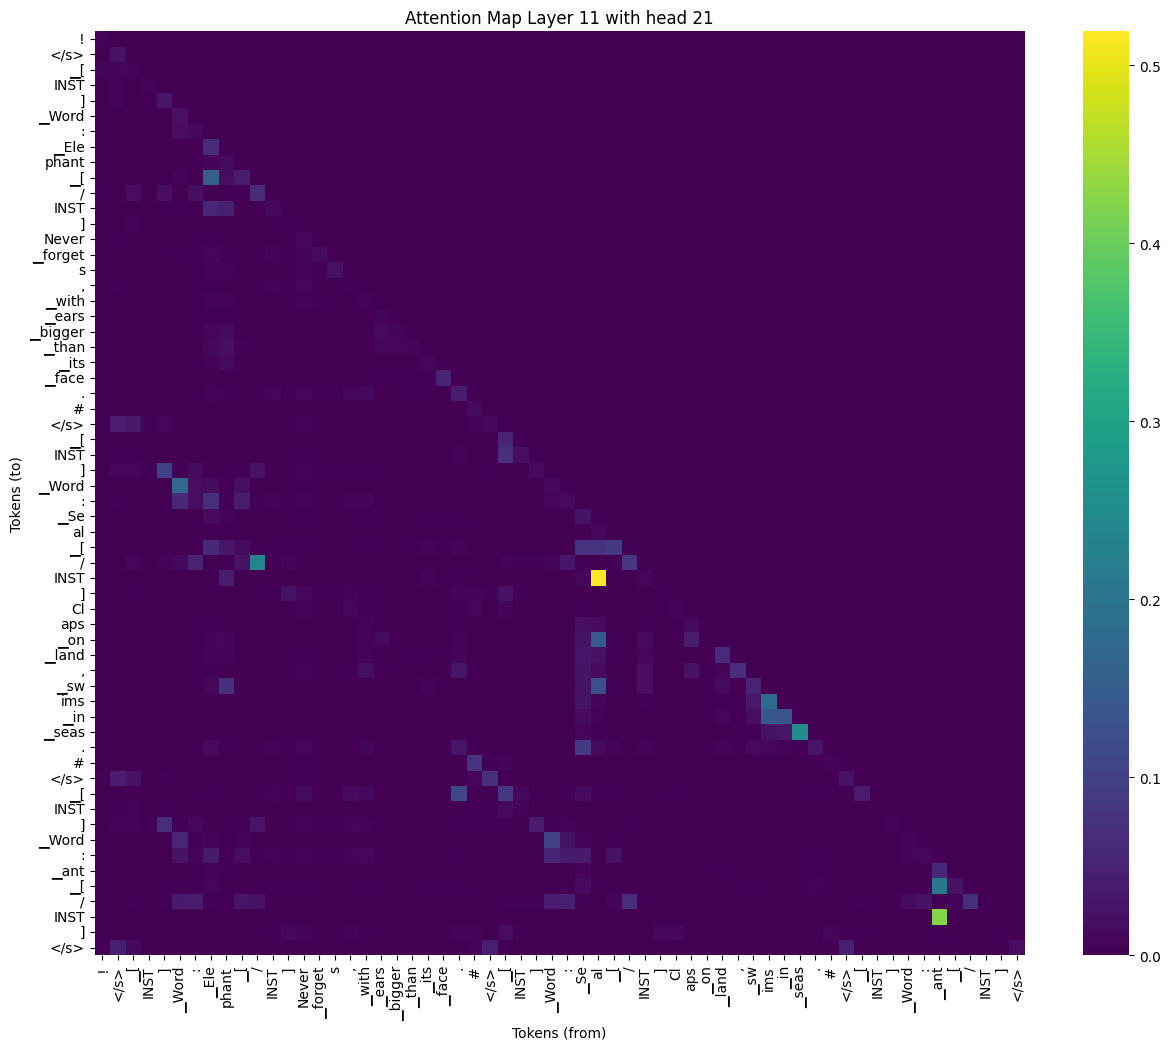

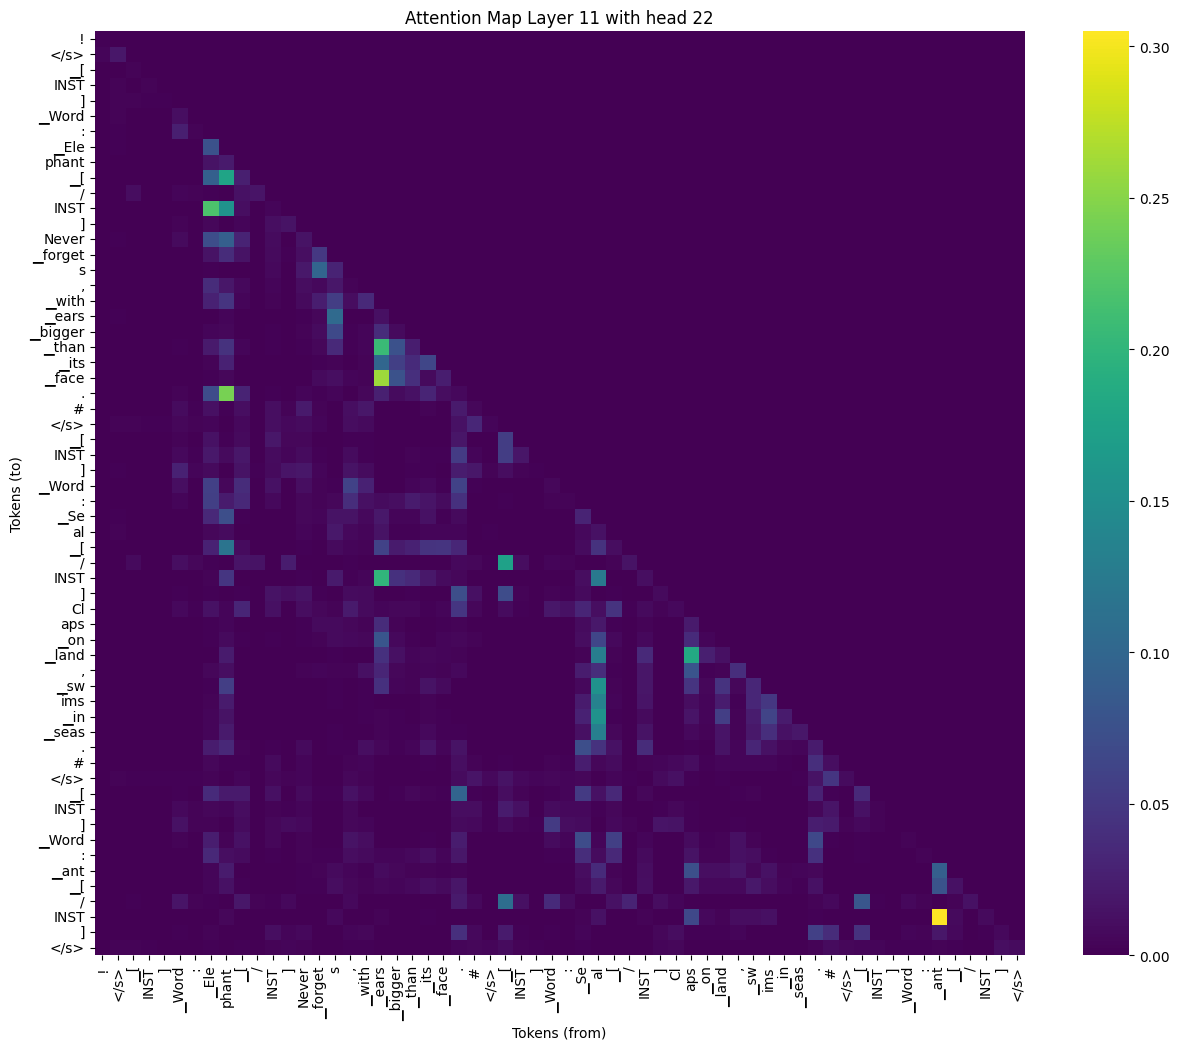

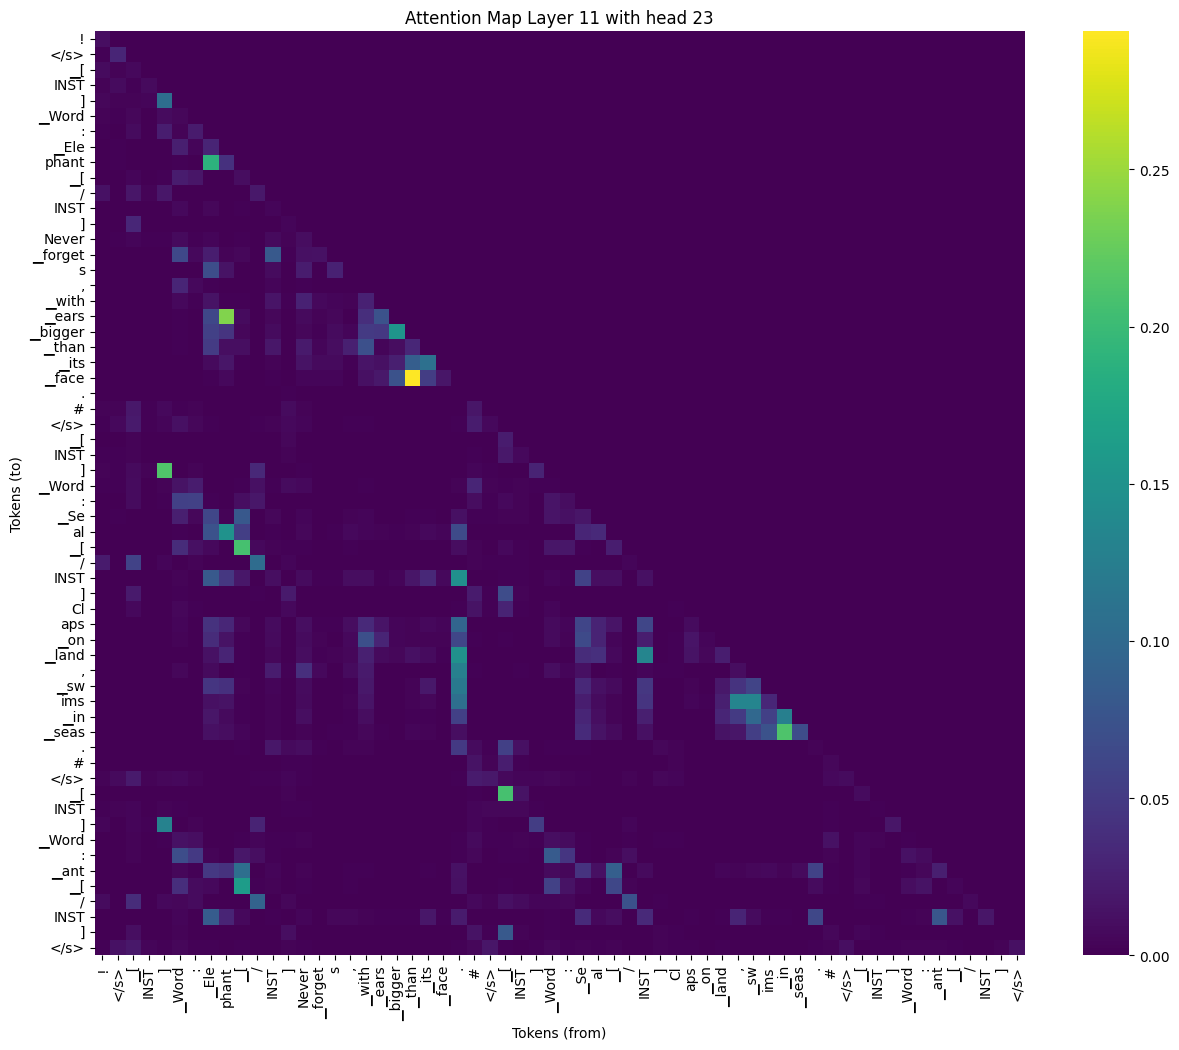

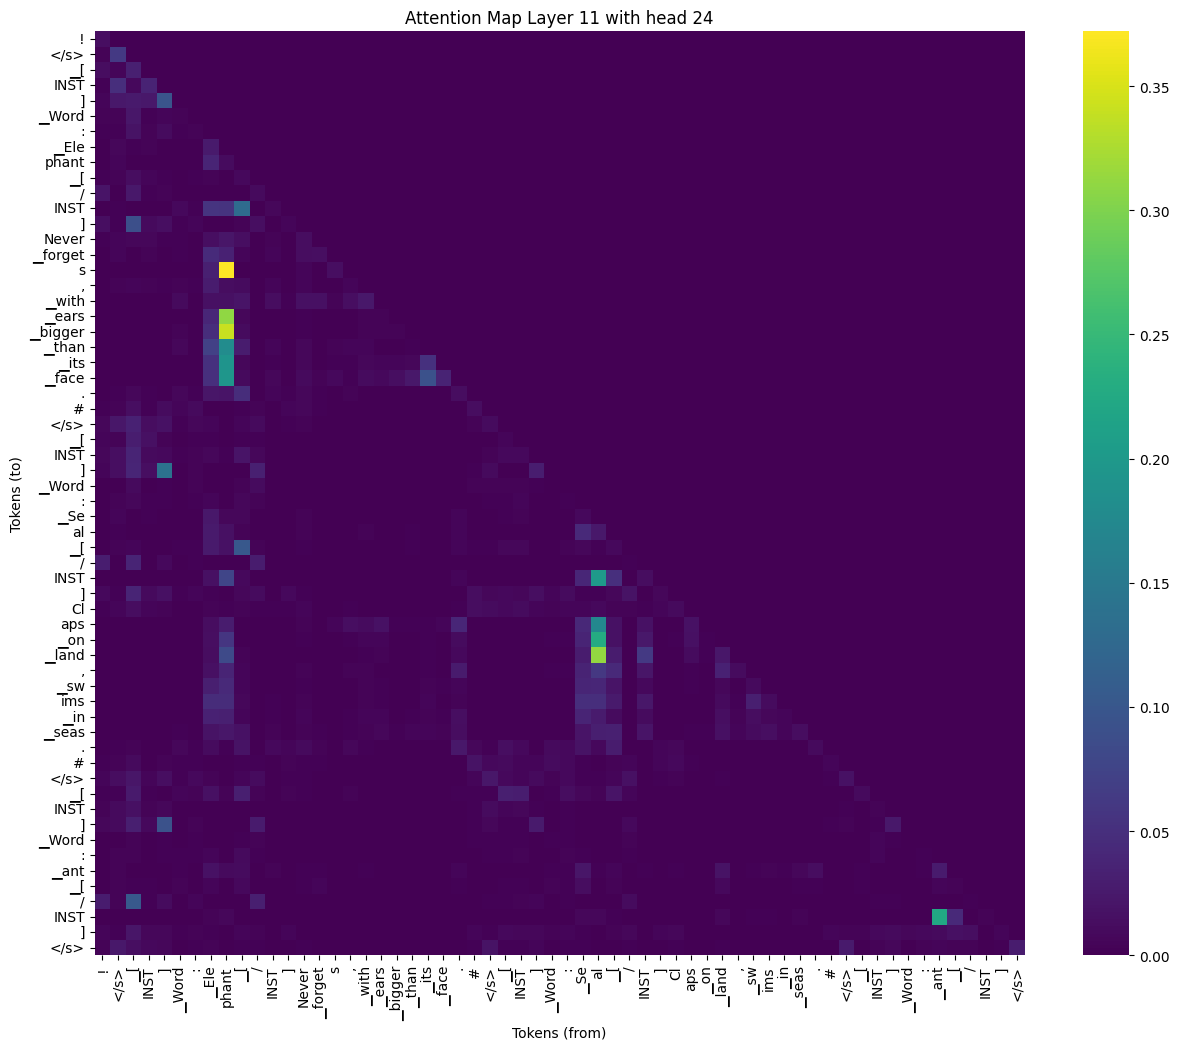

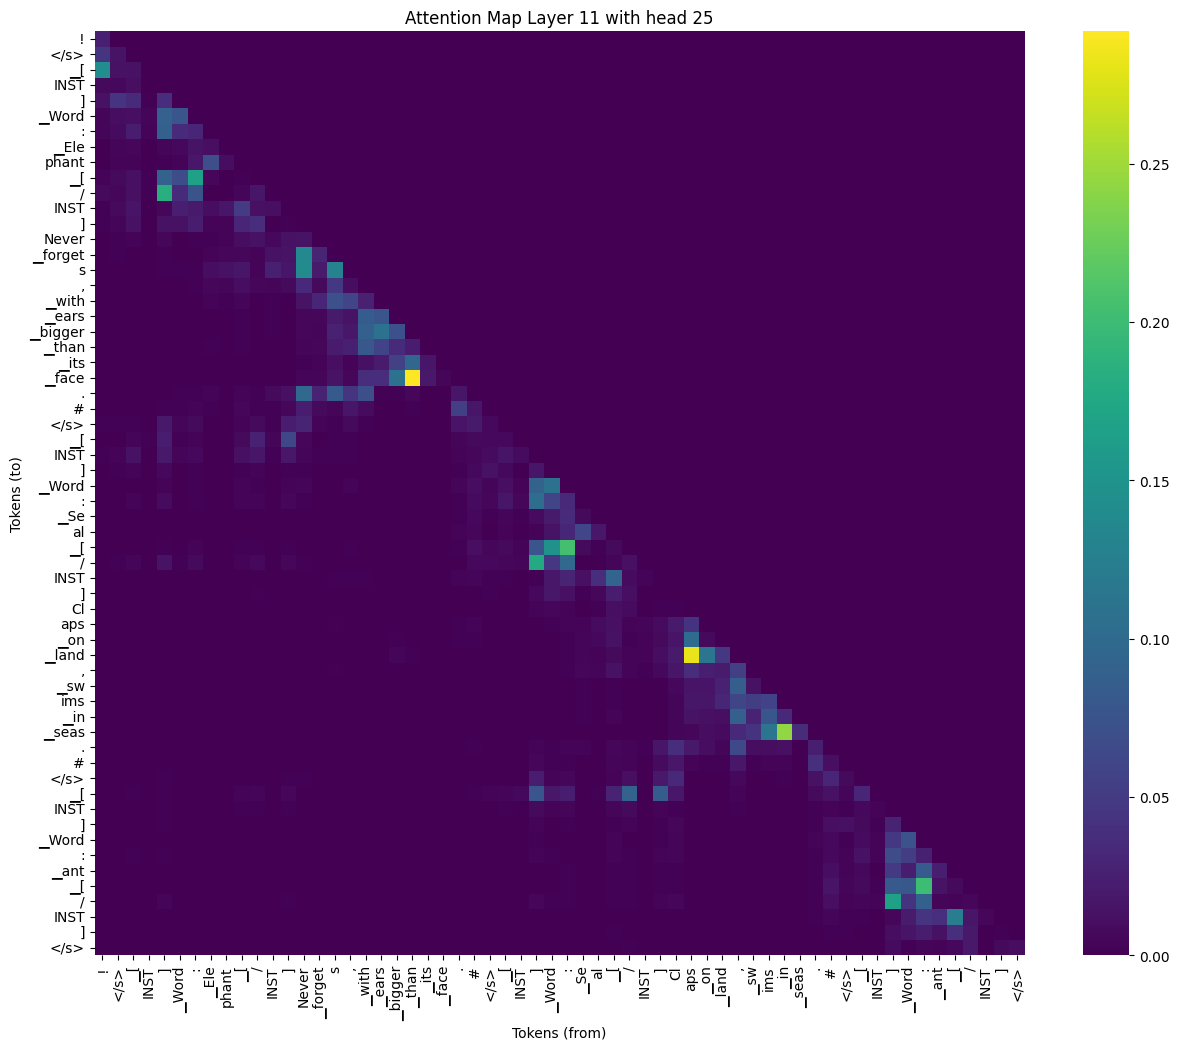

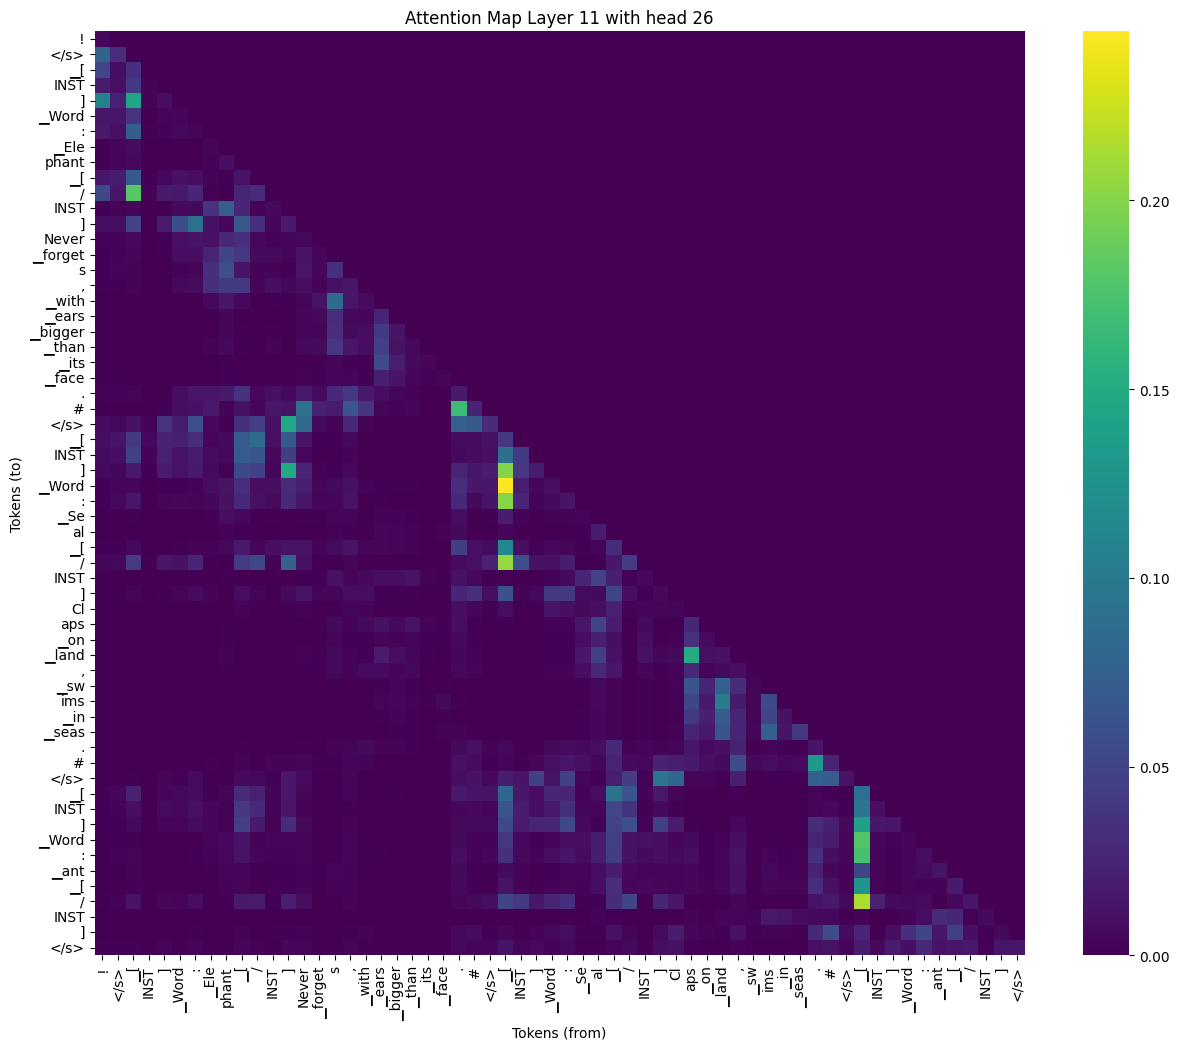

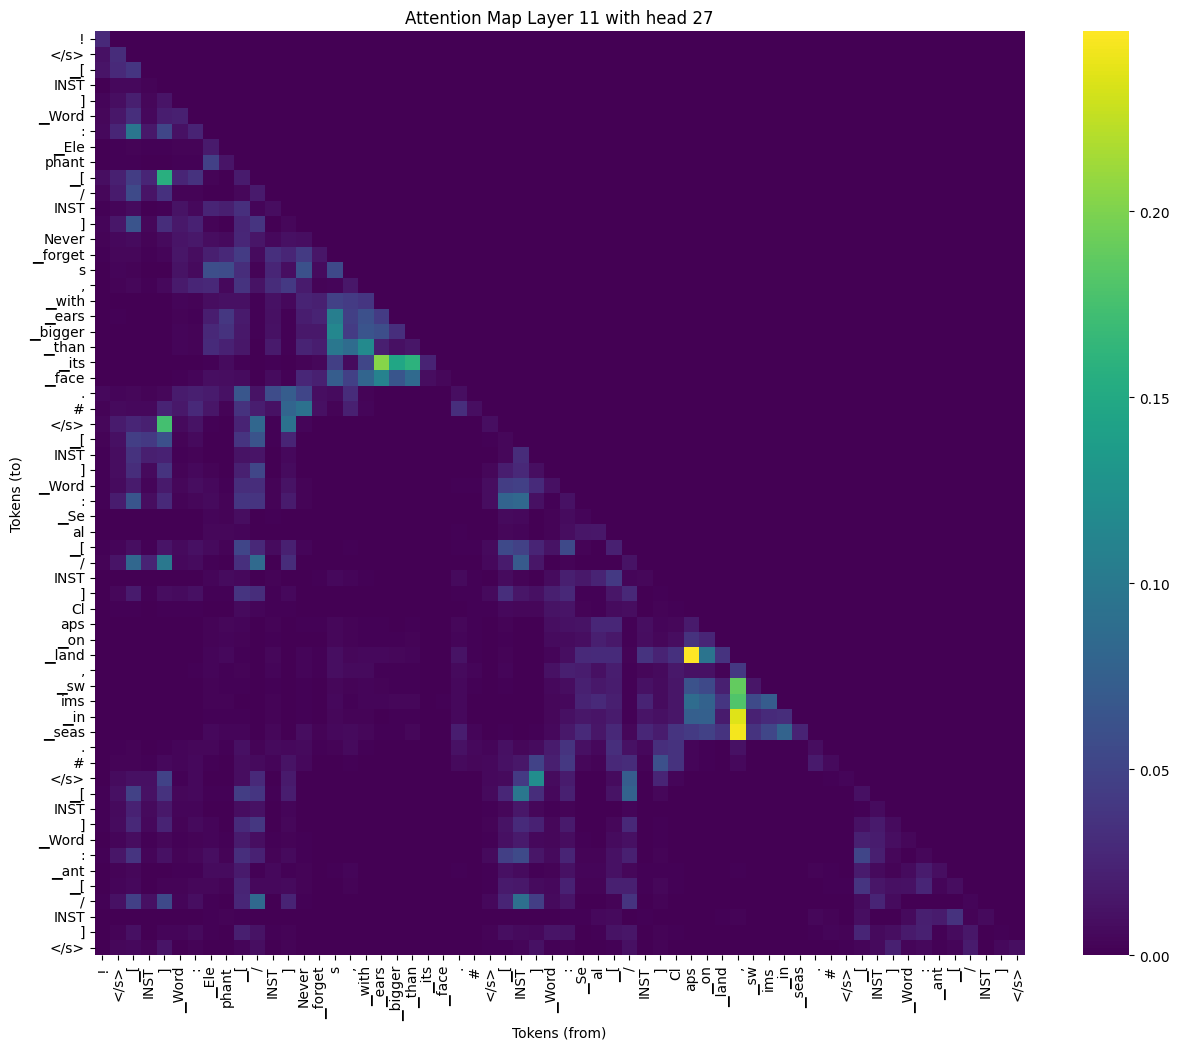

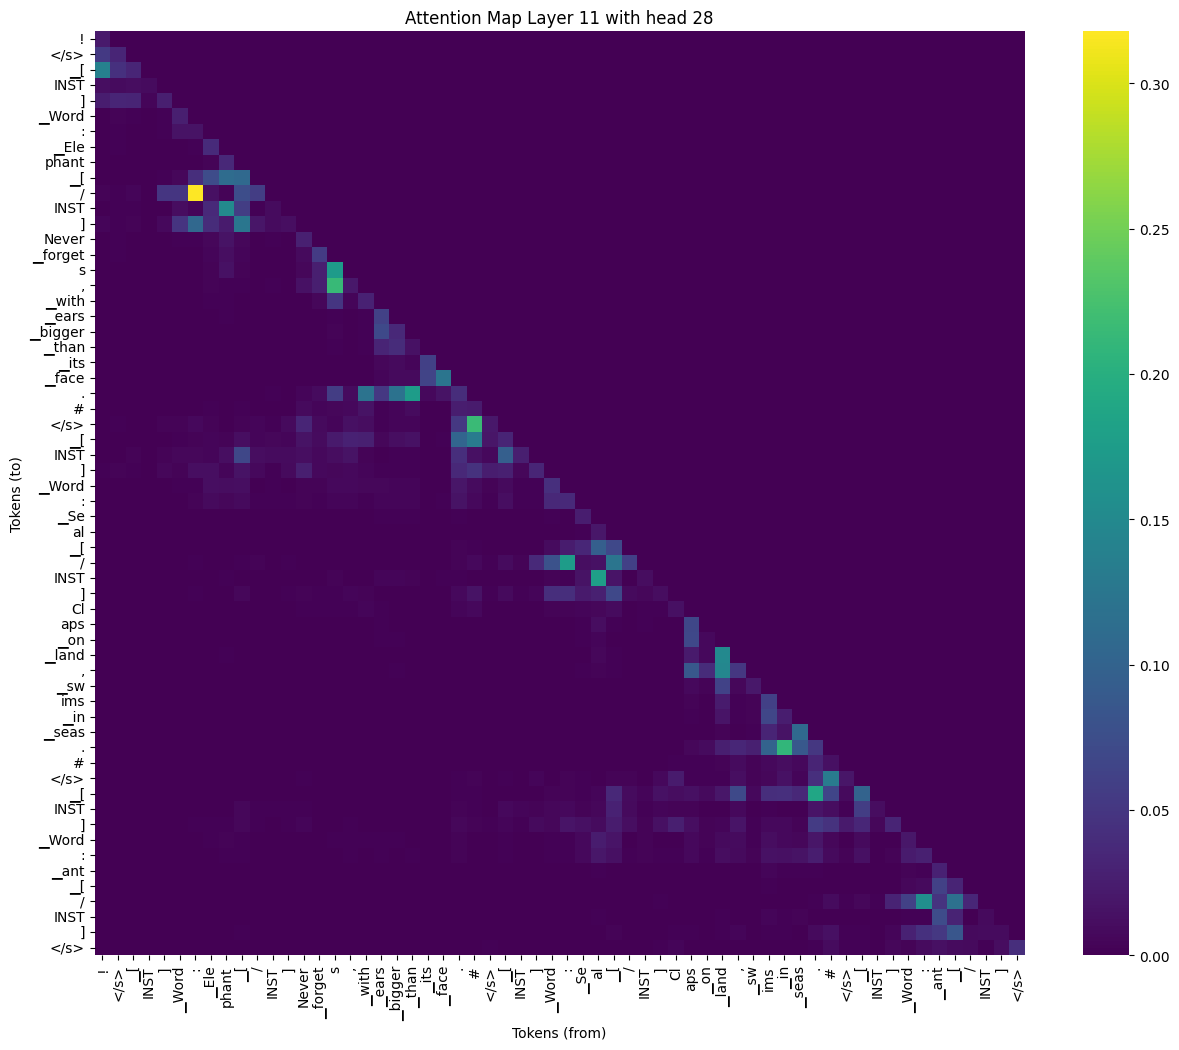

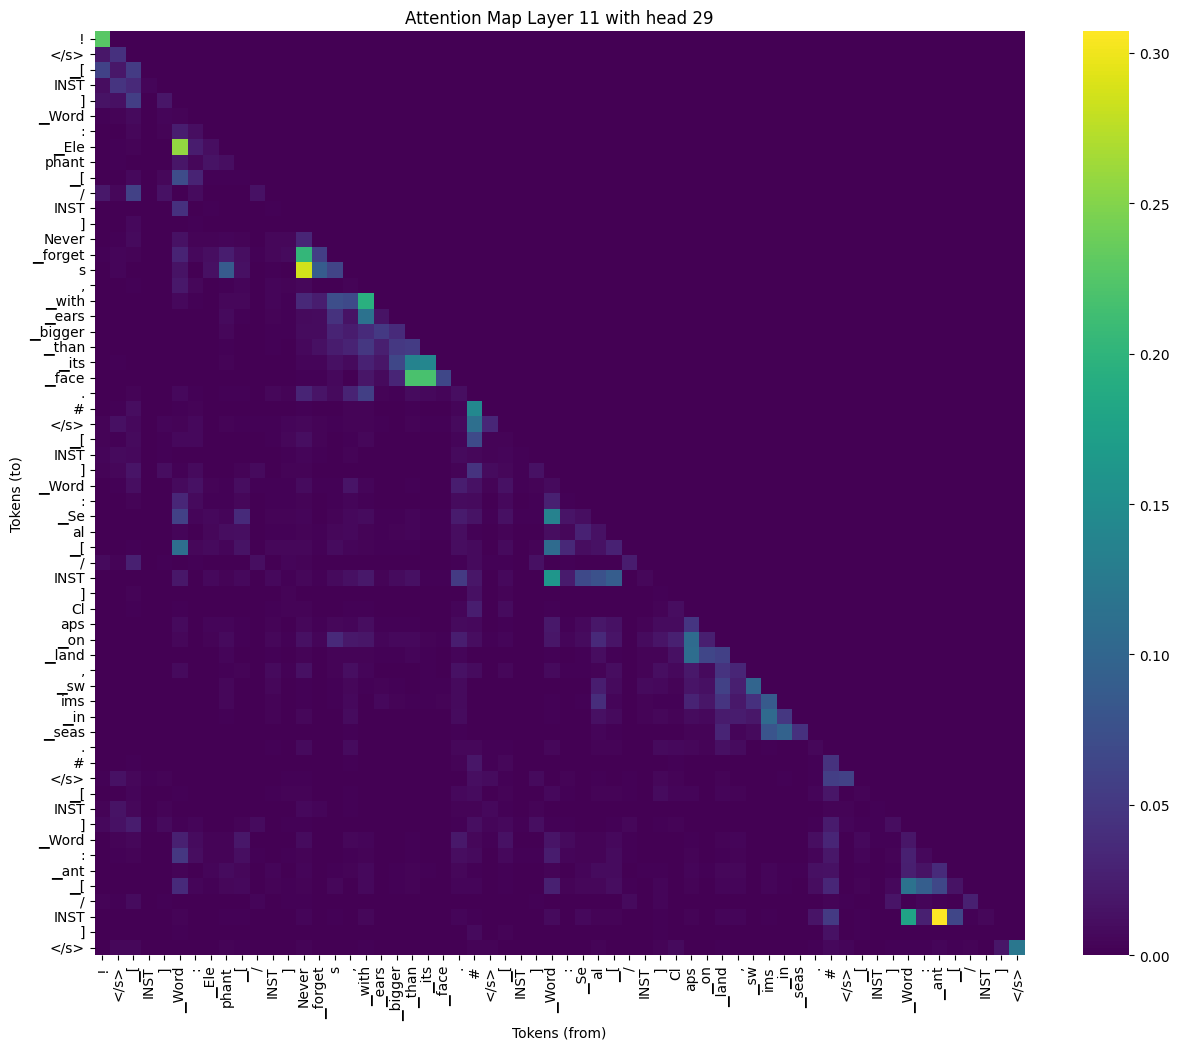

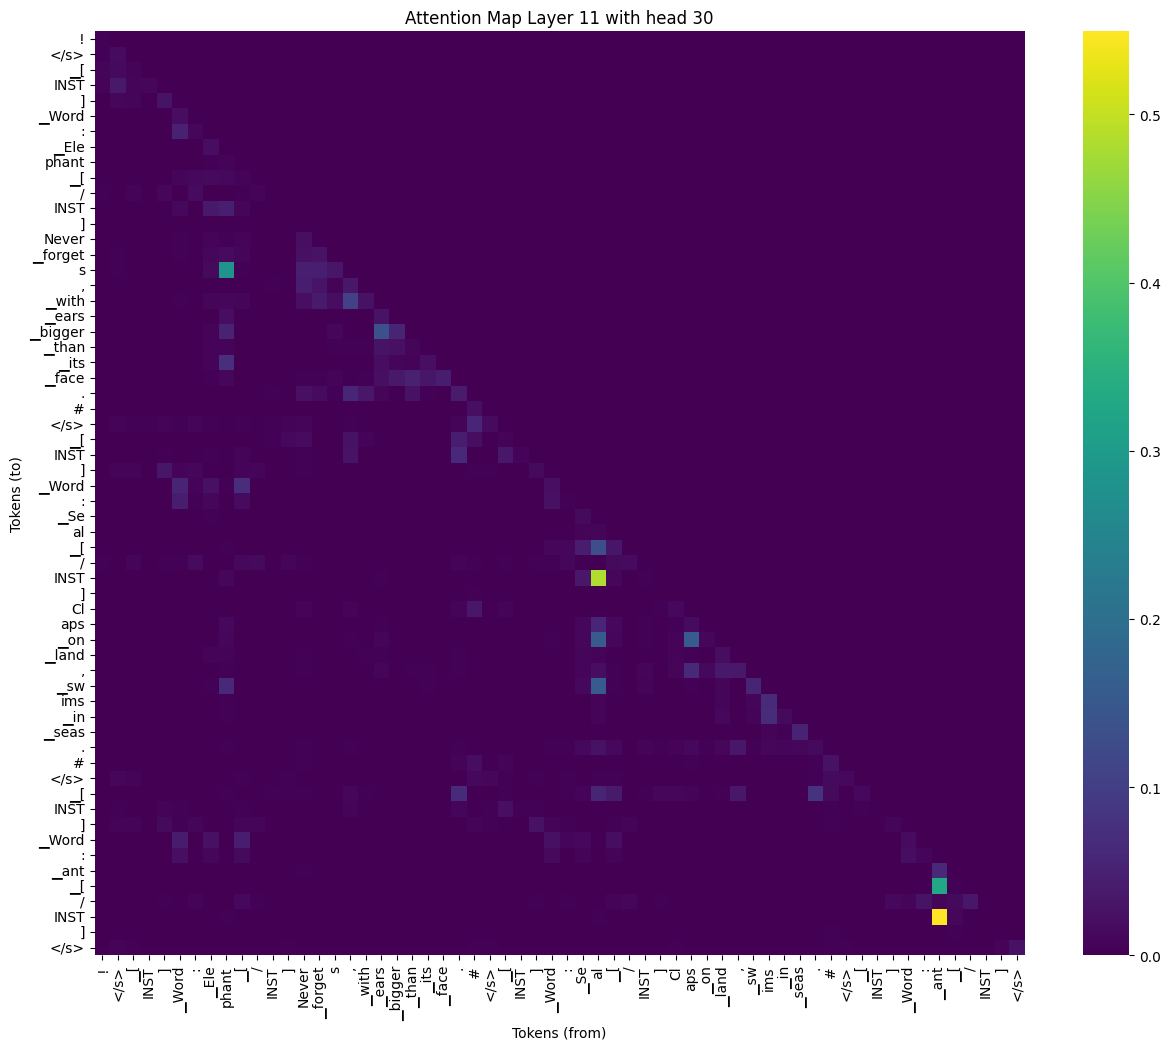

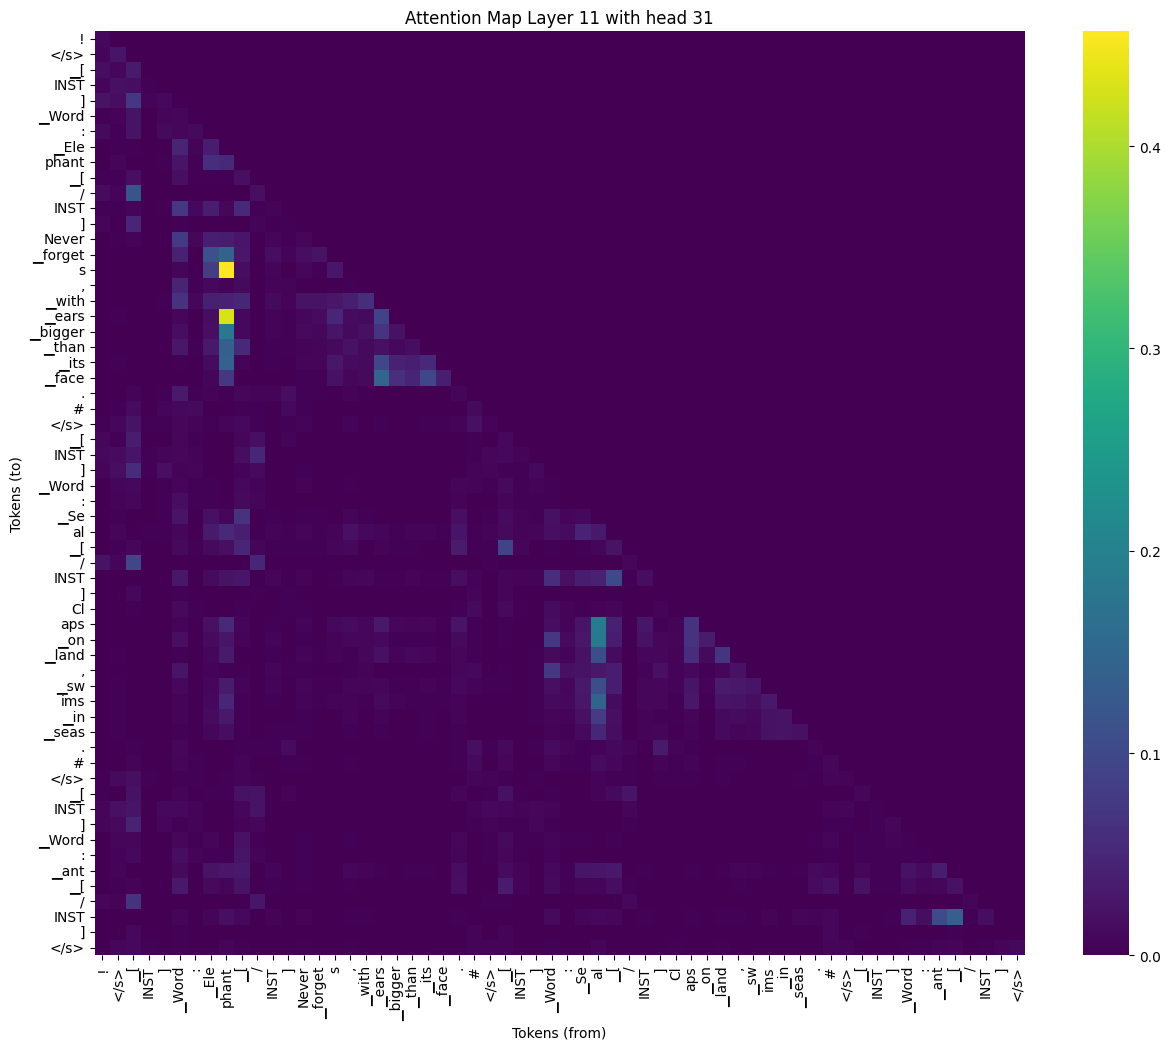

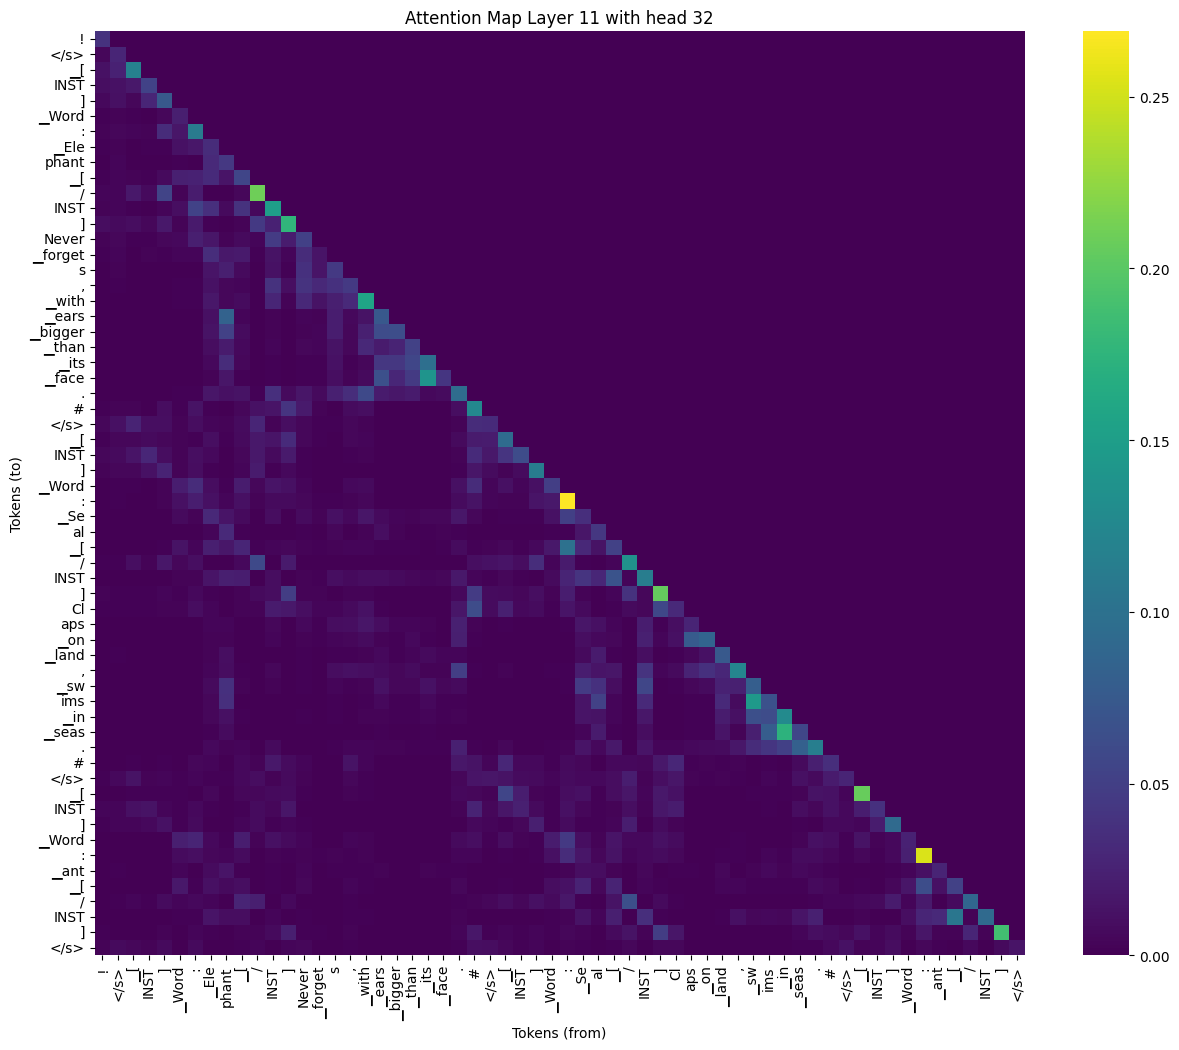


-----Word 1----

Word: ant

Generated Clue: Insect that forms intricate colonies, carrying leaves back to their hill.


In [15]:
N_EXAMPLES = 2
MODEL = model # "mistralai/Mistral-7B-Instruct-v0.2"
TOKENIZER = tokenizer
INPUT_WORDS_FILE_PATH = "words.txt"
OUTPUT_WORDS_CLUES_FILE_PATH = "clues_and_words.csv"

PROMPT_PREFIX = "This is a crossword clue generator. I will give you a word and you have to output a short clue " + \
                "related to the word, which is engaging and challenging. Just give one answer, marking the end with a #."

PRINT_OUTPUT = True

#for name, module in model.named_modules():
    #if hasattr(module, 'weight') and isinstance(module.weight, torch.Tensor):
        #weight = module.weight
        #print(module, name, weight.shape)
        #print(f'{name} - weight: {weight}')

generate(N_EXAMPLES, MODEL, TOKENIZER, INPUT_WORDS_FILE_PATH, OUTPUT_WORDS_CLUES_FILE_PATH, PROMPT_PREFIX, PRINT_OUTPUT, device)


In [8]:
from transformers import MistralModel, MistralConfig

configuration = MistralConfig()
model  = MistralModel(configuration)
configuration = model.config
print(configuration)

MistralConfig {
  "attention_dropout": 0.0,
  "bos_token_id": 1,
  "eos_token_id": 2,
  "hidden_act": "silu",
  "hidden_size": 4096,
  "initializer_range": 0.02,
  "intermediate_size": 14336,
  "max_position_embeddings": 131072,
  "model_type": "mistral",
  "num_attention_heads": 32,
  "num_hidden_layers": 32,
  "num_key_value_heads": 8,
  "rms_norm_eps": 1e-06,
  "rope_theta": 10000.0,
  "sliding_window": 4096,
  "tie_word_embeddings": false,
  "transformers_version": "4.38.2",
  "use_cache": true,
  "vocab_size": 32000
}

